In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import multivariate_normal
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm, trange
import time # to be used in loop iterations
np.random.seed(1234)

In [3]:
# set default parameters for notebook
# set dpi to 300
plt.rcParams['figure.dpi'] = 300
# set figsize to (6, 6)
plt.rcParams['figure.figsize'] = (9, 6)
# hide gridlines behind the plot
plt.rcParams['axes.axisbelow'] = True
# set gridlines to dashed
plt.rcParams['grid.linestyle'] = '--'
# set gridlines to light grey
plt.rcParams['grid.color'] = 'lightgrey'
# turn gridlines on by default
plt.rcParams['axes.grid'] = True

# Methods for Data Science: Course Work 2

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

#### 1.1.1

To classify images in the MNIST dataset, we will train a feed-forward neural network with the following architecture:

>1. one input layer with 784 neurons (the size of each image encoded as an array),
>2. 3 hidden layers (with 200 neurons each), 
>3. followed by the output layer with 10 neurons (one for each class).  

Furthermore, our MLP will need the following parameters:

>Input layer -> first hidden layer:
>* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{784\times 200}$
>* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{200}$

>Hidden layer -> hidden layer:
>* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{200\times 200}$, $k=1, 2$
>* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{200}$, $k=1, 2$

>Hidden layer -> output layer:
>* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{200\times 10}$
>* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{10}$, 

The above parameters will be created as numpy arrays, and the weight matrices $W^{(k)}, k = 0,1,2,3$ are initialised using Glorot initialisaiton from [1] (paper attached in the mlp notebook), namely, with samples from a uniform distribution supported on the interval $\left[-\frac{\sqrt{6} }{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6} }{\sqrt{n_{in} + n_{out}}}\right]$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. The bias parameters will be initialised to zeros.

The hidden layers of our model will use a sofltplus activation function:
$$
\text{Softplus}(x) = \frac{\log(1+\exp{\beta x})}{\beta}
$$

The activatios $\boldsymbol h^{(k+1)}$ of a hidden layer $k = 0,1,2$ is given by:
$$
\boldsymbol h^{(k+1)} = \text{SoftPlus}(\boldsymbol h^{(k)} W^{(k)} + b^{(k)})
$$

The output of the MLP is given by:
$$
y_{\text{out}} = \text{SoftMax}(\boldsymbol h^{(3)} W^{(3)} + b^{(3)}),
$$
where the Softmax function 
$$
\text{Softmax}: \mathbb{R}^{10}\to \mathbb{R}^{10}
$$
is given by:
$$
\text{Softmax}(\boldsymbol y)_i = \frac{e^{y_i}}{\Sigma},
$$
and 
$$\Sigma = \displaystyle \sum_{i=1}^{10} e^{y_i}.$$

In [4]:
def softplus(x,β = 1):
    """
    Computes the softplus function of the given input x.
    
    Args:
        x (float or numpy.ndarray): The input values to compute the softplus function for.
        β (float, optional): The scaling factor for the input x. Defaults to 1.

    Returns:
        float or numpy.ndarray: The output of the softplus function, with the same shape as x.
    """
    return np.log(1+np.exp(-np.abs(x))) + np.maximum(x,0)

In [5]:
def dense(h, W, b):
    
    """
    Computes the output of a dense layer given an input h, a kernel matrix W, and bias parameters b.

    Args:
        h (numpy.ndarray): A K x h_in array of input values.
        W (numpy.ndarray): An h_in x h_out array for kernel matrix parameters.
        b (numpy.ndarray): A length h_out 1-D array for bias parameters.

    Returns:
        numpy.ndarray: A K x h_out array containing the output of the dense layer.
    """
    return  h @ W + b

In [6]:
def softmax(y):
    """
    Computes the softmax activation function on the given input array y.

    Args:
        y (numpy.ndarray): An input array of shape (K,) or (K, L),\
        where K is the number of input elements and L is the number
        of classes.

    Returns:
        numpy.ndarray: An output array of shape (K,) or (K, L),\
        containing the softmax function's output for the input y.
    """
    if y.shape[0]==1:
        y = np.squeeze(y)
        max_y = np.max(y)
        y = y - max_y
        return np.exp(y)/np.sum(np.exp(y))
    else:
        max_y = np.max(y, axis = 1)
        y = y - max_y.reshape(-1,1)
        return np.exp(y)/np.sum(np.exp(y), axis=1).reshape(-1,1)

## [Todo: ] Note: you may want to consider transformations of the KL divergence to avoid underflow issues if necessary

We fix the optimisation method as stochastic gradient descent (SGD), and define the loss function as the KL
divergence. KL divergence is given by 
$$
    \mathcal{L}_{\text{KL}}(\boldsymbol y_{\text{out}}(\theta), y) = \displaystyle \sum_{i\in I}y_i\log\frac{y_i}{y_{\text{out}}(\theta)}_i,
$$

where $I$ is the set of output variables (in this case, $I = \{0,1,\cdots, 9\}$) and $\boldsymbol y_{\text{out}}(\theta)$, the output of our model with parameters denoted by $\theta$ and $y$ denotes the one-hot encoding of the ground truth labels of each image, i.e. the digit it corresponds to. Now, using the elementary fact from analysis, namely, 

$$
\displaystyle \lim_{x\to 0} x\log(x)\to 0,
$$
one can re-xpress the KL divergence as:
$$
 \mathcal{L}_{\text{KL}}(\boldsymbol y_{\text{out}}(\theta), y) = \displaystyle \sum_{i\in I, y_i \neq 0 }y_i\log\frac{y_i}{y_{\text{out}}(\theta)}_i,
$$
that is, we only retain non-zero terms in the vector $y$, avoiding overflow/underflow issues. For this dataset, $y$ is always going to contain one non-zero value. Also, since $y_{\text{out}}(\theta)$ is the output of a softmax layer, al of its components are strictly positive, thus making this implementation of KL divergence numerically stable.

We recall from the lecture notes that the backpropagation algorithm can be summarised as follows:

>1. Propagate the signal forwards by passing an input vector $x_i$ through the network and computing all pre-activations and post-activations using $\mathbf{a}^{(k)} = (\boldsymbol{h}^{(k-1)})^T\boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)}, k = 1,2,3,4$
>2. Define the **error** $\delta^{(k)} := \frac{\partial \mathcal{L}_i}{\partial a^{(k)}}$ for layers $k = 1,2,3$, where we denote $\mathcal{L}_i$ as the loss for example $i$
> 3. Evaluate $\boldsymbol{\delta}^{(4)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(4)}}$ for the output neurons
> 4. Backpropagate the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\boldsymbol{\delta}^{(k)} = \boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})  \boldsymbol{W}^{(k)} \boldsymbol{\delta}^{(k+1)}, k = 0,1,2,3$
> 5. Obtain the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$

In the above, $\boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})$ is a diagonal matrix with diagonal elements $\sigma'(a^{(k)}_p) = \frac{d \text{Softplus}(a^{(k)}_p)}{dx} = \frac{\exp(a^{(k)}_p)}{1+\exp(a^{(k)}_p)}$, $p=1,\ldots,n_k$, where $n_k$ is the number of neurons in layer $k$.

Now, we compute the output error
$$
\boldsymbol{\delta}^{(4)} = \frac{\partial \mathcal{L}_{\text{KL}}(\theta_t, \boldsymbol y_{\text{out}}(\theta_t |\mathcal{X}^{(i)}),\mathcal{Y}^{(i)})}{\partial \boldsymbol{a}^{(4)}}
$$
where $\theta_t$ denote the model parameters at time $t$.

For arbitrary ground truth distributions $\hat{y}$ and parameters propagated from last hidden-layer $\boldsymbol y = \boldsymbol a^{(4)}$, the gradient of the KL divergence loss composed with the softmax activation from the outut layer is:

$$
\frac{\partial KL( \text{Softmax}(\boldsymbol y); \hat{y})}{\partial y_j} = \frac{\partial }{\partial y_j}\displaystyle \sum_{i\in I}\hat{y}_i\log\frac{\hat{y}_i}{\text{Softmax}(\boldsymbol y)_i} \\
 = -\frac{\partial }{\partial y_j}\displaystyle \sum_{i\in I}\hat{y}_i\log{\text{Softmax}(\boldsymbol y)_i} 
 = -\displaystyle \sum_{i\in I}\hat{y}_i\frac{\partial }{\partial y_j}\log{\text{Softmax}(\boldsymbol y)_i}.
$$
Thus, 
$$
\frac{\partial KL( \text{Softmax}(\boldsymbol y); \hat{y})}{\partial y_j} = 
-\displaystyle \sum_{i\in I}\hat{y}_i\frac{\partial }{\partial y_j}\log{\frac{e^{y_i}}{\Sigma}}\\
= -\displaystyle \sum_{i\in I}\hat{y}_i\frac{\partial \left(y_i -\log{\Sigma}\right)}{\partial y_j}
 = -\hat{y}_i\delta_{ij} + \displaystyle \sum_{i\in I}\frac{\hat{y}_i}{\Sigma}\frac{\partial \Sigma}{\partial y_j} = - \hat{y}_j + \text{Softmax}(\boldsymbol y)_j.
$$
since $\displaystyle \sum_{i\in I}\hat{y}_i = 1$. In vector form the gradient can be expressed as
$$
\nabla_{\boldsymbol a^{(4)}} KL(\text{Softmax}(\boldsymbol y); \hat{y}) = \text{Softmax}(\boldsymbol y) -  \hat{y}
= y_{\text{out}}(\theta) -  \hat{y} = \boldsymbol a^{(4)}  - \hat{y}.
$$
The other components of the loss gradient cam be computed using the back propagation algorithm above.

Now that we have obtained an expresison for the gradient of the loss function $\mathcal{L}_{\text{KL}}$ with respect to the network parameters $\theta$, we turn outselves to the Stochastic gradient descent algorithm.
During each epoch, the feature matrix $X$ and ground truth labels $Y$, are paritioned $\textbf{in parallel}$ at random into batches $\mathcal{X_i}$ and $\mathcal{Y}_i$. For each batch, a parameter update to the neural network weighst $\theta = (W^{(k)}, b^{(k)})_{k = 0,1,2,3}$ is made by computing the mean batch gradient as in [5]:

$$
D(\theta | \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}) = \frac{1}{|\mathcal{Y}_i|}\displaystyle \sum_{x\in \mathcal{X}^{(i)},y(x)\in \mathcal{Y}^{(i)}}\nabla\mathcal{L}_{\text{KL}}( \theta  \mid x, y(x)),
$$

where $\mathcal{X}^{(i)}, \mathcal{Y}^{(i)}$ are the $i$-th batch of samples and their respective ground truth labels. And performing said update:
$$
\theta_{t+1} = \theta_{t} - \eta D(\theta | \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}),
$$

where $\eta>0$ is the learning rate. 

In [7]:
def activation_derivative(a):
    """
    Computes the derivative of the activation function used in a neural network's hidden layer.

    The activation function used in this implementation is a\
    numerically stable version of the ReLU functiongiven by:\
    1 / (1 + exp(-a)) for a >= 0, and exp(a) / (1 + exp(a)) for a < 0.

    Args:
        a (numpy.ndarray): A K x 200 array of hidden layer pre-activations.

    Returns:
        numpy.ndarray: A K x 200 array of diagonal elements\
        containing the derivative of the activation function with respect
        to the input a.
    """
    
    derivative = np.where(a >= 0, 
                1 / (1 + np.exp(-a)), 
                np.exp(a) / (1 + np.exp(a)))

    
    return  derivative # dlog(1+exp(x)) = exp(x)/(1+exp(x))

In [8]:
def one_hot_encode(y):
    """
    Encodes a 1-D array of labels into one-hot vectors.

    Arguments:
    y: 1-D numpy array of shape (N,), where N is the number of samples.
       The values represent the class labels.

    Returns:
    A numpy array of shape (N, num_classes), where num_classes is the number of unique labels.
    Each row represents the one-hot encoding of the corresponding label in y.
    """
    
    num_classes = np.max(y) + 1  # number of unique classes
    y_batch_prob = np.zeros((y.shape[0], num_classes))

    for i in range(y.shape[0]):
        y_batch_prob[i, y[i]] = 1.

    return y_batch_prob

In [9]:
def mlp(x, W0, b0, W1, b1, W2, b2, W3, b3, β=1):
    """
    Implements a 3-layer neural network with the given weights and biases,\
    and applies a softmax function to the output.

    Args:
        x (numpy.ndarray): A K x N array of input data.
        W0 (numpy.ndarray): An h_in x h_out array of weights for the first hidden layer.
        b0 (numpy.ndarray): A length h_out 1-D array of biases for the first hidden layer.
        W1 (numpy.ndarray): An h_out x h_out array of weights for the second hidden layer.
        b1 (numpy.ndarray): A length h_out 1-D array of biases for the second hidden layer.
        W2 (numpy.ndarray): An h_out x h_out array of weights for the third hidden layer.
        b2 (numpy.ndarray): A length h_out 1-D array of biases for the third hidden layer.
        W3 (numpy.ndarray): An h_out x 10 array of weights for the output layer.
        b3 (numpy.ndarray): A length 10 1-D array of biases for the output layer.
        β (float, optional): The β value to use for the softplus activation function. Defaults to 1.

    Returns:
        numpy.ndarray: A K x 10 output array containing the softmax activation of the neural network's output layer.
    """
    
    # Compute the activations and outputs for the input layer and each hidden layer
    a1 = dense(x, W0, b0)
    h1 = softplus(a1, β)
    
    a2 = dense(h1, W1, b1)
    h2 = softplus(a2, β)
    
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3, β)
    
    # Compute the pre-softmax output of the neural network
    a4 = dense(h3, W3, b3)
    
    # Apply the softmax function to the output of the neural network
    return softmax(a4)

In [10]:
def KL_loss(x_batch, y_batch, W0, b0, W1, b1, W2, b2, W3, b3):
    """
    Computes the Kullback-Leibler divergence loss between predicted and actual labels.

    Arguments:
    x_batch: 2-D numpy array of shape (K, D), where K is the batch size and D is the number of features.
             The input data for the batch.
    y_batch: 1-D numpy array of shape (K,), where K is the batch size.
             The actual class labels for the input data.
    W0: 2-D numpy array of shape (D, h), where h is the number of hidden units in the first layer.
    b0: 1-D numpy array of shape (h,), where h is the number of hidden units in the first layer.
        The bias parameters for the first layer.
    W1: 2-D numpy array of shape (h, h), where h is the number of hidden units in each hidden layer.
    b1: 1-D numpy array of shape (h,), where h is the number of hidden units in each hidden layer.
        The bias parameters for each hidden layer.
    W2: 2-D numpy array of shape (h, h), where h is the number of hidden units in each hidden layer.
    b2: 1-D numpy array of shape (h,), where h is the number of hidden units in each hidden layer.
        The bias parameters for each hidden layer.
    W3: 2-D numpy array of shape (h, num_classes), where num_classes is the number of unique labels.
    b3: 1-D numpy array of shape (num_classes,), where num_classes is the number of unique labels.
        The bias parameters for the output layer.

    Returns:
    The mean Kullback-Leibler divergence loss over the batch.
    """
    y_out = mlp(x_batch, W0, b0, W1, b1, W2, b2, W3, b3)
    
    y_batch = one_hot_encode(y_batch)

    #modification to KL divergence to ensure numerical stability
    KL_divergence = y_batch[np.where(y_batch != 0)]*np.log(y_batch[np.where(y_batch != 0)]/y_out[np.where(y_batch != 0)])
    
    return np.mean(KL_divergence)


In [11]:
def backpropagate(x_batch, y_batch, W0, b0, W1,b1, W2, b2, W3, b3, β = 1):
    """
    Computes the gradients of the weights and biases in the neural network\
    for a given batch of inputs and labels.
    
    Args:
        x_batch (np.ndarray): K x D array of inputs
        y_batch (np.ndarray): K x 1 array of outputs
        W0 (np.ndarray): D x 200 array of weights for the first hidden layer
        b0 (np.ndarray): 1 x 200 array of biases for the first hidden layer
        W1 (np.ndarray): 200 x 200 array of weights for the second hidden layer
        b1 (np.ndarray): 1 x 200 array of biases for the second hidden layer
        W2 (np.ndarray): 200 x 200 array of weights for the third hidden layer
        b2 (np.ndarray): 1 x 200 array of biases for the third hidden layer
        W3 (np.ndarray): 200 x 10 array of weights for the output layer
        b3 (np.ndarray): 1 x 10 array of biases for the output layer
        β (float): Scaling factor for the softplus activation function. Default is 1.

    Returns:
        dW0 (np.ndarray): D x 200 array of weight gradients for the first hidden layer
        db0 (np.ndarray): 1 x 200 array of bias gradients for the first hidden layer
        dW1 (np.ndarray): 200 x 200 array of weight gradients for the second hidden layer
        db1 (np.ndarray): 1 x 200 array of bias gradients for the second hidden layer
        dW2 (np.ndarray): 200 x 200 array of weight gradients for the third hidden layer
        db2 (np.ndarray): 1 x 200 array of bias gradients for the third hidden layer
        dW3 (np.ndarray): 200 x 10 array of weight gradients for the output layer
        db3 (np.ndarray): 1 x 10 array of bias gradients for the output layer
    """
    
    #propagate forward x_batch through network:
        
    a1 = dense(x_batch, W0, b0)
    h1 = softplus(a1, β)
        
    a2 = dense(h1, W1, b1)
    h2 =  softplus(a2, β)
    
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3, β)
    

    #pre-softmax output

    a4 = dense(h3, W3, b3)

    #Backward pass
    
    #one-hot encoding of labels
    y_batch_prob = one_hot_encode(y_batch)
        
    
    delta4 = softmax(a4) - y_batch_prob  
    
    delta3 =  activation_derivative(a3)*(delta4@W3.T) 
    delta2 =  activation_derivative(a2)*(delta3@W2.T) 
    delta1 =  activation_derivative(a1)*(delta2@W1.T) 
    
    # gradients
    
   
    dW3 =  (1/x_batch.shape[0])*(delta4.T@h3).T
    
    db3 = np.mean(delta4, axis = 0)
       
    
    dW2 = (1/x_batch.shape[0])*(delta3.T@h2).T
    db2 = np.mean(delta3, axis = 0)
        
    
    dW1 = (1/x_batch.shape[0])*(delta2.T@h1).T
    db1 = np.mean(delta2, axis = 0)
    
    
    dW0 = (1/x_batch.shape[0])*(delta1.T@x_batch).T
    db0 = np.mean(delta1, axis = 0)
    

    return dW0, db0, dW1,db1, dW2, db2, dW3, db3

In [12]:
# Run the SGD algorithm
def train_mlp(X_train, y_train, X_test, y_test, learning_rate = 0.01, batch_size = 128, epochs = 40, scores = False):
    """
    The train_mlp function trains a multi-layer perceptron (MLP) on a given training dataset and returns the trained weights and biases. The function also computes the KL divergence loss and accuracy scores for both the training and test datasets over the training epochs.

    Args:

        X_train: 2D numpy array of shape (n_samples, n_features) containing the training data features.
        y_train: 1D numpy array of shape (n_samples,) containing the training data labels.
        X_test: 2D numpy array of shape (n_samples, n_features) containing the test data features.
        y_test: 1D numpy array of shape (n_samples,) containing the test data labels.
        learning_rate: float, optional learning rate for the optimizer, default is 0.01.
        batch_size: int, optional mini-batch size for the stochastic gradient descent, default is 128.
        epochs: int, optional number of training epochs, default is 40.
        scores: boolean, optional flag to return loss and accuracy scores, default is False.

    Returns:

        If scores is False, returns the final trained weights and biases for each layer and test loss during training:
            W0: 2D numpy array of shape (n_features, 200) representing the weights for the first hidden layer.
            b0: 2D numpy array of shape (1, 200) representing the biases for the first hidden layer.
            W1: 2D numpy array of shape (200, 200) representing the weights for the second hidden layer.
            b1: 2D numpy array of shape (1, 200) representing the biases for the second hidden layer.
            W2: 2D numpy array of shape (200, 200) representing the weights for the third hidden layer.
            b2: 2D numpy array of shape (1, 200) representing the biases for the third hidden layer.
            W3: 2D numpy array of shape (200, 10) representing the weights for the output layer.
            b3: 2D numpy array of shape (1, 10) representing the biases for the output layer.
            losses_test: numpy array of shape (epochs,) containing test losses during training.
            
        If scores is True, returns the final trained weights and biases for each layer along\
        with the loss and accuracy scores for both the training and test datasets:
            losses_train: 1D numpy array of shape (epochs,) \
            containing the KL divergence loss for each epoch on the training dataset.
            losses_test: 1D numpy array of shape (epochs,)\
            containing the KL divergence loss for each epoch on the test dataset.
            accuracy_train: 1D numpy array of shape (epochs,)\
            containing the mean accuracy score for each epoch on the training dataset.
            accuracy_test: 1D numpy array of shape (epochs,)\
            containing the mean accuracy score for each epoch on the test dataset.
    """
    
    #initialise weights
    
    N,d = X_train.shape
    
    var0 = 6. / (d+200)
    W0 =  np.random.uniform(-np.sqrt(var0), np.sqrt(var0), (d, 200) )
    b0 = np.zeros(200).reshape(1,-1)
    
    var1 = 6. / (200+200)
    W1 =  np.random.uniform(-np.sqrt(var1), np.sqrt(var1), (200, 200) )
    b1 = np.zeros(200).reshape(1,-1)

    var2 = 6. / (200+200)
    W2 =  np.random.uniform(-np.sqrt(var2), np.sqrt(var2), (200, 200) )
    b2 = np.zeros(200).reshape(1,-1)
    
    var3 = 6. / (200+10)
    W3 =  np.random.uniform(-np.sqrt(var3), np.sqrt(var3), (200, 10) )

    b3 = np.zeros(10).reshape(1,-1)
    
    losses_train = []
    losses_test = []
    accuracy_train = []
    accuracy_test = []
    
    for epoch in trange(epochs):
        #shuffle data
        p = np.random.permutation(N)
        X_train = X_train[p]
        y_train = y_train[p]
        
        # iterate over minibatches
        indices = np.arange(N)

        np.random.shuffle(indices)
        
        for start_idx in range(0, N - batch_size +1, batch_size):
            
            batch_idx = indices[start_idx:start_idx + batch_size]
            
            #sampling minibatch
            x_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
            
            dW0, db0, dW1,db1, dW2, db2, dW3, db3 =\
            backpropagate(x_batch, y_batch, W0, b0, W1,b1, W2, b2, W3, b3)
            
            W0 -= learning_rate * dW0 
            b0 -= learning_rate * db0 
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2 
            b2 -= learning_rate * db2 
            W3 -= learning_rate * dW3 
            b3 -= learning_rate * db3
            
            
        #compute KL divergence loss per epoch
        losses_train.append(np.mean(KL_loss(X_train, y_train, W0, b0, W1,b1, W2, b2, W3, b3)))
        losses_test.append(np.mean(KL_loss(X_test, y_test, W0, b0, W1,b1, W2, b2, W3, b3)))

        #compute mlp predictions
        
        y_pred_train = np.argmax(mlp(X_train, W0, b0, W1,b1, W2, b2, W3, b3), axis = 1)
        
        y_pred_test = np.argmax(mlp(X_test, W0, b0, W1,b1, W2, b2, W3, b3), axis = 1)
        
        #compute model mean accuracy scores
        #print(f'Training set accuracy: {len(y_train[y_pred_train == y_train])/len(y_train)}\n')
        #print(f'Training set loss: {loss_train}\n')
        accuracy_train.append(len(y_train[y_pred_train == y_train])/len(y_train))
        accuracy_test.append(len(y_test[y_pred_test == y_test])/len(y_test))
        
    if scores == True:
        return losses_train, losses_test, accuracy_train, accuracy_test
        
    return W0, b0, W1,b1, W2, b2, W3, b3, losses_test

In [13]:
#standardising dataset
def standardise_mlp(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xstd = ((X-mu)/std_filled)
    return Xstd

In [14]:
# Load training data 

#train data
data = pd.read_csv('MNIST_train.csv')

#training set ground truth labels
y_train = np.squeeze(np.array(data['label']))

train_data = data[data.columns[1:]].to_numpy()

#standardise train data
train_data_std = standardise_mlp(train_data)

#test data
test_data = pd.read_csv('MNIST_test.csv')

#test set ground truth labels
y_test = np.array(test_data['label'])

test_data = test_data[test_data.columns[1:]].to_numpy()

#standardise test data
test_data_std = standardise_mlp(test_data)

In [15]:
#Learing rates
learning_rates = 10**np.linspace(-5, -1, 7)

In [16]:
print(learning_rates)

[1.00000000e-05 4.64158883e-05 2.15443469e-04 1.00000000e-03
 4.64158883e-03 2.15443469e-02 1.00000000e-01]


### We record the final loss for each learning rate in a numpy array:

In [16]:
losses = []
for rate in tqdm(learning_rates):
    final_loss = train_mlp(train_data_std, y_train, test_data_std, y_test, learning_rate =\
                   rate, epochs = 40)[-1][-1]
    losses.append(final_loss)
    print(f'Learning_rate: {rate}')
    print(f'Final loss: {final_loss}\n')


Learning_rate: 1e-05
Final loss: 2.358735064178169




Learning_rate: 4.641588833612782e-05
Final loss: 2.2510725285132542




Learning_rate: 0.00021544346900318823
Final loss: 2.0680939162140772




Learning_rate: 0.001
Final loss: 1.1059852103754069




Learning_rate: 0.004641588833612777
Final loss: 0.3500578982891235




Learning_rate: 0.021544346900318822
Final loss: 0.23548259658117018




Learning_rate: 0.1
Final loss: 0.30790314689360937




### We now plotting the final loss as a function of learning rate:

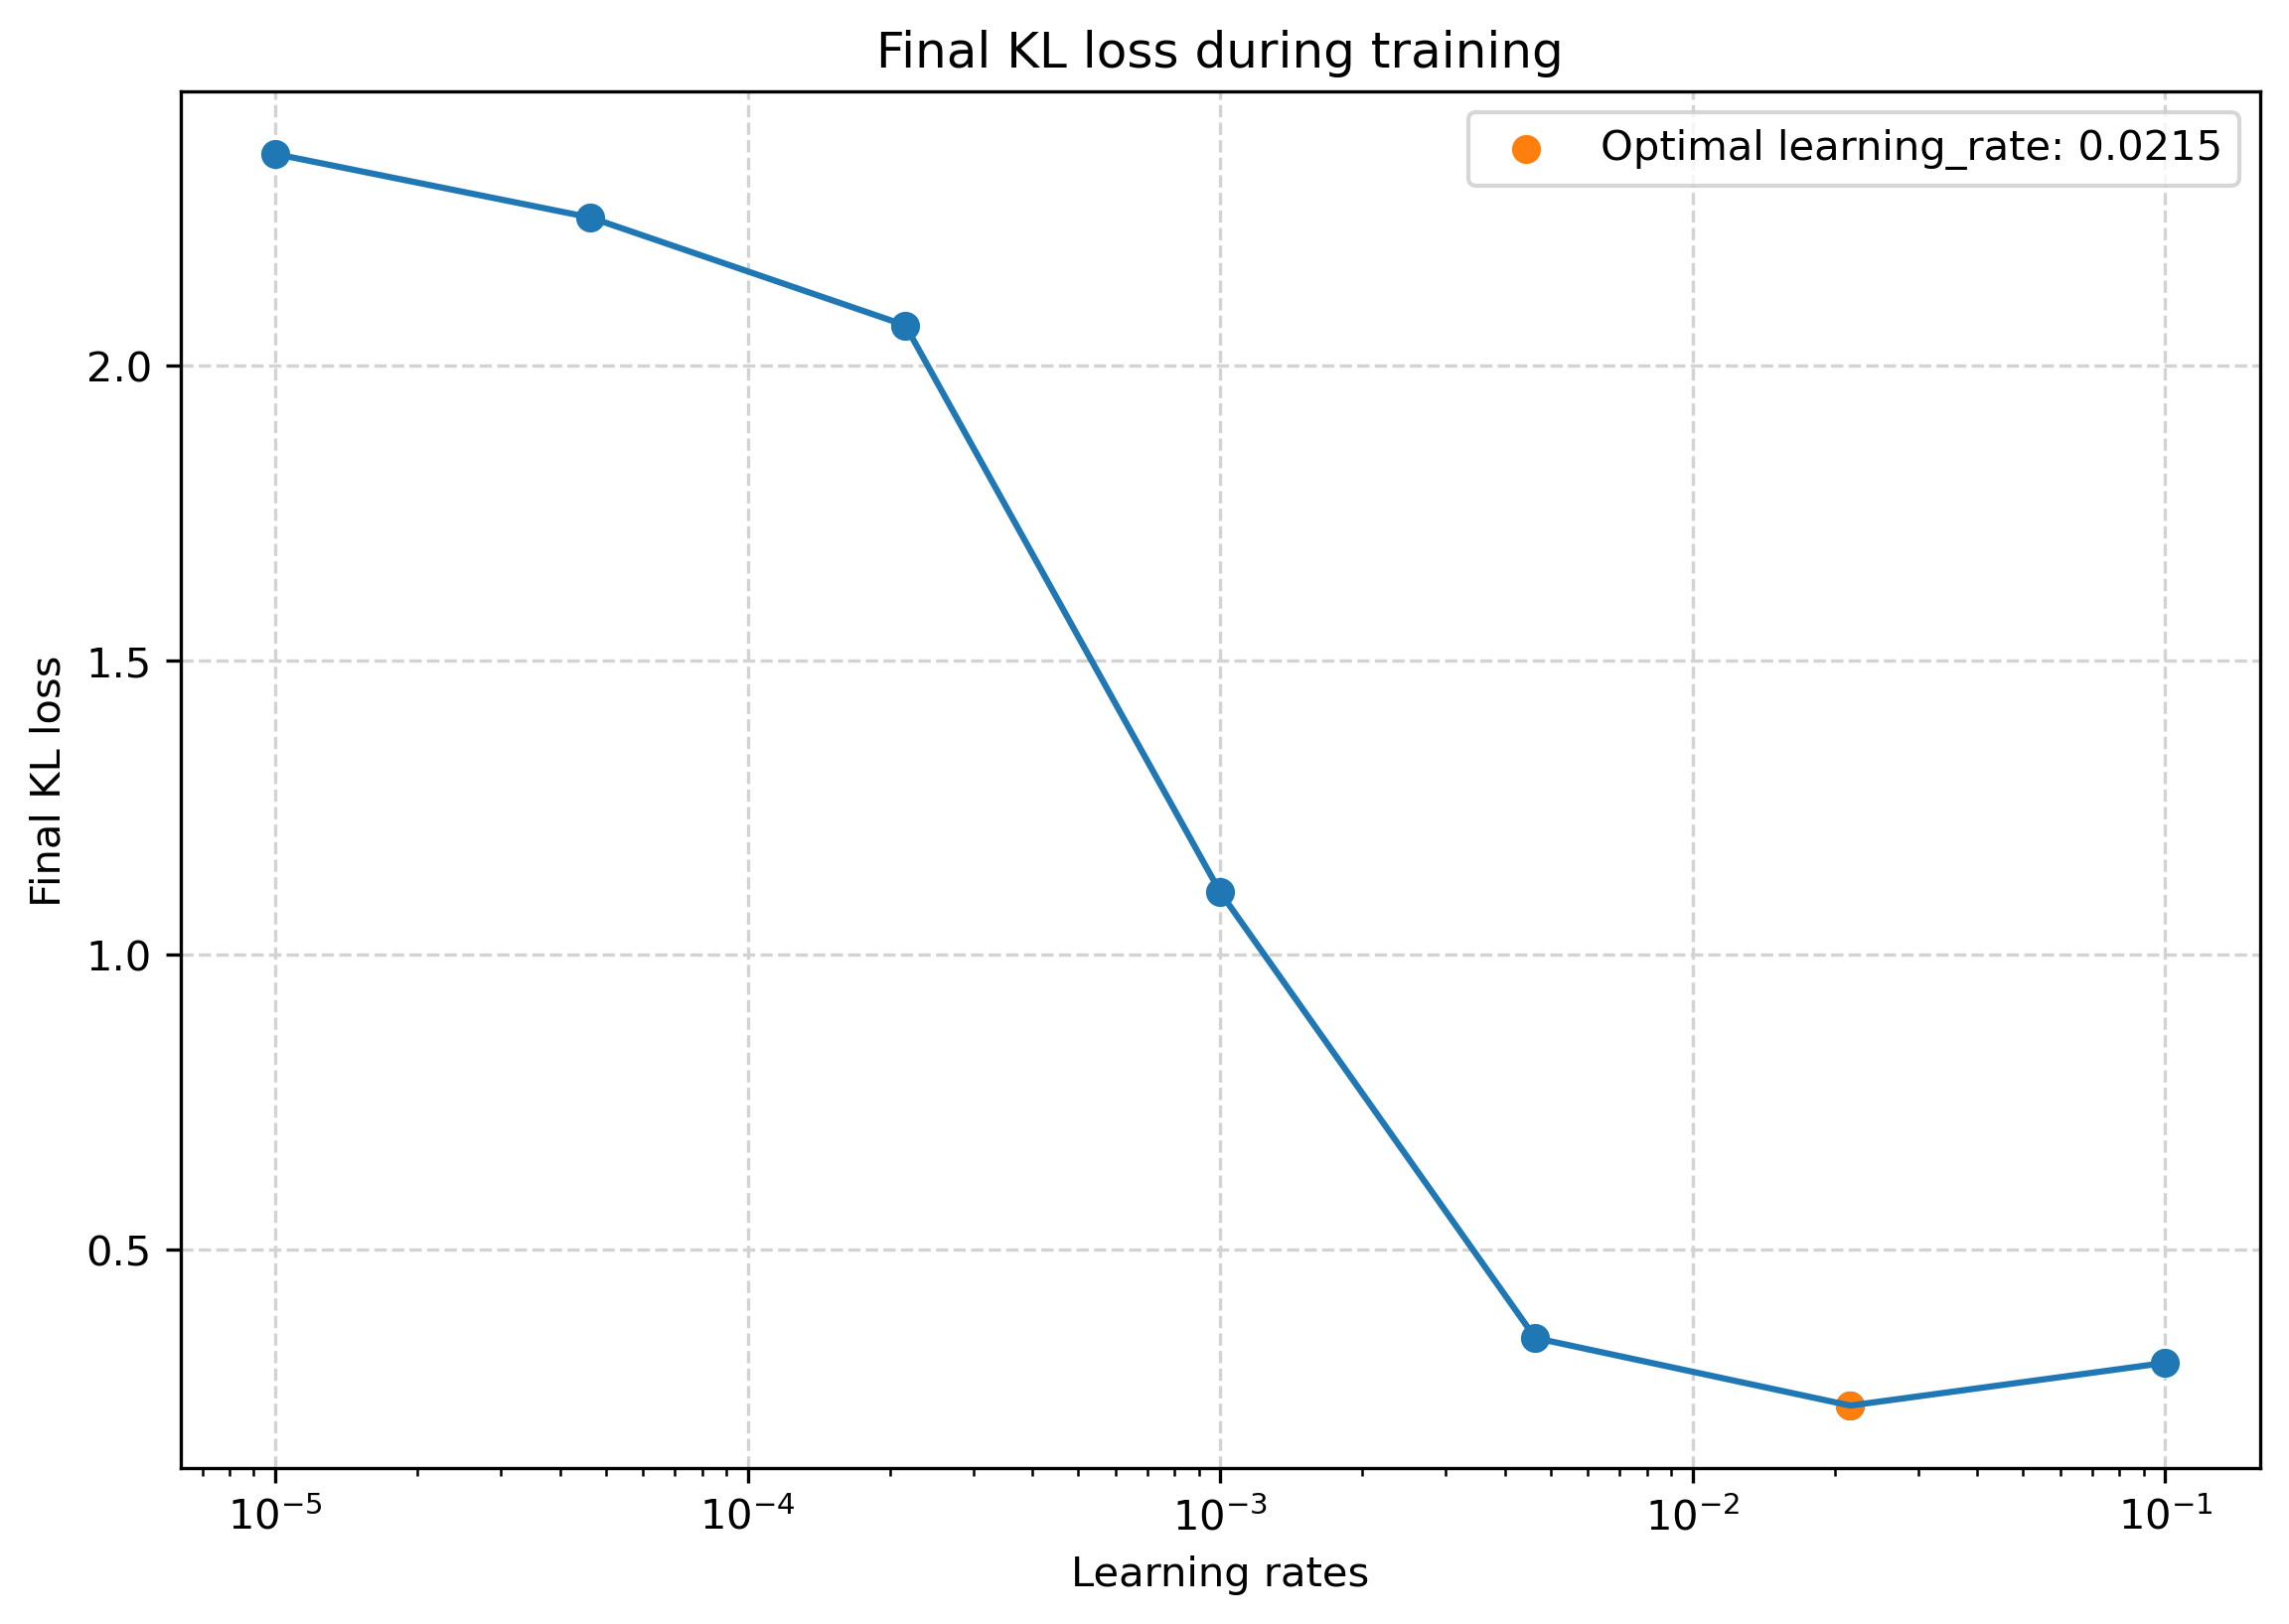

In [17]:
min_rate = learning_rates[np.argmin(losses)]
min_loss = losses[np.argmin(losses)]

plt.plot(learning_rates,losses)
plt.scatter(learning_rates, losses)
plt.scatter(min_rate, min_loss, label = f'Optimal learning_rate: {np.round(min_rate,4)}')

plt.title('Final KL loss during training')
plt.xlabel('Learning rates')
plt.ylabel('Final KL loss')
plt.xscale('log')
plt.legend()

Performing a grid search on the interval $[1\cdot 10^{-5}, 10^{-1}]$ with seven values, we observe that the loss curve plateaus for learning rates below $2.1544346\cdot 10^{-4}$; this is no surprise, since the learning rate is low meaning the model's weight updates are small, slowing model convergence to an optimum.

Then, the loss decreases rapidly in the window $[2.1544346\cdot 10^{-4}, 4.64158883\cdot10^{-3}]$, decreases less rapidly from $4.64158883\cdot10^{-3}$ to the $\textbf{optimal learning rate}$ of  $2.15443469\cdot10^{-2}$. This can be seen since with larger learning rates come larger weight updates, aiding model convergence.

Finally, we note that the loss increases at the last learning rate of $10^{-1}$. We see that the learning rate starts to become too high, causing the model to overshoot optimum weight values, leading to undesirable outcomes in terms of model convergence and consequently, performance.

#### 1.1.2

In [18]:
#Retraining the mlp with the optimal learning rate 
optimal_learning_rate = min_rate
batch_size = 128
epochs = 40

x = train_data_std
y = y_train
losses_train, losses_test, accuracy_train, accuracy_test = \
train_mlp(x, y, test_data_std, y_test,learning_rate = \
          optimal_learning_rate, batch_size = batch_size, epochs = epochs, scores = True)

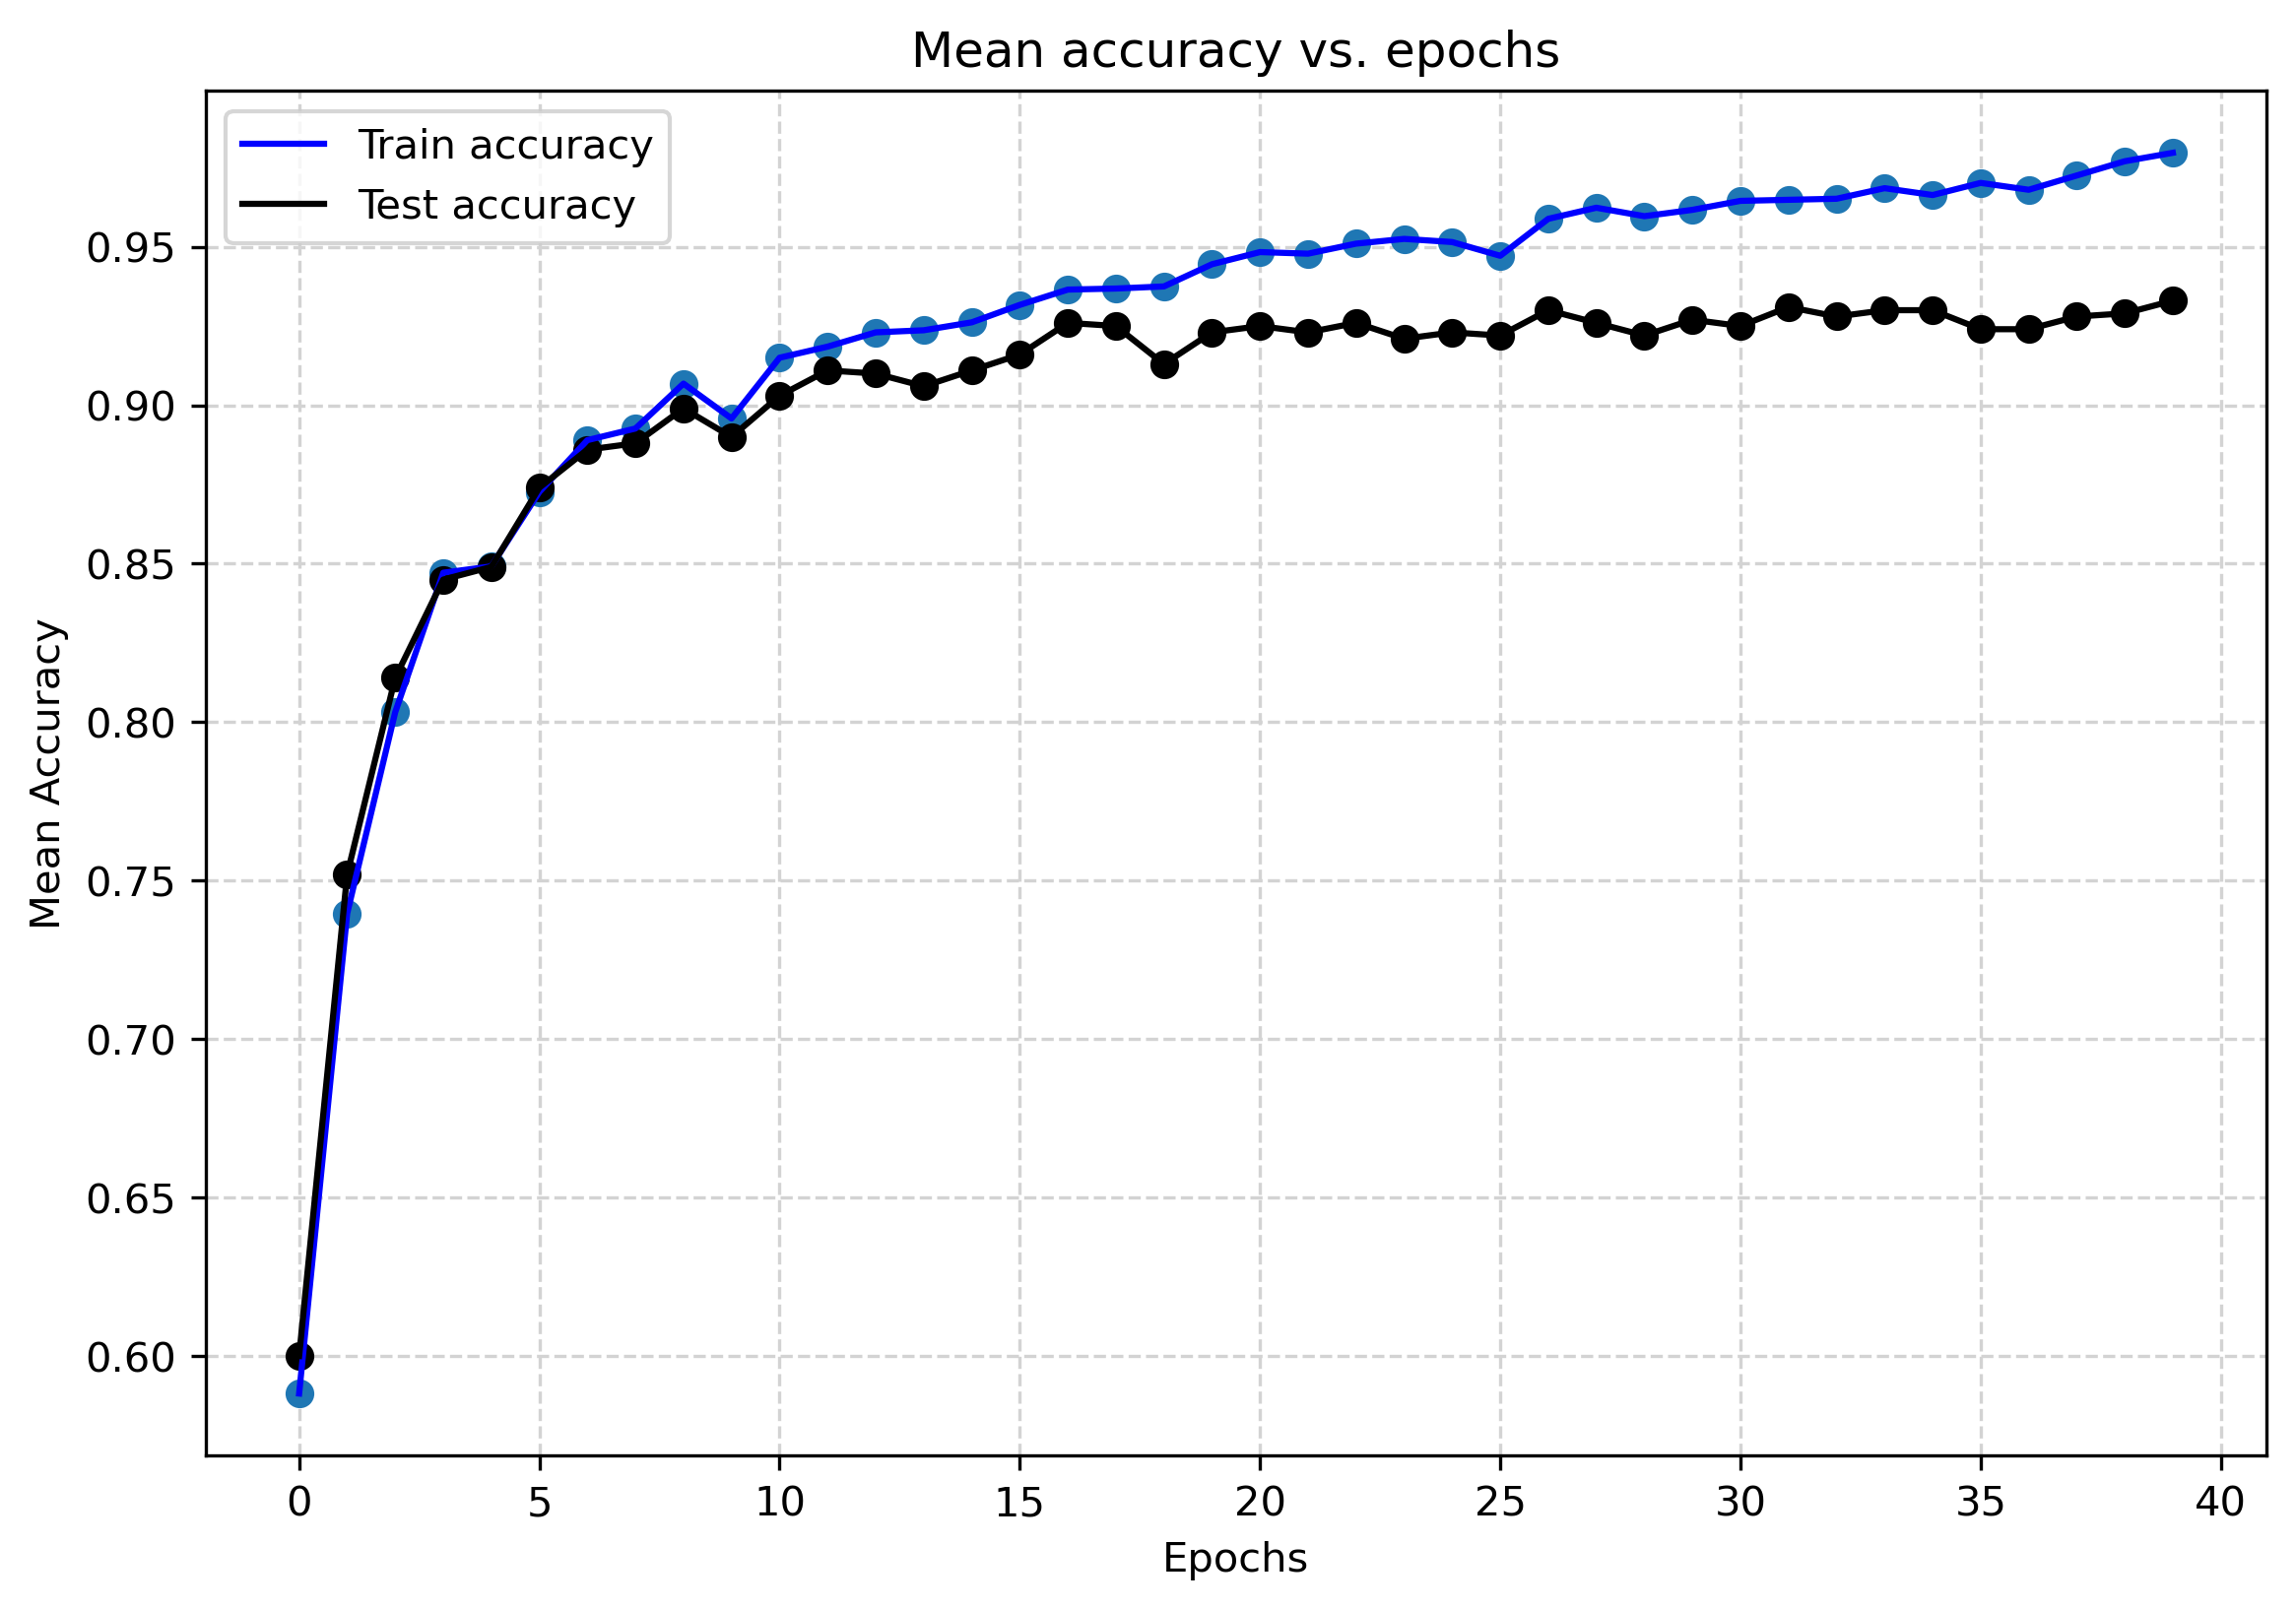

In [19]:
#Plotting accuracy scores
epoch_range = np.arange(epochs)

plt.plot(epoch_range,accuracy_train, label = 'Train accuracy', c = 'blue')
plt.plot(epoch_range,accuracy_test, label = 'Test accuracy', c = 'black')
plt.scatter(epoch_range,accuracy_train)
plt.scatter(epoch_range,accuracy_test, c = 'black')

plt.title('Mean accuracy vs. epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.show()

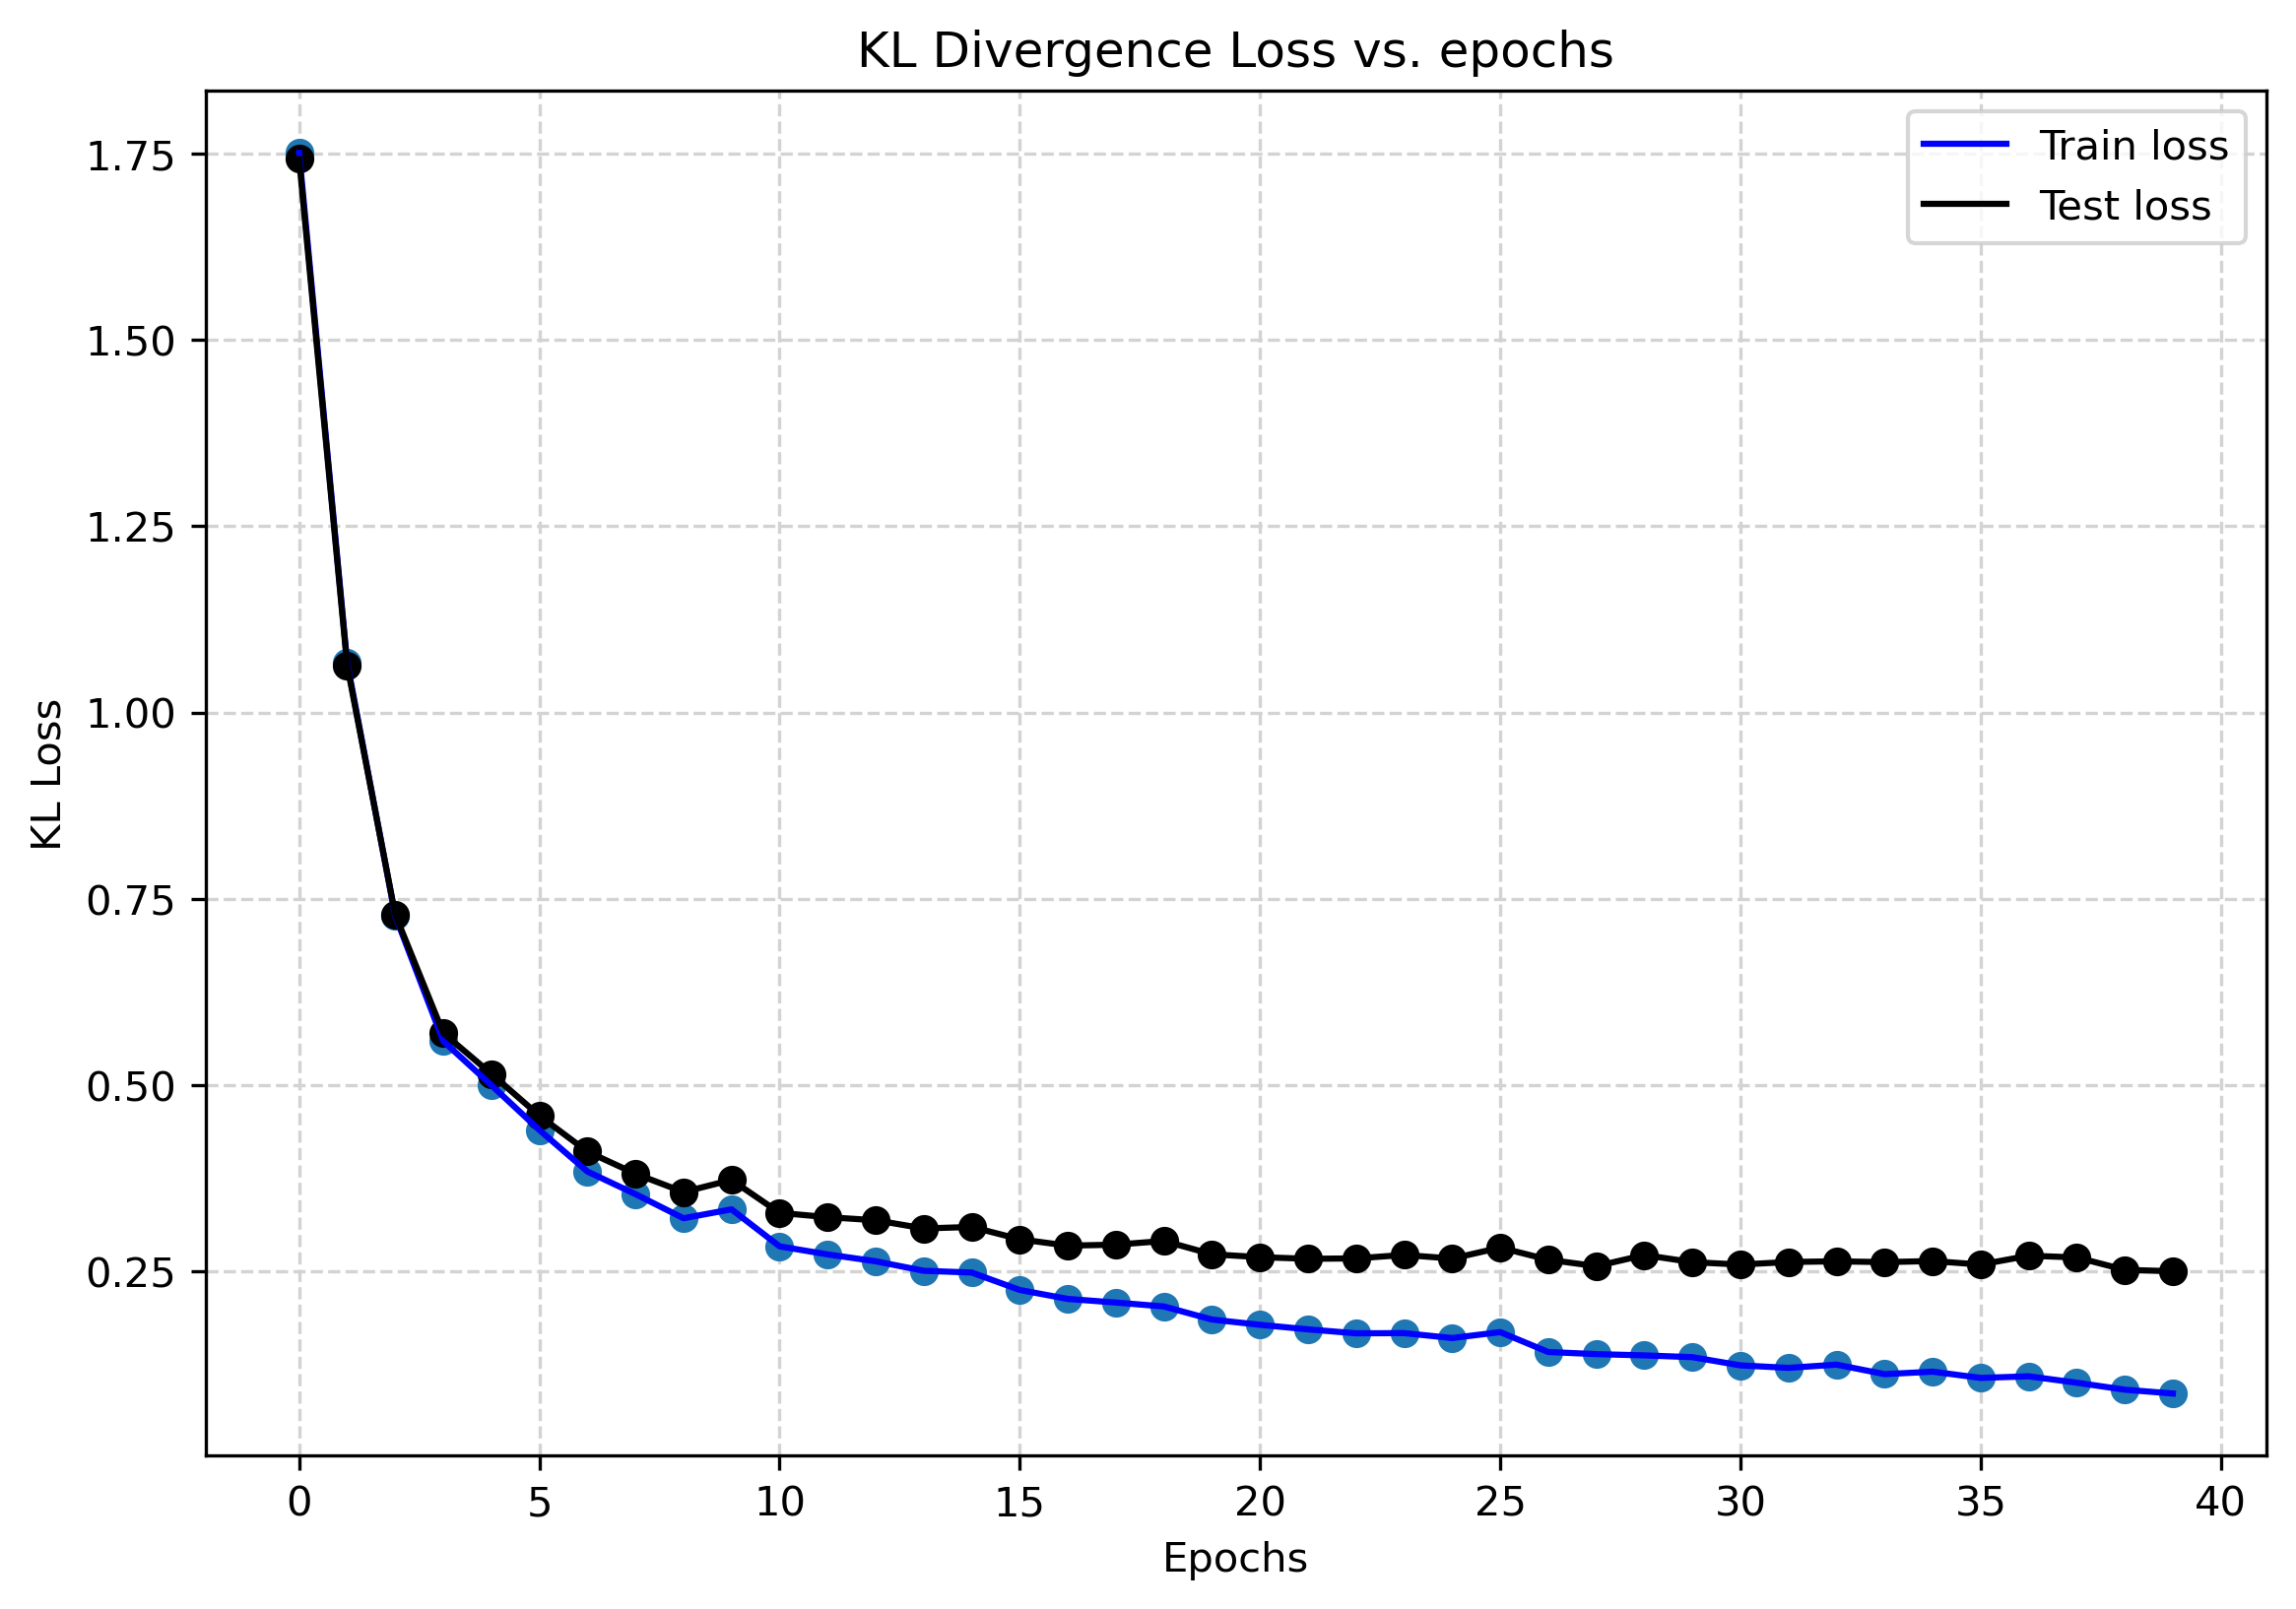

In [20]:
#Plotting Losses
plt.plot(epoch_range,losses_train, label = 'Train loss', c = 'blue')
plt.plot(epoch_range,losses_test, label = 'Test loss', c = 'black')
plt.scatter(epoch_range,losses_train)
plt.scatter(epoch_range,losses_test, c = 'black')
plt.legend()
plt.ylabel('KL Loss')
plt.xlabel('Epochs')
plt.title('KL Divergence Loss vs. epochs')
plt.show()

#### 1.1.3

We now train the mlp network with the same number of hidden layers, each having 50 neurons. More explicitly, it will have the following parameters: 

>Input layer -> first hidden layer:
>* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{784\times 50}$
>* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{50}$

>Hidden layer -> hidden layer:
>* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{50\times 50}$, $k=1, 2$
>* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{50}$, $k=1, 2$

>Hidden layer -> output layer:
>* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{50\times 10}$
>* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{10}$, 

In [17]:
def train_mlp_small_network(X_train, y_train, X_test, y_test, learning_rate = 0.01, batch_size = 128, epochs = 40, scores = False):
    """
    Train a small multilayer perceptron network using backpropagation on the given training data.

    Args:
    X_train (numpy.ndarray): The training data features.
    y_train (numpy.ndarray): The training data labels.
    X_test (numpy.ndarray): The test data features.
    y_test (numpy.ndarray): The test data labels.
    learning_rate (float): The learning rate to use for updating the model weights and biases during training. Defaults to 0.01.
    batch_size (int): The size of minibatches to use during training. Defaults to 128.
    epochs (int): The number of training epochs to run. Defaults to 40.
    scores (bool): Whether to also return the training and test accuracy scores over epochs. Defaults to False.

    Returns:
    If scores is False:
    Tuple: the learned weights and biases for the model (W0, b0, W1, b1, W2, b2, W3, b3) and the training losses over epochs.

    If scores is True:
    Tuple: the learned weights and biases for the model (W0, b0, W1, b1, W2, b2, W3, b3), the training and test losses over epochs, and the training and test accuracy scores over epochs.
    """
    
    
    #initialise weights
    
    N,d = train_data.shape
    
    var0 = 6. / (d+50)
    W0 =  np.random.uniform(-np.sqrt(var0), np.sqrt(var0), (d, 50) )
    b0 = np.zeros(50).reshape(1,-1)
    
    var1 = 6. / (50+50)
    W1 =  np.random.uniform(-np.sqrt(var1), np.sqrt(var1), (50, 50) )
    b1 = np.zeros(50).reshape(1,-1)

    var2 = 6. / (50+50)
    W2 =  np.random.uniform(-np.sqrt(var2), np.sqrt(var2), (50, 50) )
    b2 = np.zeros(50).reshape(1,-1)
    
    var3 = 6. / (50+10)
    W3 =  np.random.uniform(-np.sqrt(var3), np.sqrt(var3), (50, 10) )

    b3 = np.zeros(10).reshape(1,-1)
    
    losses_train = []
    losses_test = []
    accuracy_train = []
    accuracy_test = []
    
    for epoch in trange(epochs):
        #shuffle data
        p = np.random.permutation(N)
        X_train = X_train[p]
        y_train = y_train[p]
        
                
        batch_indices = np.array_split(np.arange(N), N/batch_size)
        
        num_iterations = len(batch_indices)
        for iteration in range(num_iterations):
            x_batch, y_batch = X_train[batch_indices[iteration]], y_train[batch_indices[iteration]]
            
            dW0, db0, dW1,db1, dW2, db2, dW3, db3 =\
            backpropagate(x_batch, y_batch, W0, b0, W1,b1, W2, b2, W3, b3)
        
            W0 -= learning_rate * dW0 
            b0 -= learning_rate * db0 
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2 
            b2 -= learning_rate * db2 
            W3 -= learning_rate * dW3 
            b3 -= learning_rate * db3
            
        #compute KL divergence loss per epoch
        
        loss_train = np.mean(KL_loss(X_train, y_train, W0, b0, W1,b1, W2, b2, W3, b3))
        losses_train.append(loss_train)
        losses_test.append(np.mean(KL_loss(X_test, y_test, W0, b0, W1,b1, W2, b2, W3, b3)))
        
        #compute mlp predictions
        
        y_pred_train = [np.argmax(mlp(X_train[i], W0, b0, W1,b1, W2, b2, W3, b3))\
                 for i in range(X_train.shape[0])]
        y_pred_test = [np.argmax(mlp(X_test[i], W0, b0, W1,b1, W2, b2, W3, b3))\
                 for i in range(X_test.shape[0])]
        
        #compute model mean accuracy scores
        
        accuracy_train.append(len(y_train[y_pred_train == y_train])/len(y_train))
        accuracy_test.append(len(y_test[y_pred_test == y_test])/len(y_test))
        
    if scores == True:
        return losses_train, losses_test, accuracy_train, accuracy_test
        
    return W0, b0, W1,b1, W2, b2, W3, b3, losses_train

In [22]:
#Retraining the mlp with the optimal learning rate 
optimal_learning_rate = min_rate
batch_size = 128
epochs = 40

losses_train_50, losses_test_50, accuracy_train_50, accuracy_test_50 = \
train_mlp_small_network(train_data_std, y_train, test_data_std, y_test,learning_rate =\
          optimal_learning_rate, batch_size = batch_size, epochs = epochs, scores = True)

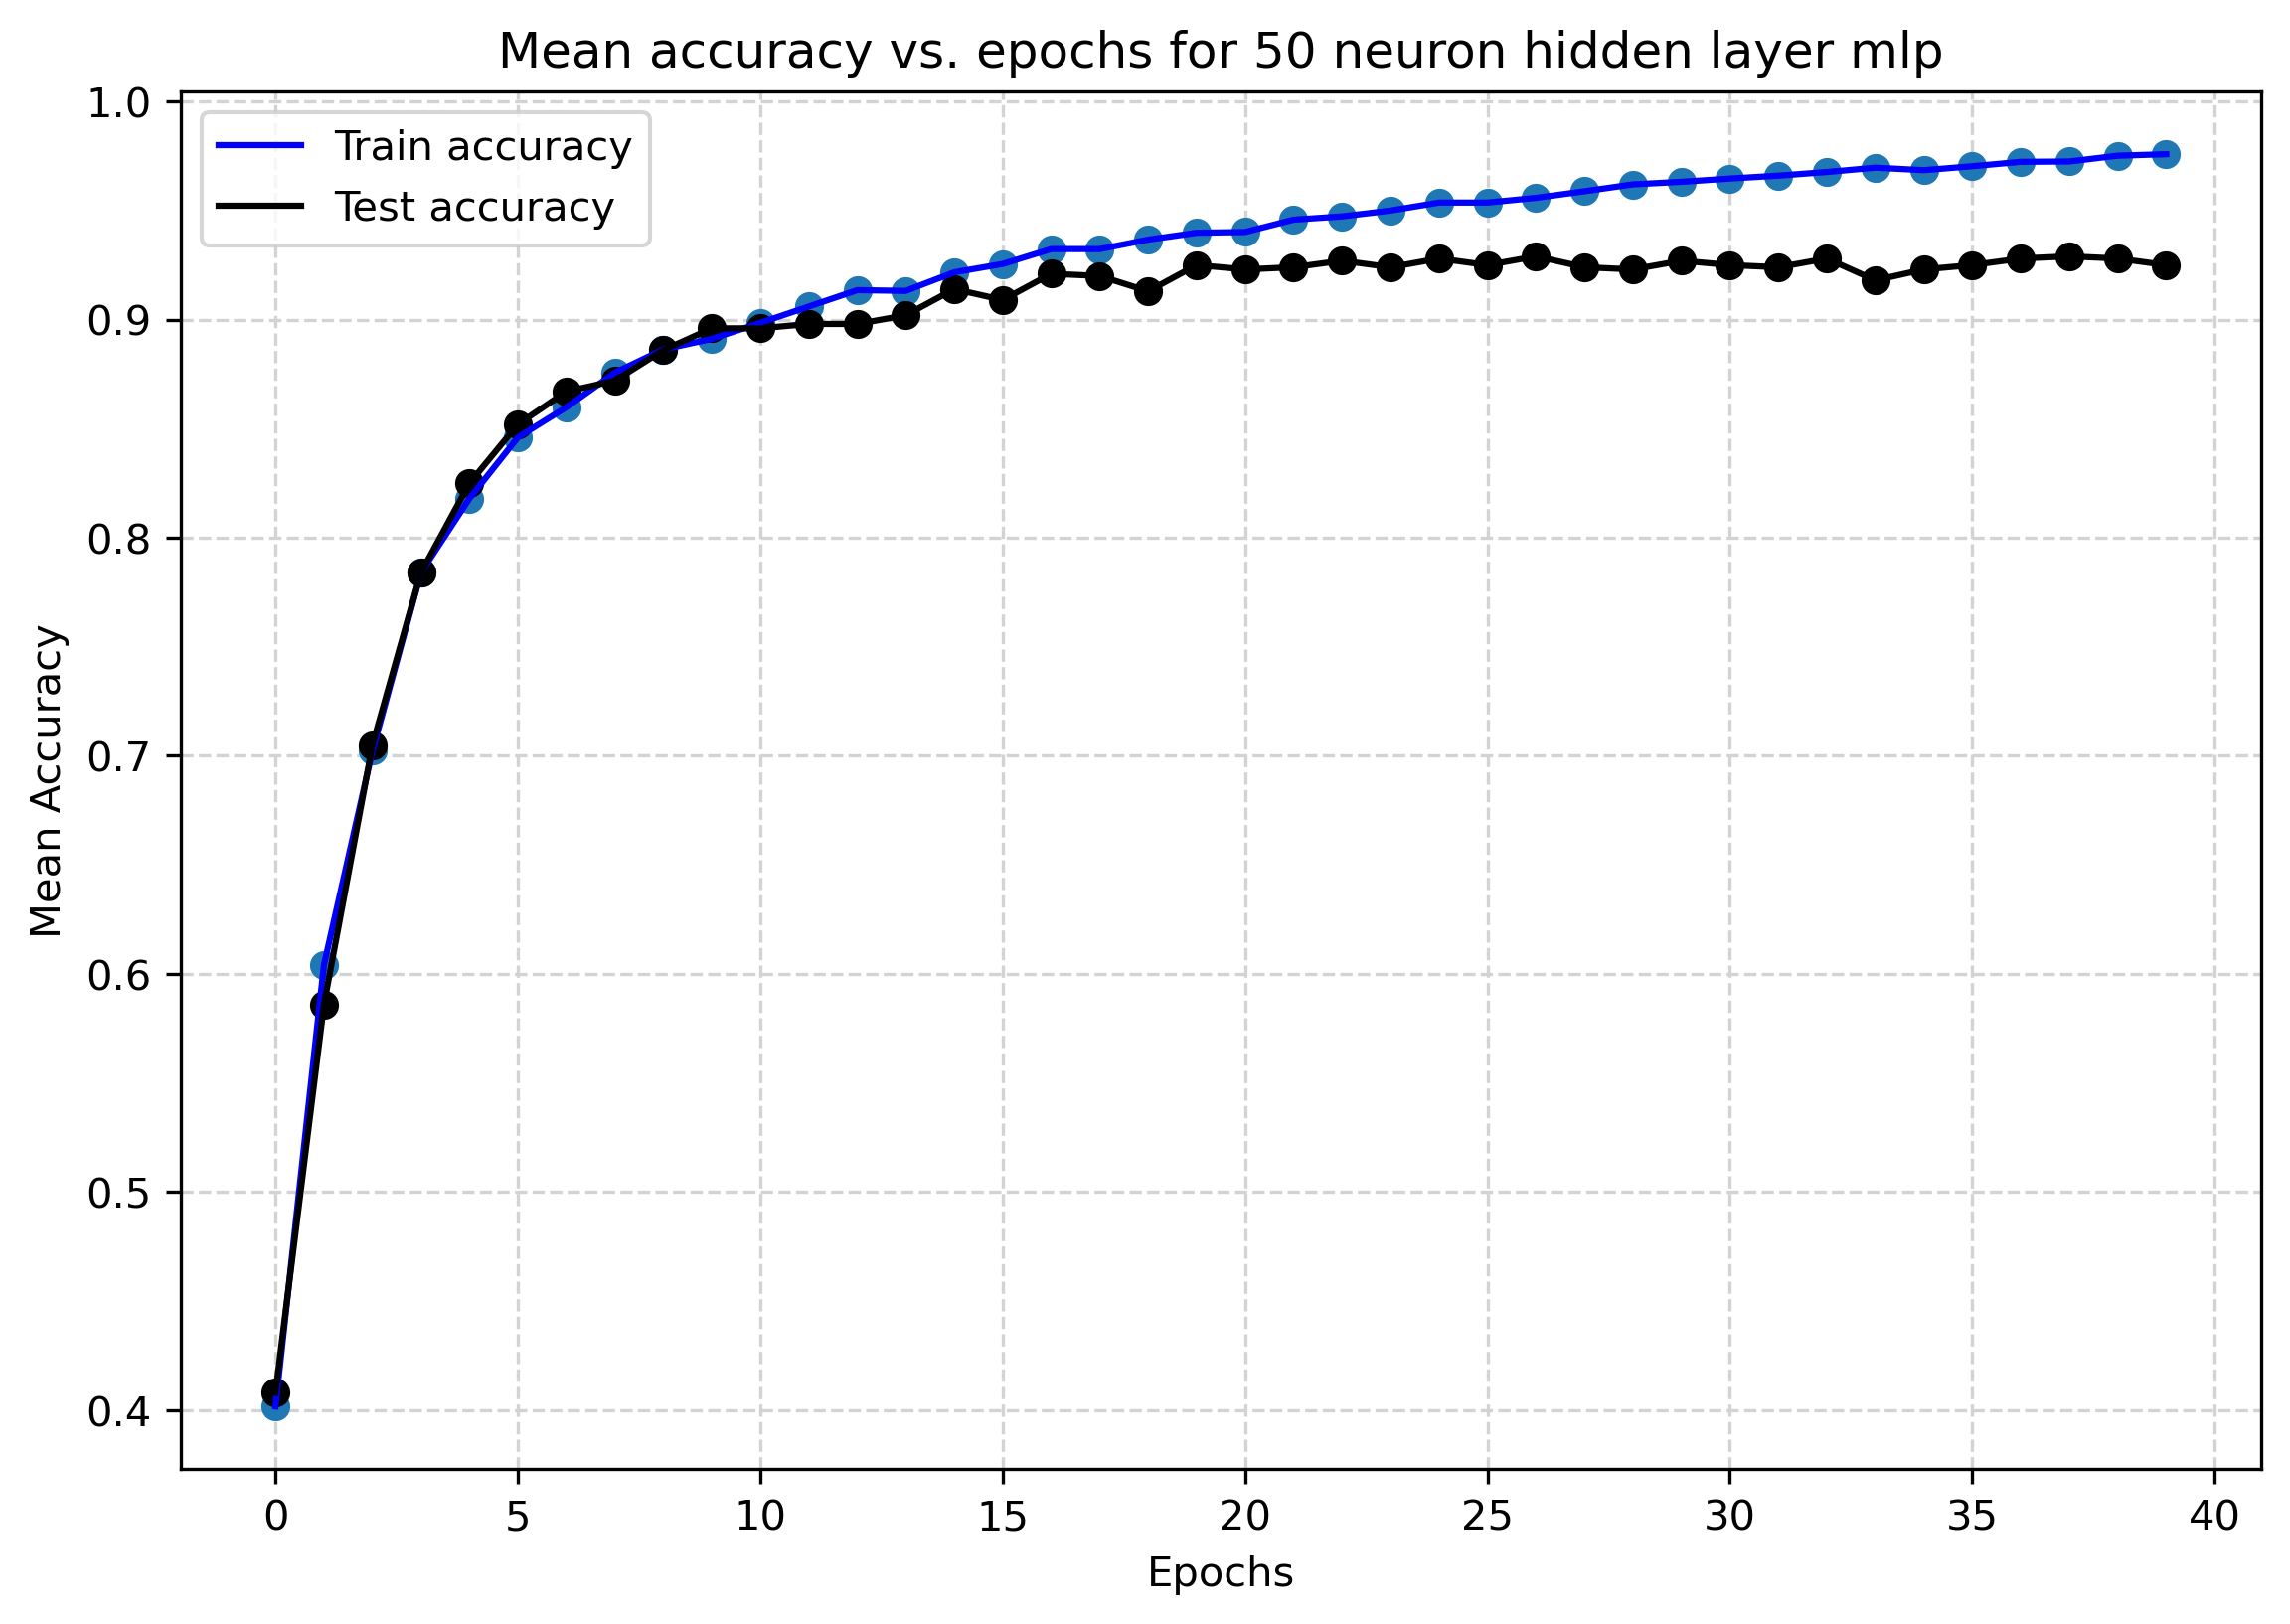

In [23]:
#Plotting accuracy scores
epoch_range = np.arange(40)
plt.plot(epoch_range,accuracy_train_50, label = 'Train accuracy', c = 'blue')
plt.plot(epoch_range,accuracy_test_50, label = 'Test accuracy', c = 'black')
plt.scatter(epoch_range,accuracy_train_50)
plt.scatter(epoch_range,accuracy_test_50, c = 'black')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')

plt.title('Mean accuracy vs. epochs for 50 neuron hidden layer mlp')
plt.show()

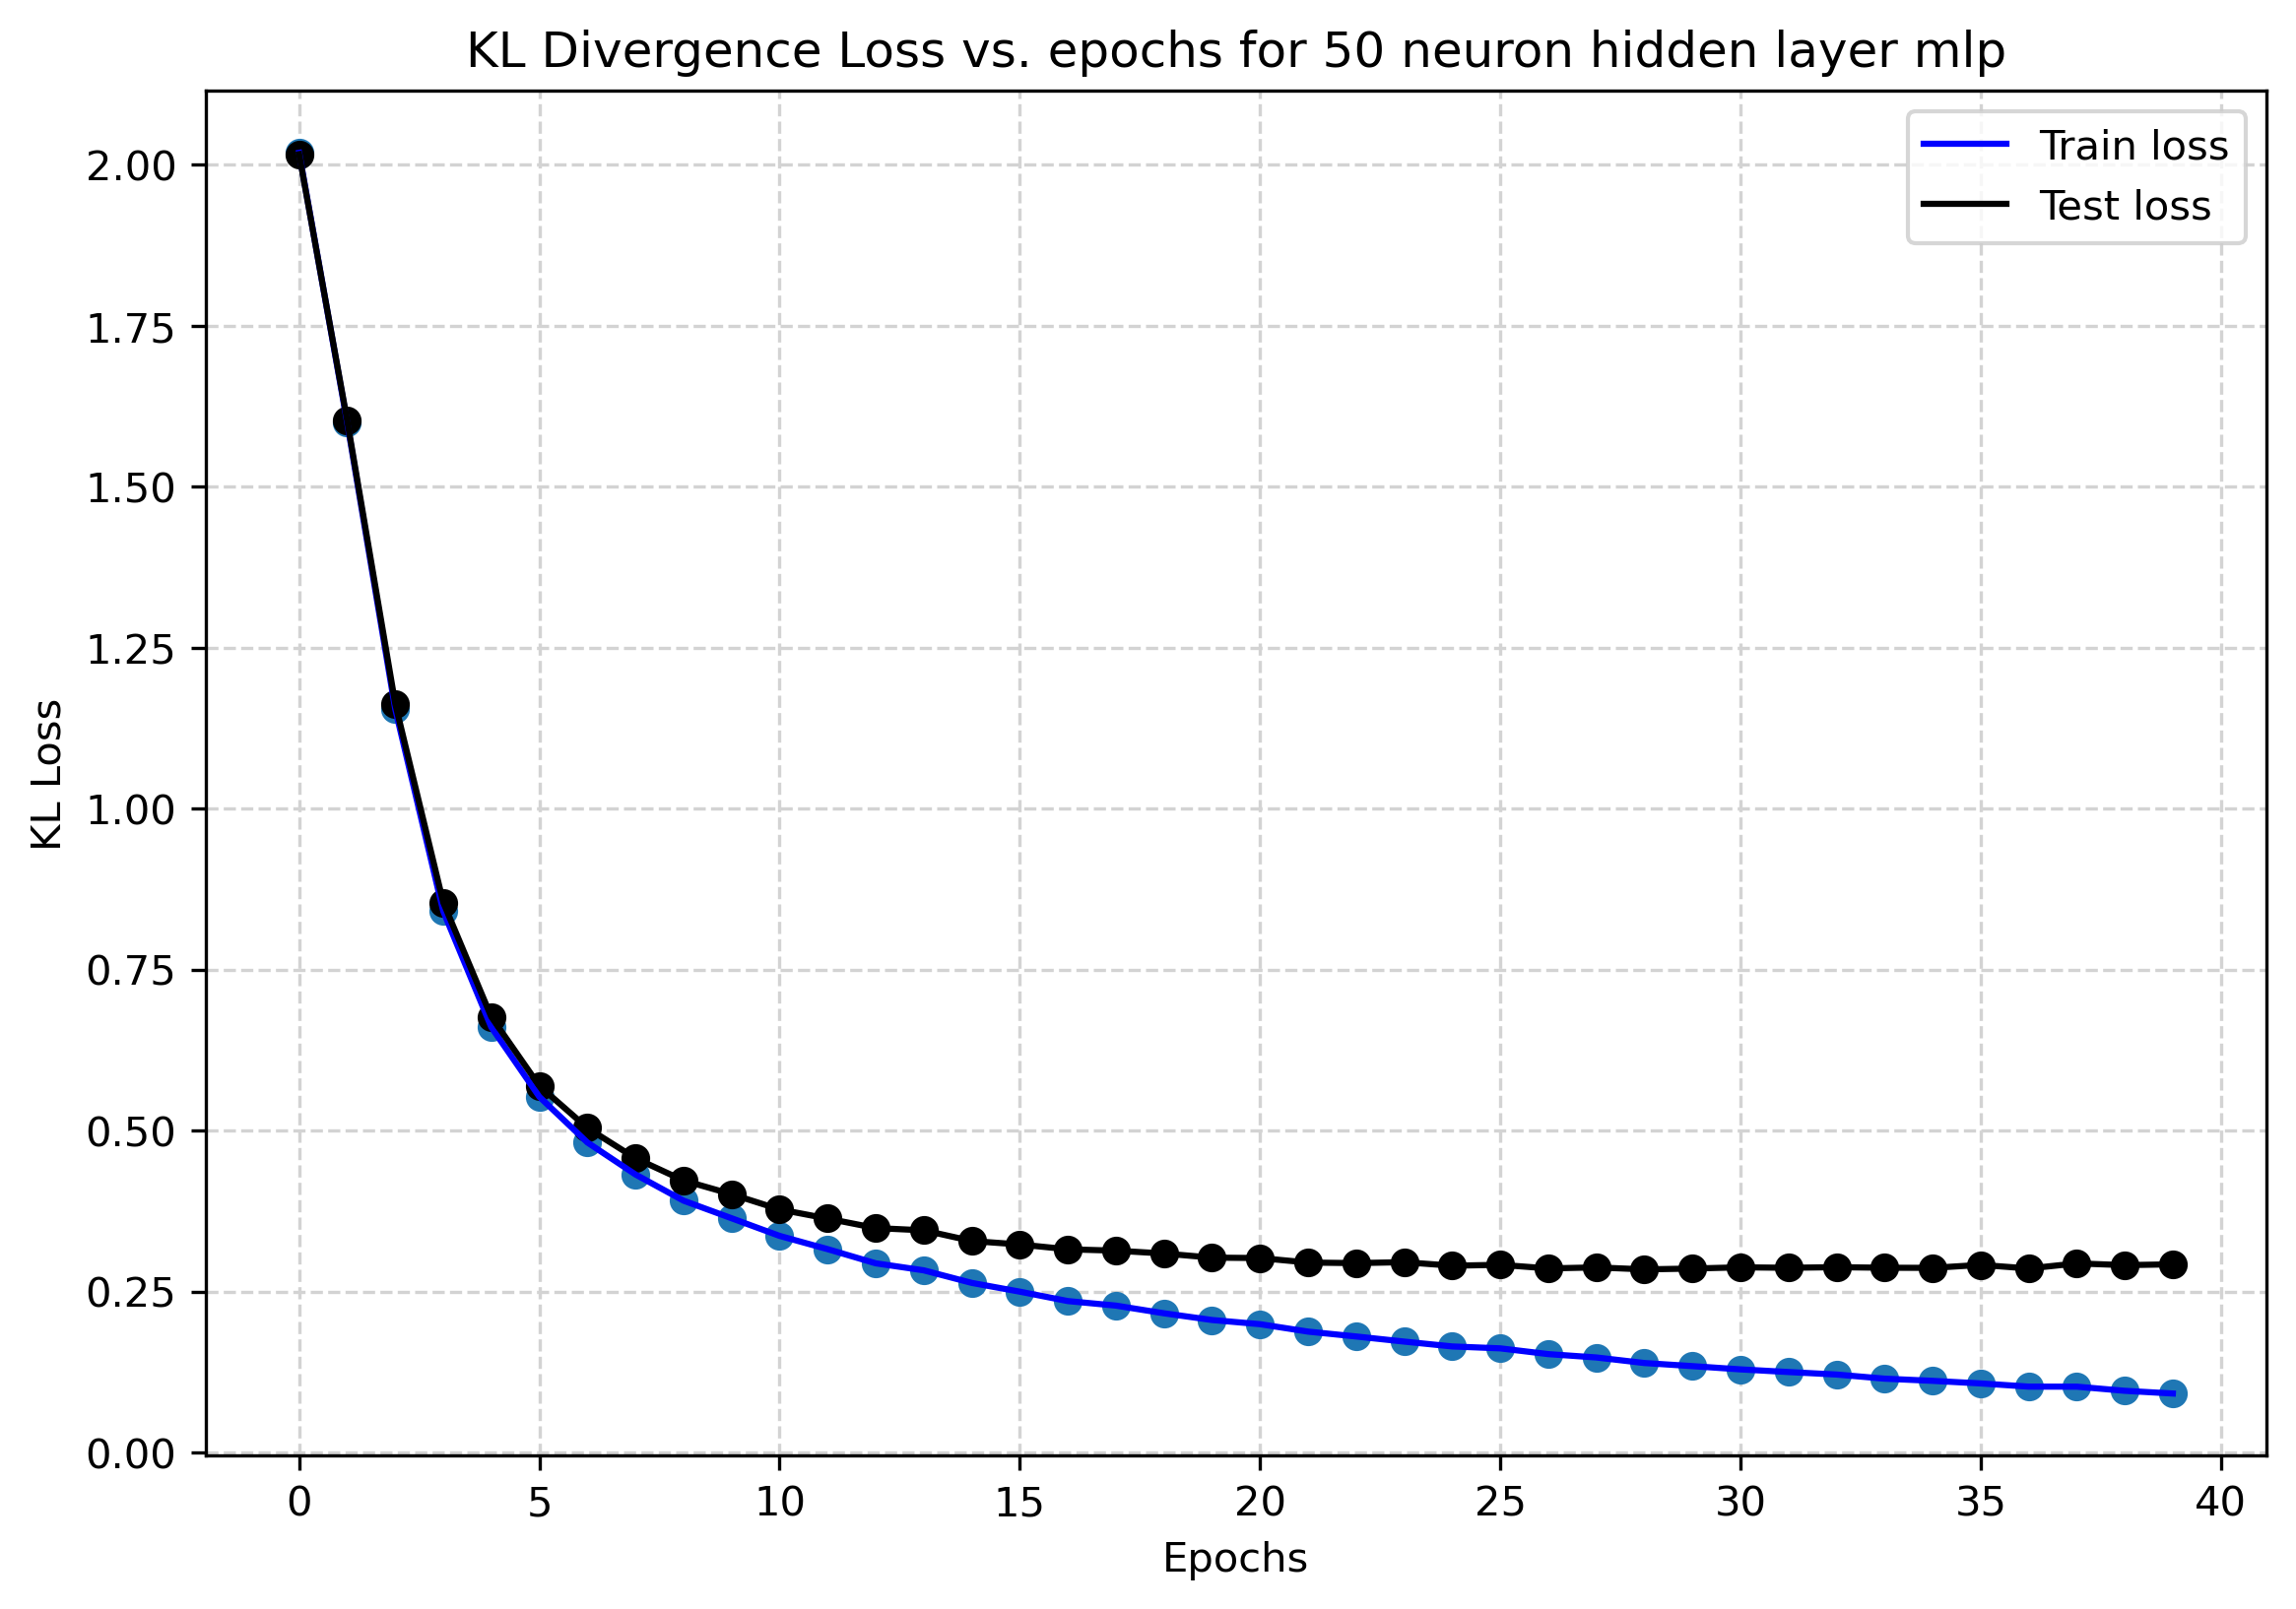

In [24]:
#Plotting Losses
plt.plot(epoch_range,losses_train_50, label = 'Train loss', c = 'blue')
plt.plot(epoch_range,losses_test_50, label = 'Test loss', c = 'black')
plt.scatter(epoch_range,losses_train_50)
plt.scatter(epoch_range,losses_test_50, c = 'black')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('KL Loss')
plt.title('KL Divergence Loss vs. epochs for 50 neuron hidden layer mlp')
plt.show()

We evaluate the accuracy on both the training and test sets and compare it to the accuracies of the MLP of task 1.1.2.

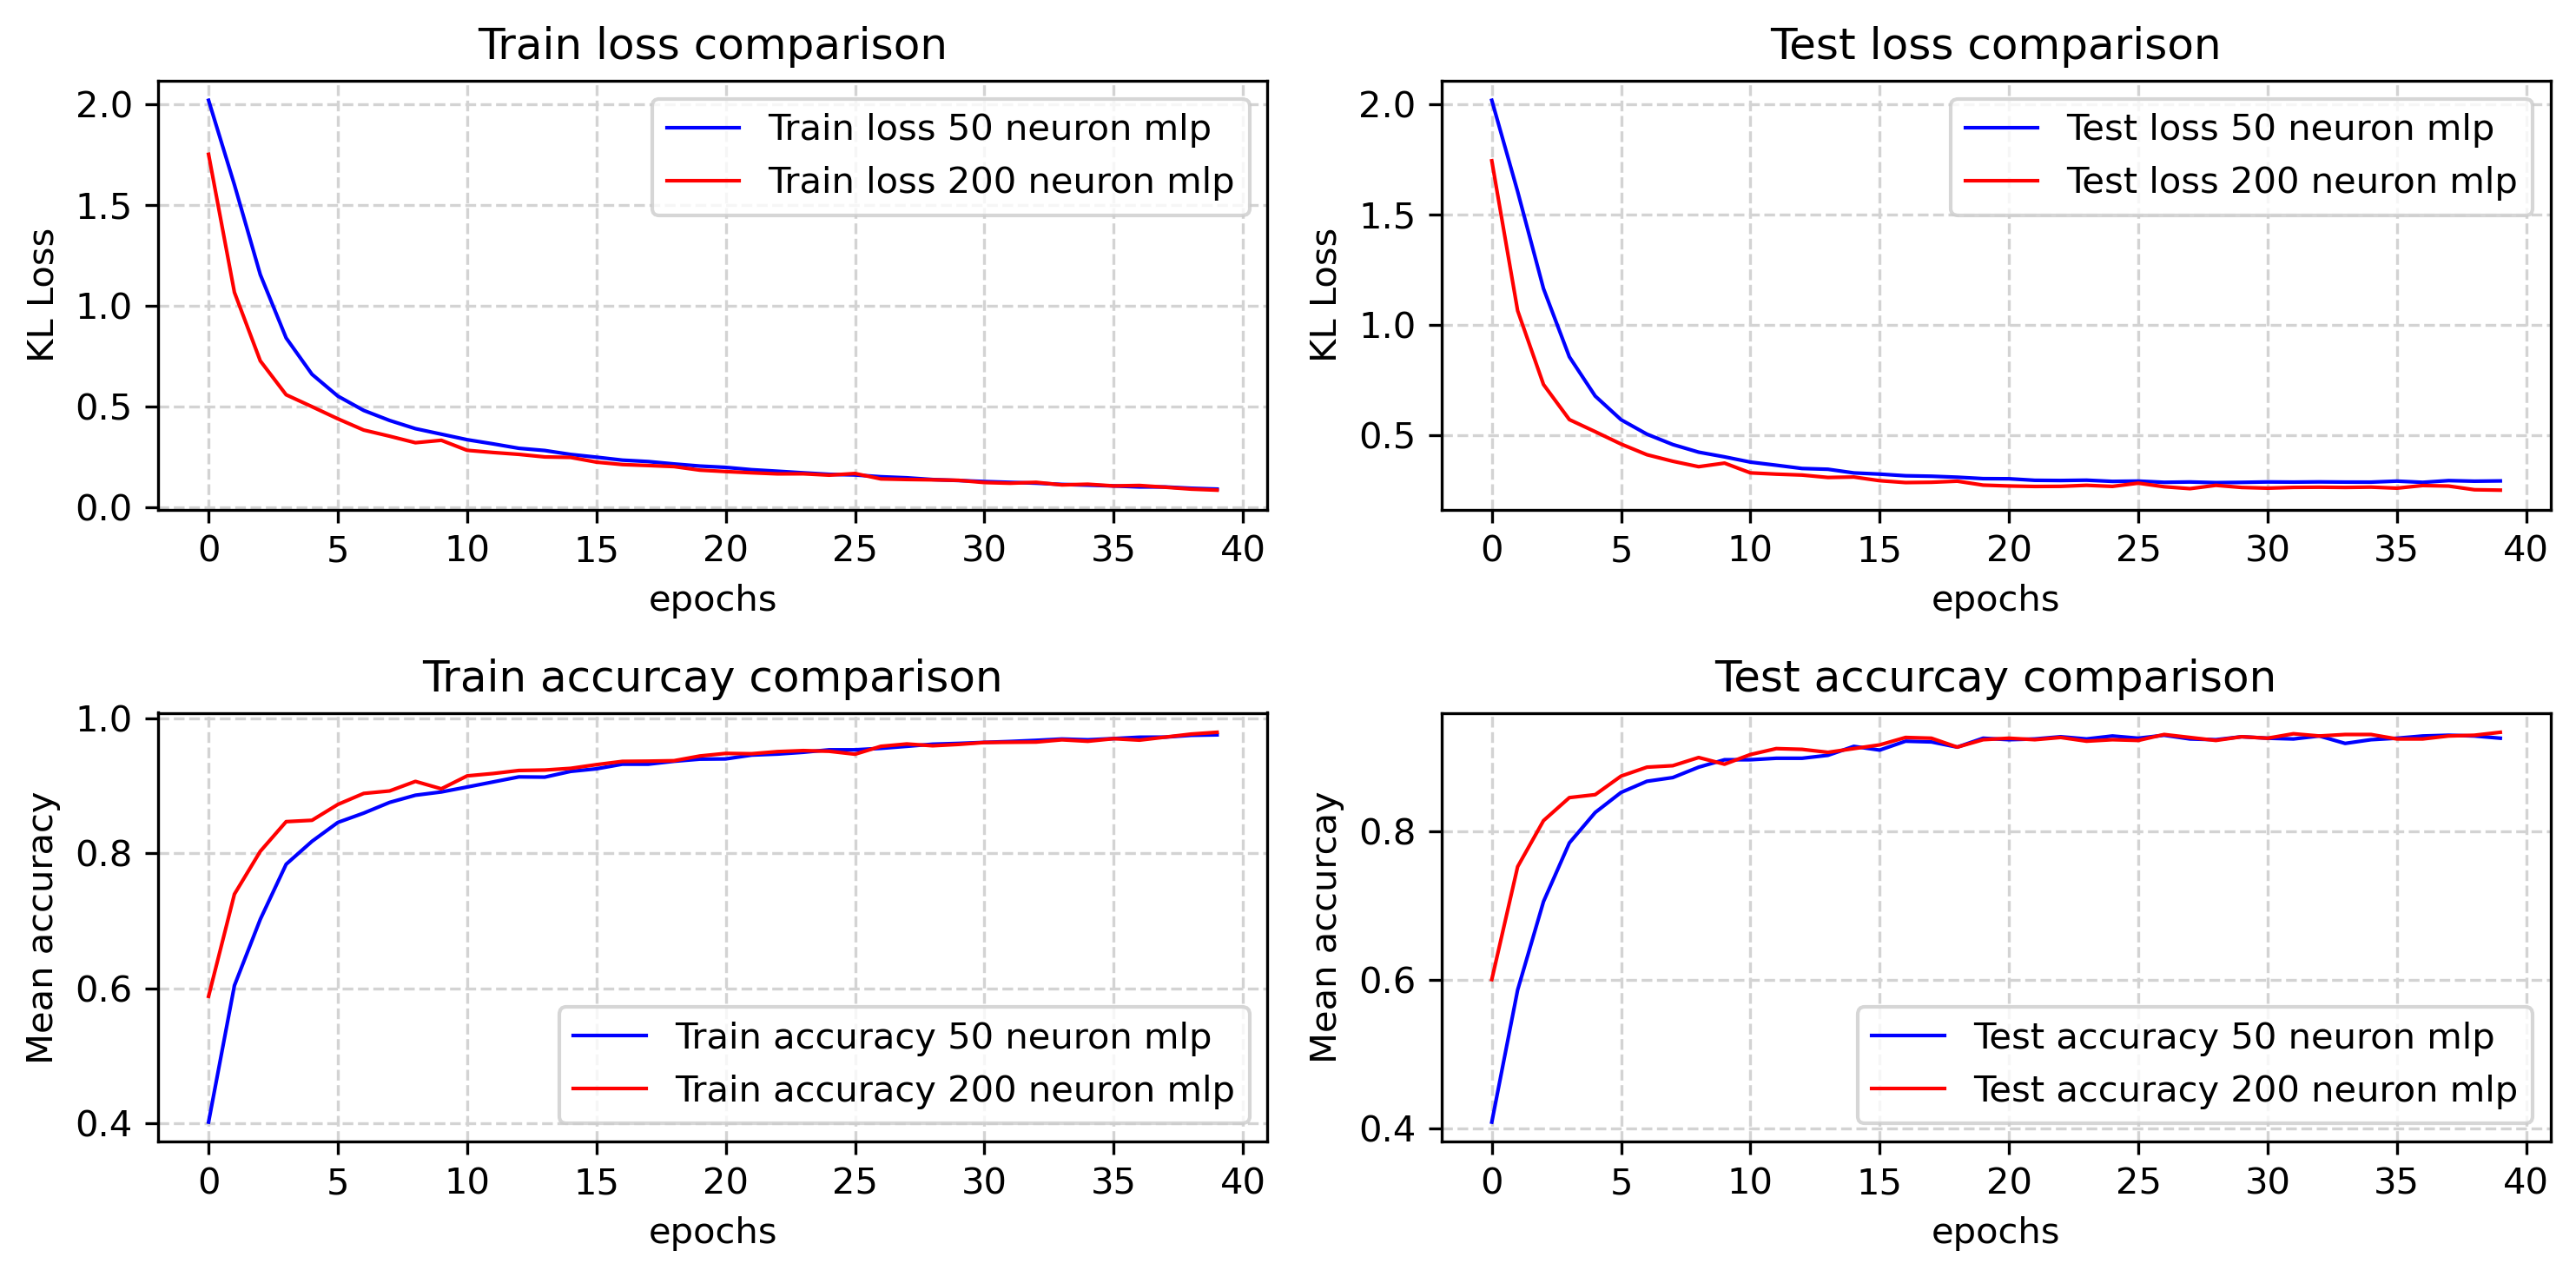

In [25]:
#Compaing accuracies and final losses between 50 and 200 neuron mlp's

nrow = 2; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,5))

axs[0,0].plot(epoch_range,losses_train_50, label = 'Train loss 50 neuron mlp', c = 'blue', linewidth = 1)
axs[0,0].plot(epoch_range,losses_train, label = 'Train loss 200 neuron mlp', c = 'red', linewidth = 1)
axs[0,0].legend()
axs[0,0].set_xlabel('epochs')
axs[0,0].set_ylabel('KL Loss')
axs[0,0].set_title('Train loss comparison')


axs[0,1].plot(epoch_range,losses_test_50, label = 'Test loss 50 neuron mlp', c = 'blue', linewidth = 1)
axs[0,1].plot(epoch_range,losses_test, label = 'Test loss 200 neuron mlp', c = 'red', linewidth = 1)
axs[0,1].legend()
axs[0,1].set_xlabel('epochs')
axs[0,1].set_ylabel('KL Loss')
axs[0,1].set_title('Test loss comparison')

axs[1,0].plot(epoch_range,accuracy_train_50, label = 'Train accuracy 50 neuron mlp', c = 'blue', linewidth = 1)
axs[1,0].plot(epoch_range,accuracy_train, label = 'Train accuracy 200 neuron mlp', c = 'red', linewidth = 1)
axs[1,0].legend()
axs[1,0].set_xlabel('epochs')
axs[1,0].set_ylabel('Mean accuracy')
axs[1,0].set_title('Train accurcay comparison')


axs[1,1].plot(epoch_range,accuracy_test_50, label = 'Test accuracy 50 neuron mlp', c = 'blue', linewidth = 1)
axs[1,1].plot(epoch_range,accuracy_test, label = 'Test accuracy 200 neuron mlp', c = 'red', linewidth = 1)
axs[1,1].legend()
axs[1,1].set_xlabel('epochs')
axs[1,1].set_ylabel('Mean accurcay')
axs[1,1].set_title('Test accurcay comparison')


fig.tight_layout()

Overfitting is present regardless, as the test accuracy and loss curves for both mlp's are lower and higher respectively than their train counterparts as can be seen in the plots in 1.1.2 and 1.1.3. However, from the above plot, as the number of epochs increases to 40, we notice that in all cases, the accuracies and final losses between the two architectures converge to the same values.  This suggests that the overfitting caused by both models is similar. Finally note that the 200 neuron mlp converges faster to the optimum weight values as in the curves above, the accuracies are higher and the losses smaller in both train and test data.

#### 1.1.4

We implement a dropout with rate 0.2 at each hidden layer and scale the
output of each neuron in the hidden layers to compensate for the dropout during training. More precisely, for each weight matrix $W^k$, mapping neurons in layer $k$ to $k+1$, we apply the bernoulli mask to obtain:

$$W^k \leftarrow W^k \cdot \text{diag}([z_{k,j}]^{n_k}_{j=1})\\
z_{k,j}^{n_k}\sim \text{Bernoulli}(p_k), \quad k = 1, \cdots, L.$$

Since each hidden layer has $200$ neurons, the activations will be scaled by a factor of $\frac{1}{0.8}$ to compensate for the smaller effective network size during training.

In [18]:
def mlp_dropout(x, W0, b0, W1,b1, W2, b2, W3, b3, dropout_rate, β=1):
    
    """
    Applies a multi-layer perceptron (MLP) with dropout regularization to the input data.

    Args:
        x (np.ndarray): K x N array of input data,\
        where K is the number of features and N is the number of samples.
        W0, W1, W2, W3 (np.ndarray): weights for each layer of the MLP.
        b0, b1, b2, b3 (np.ndarray): biases for each layer of the MLP.
        dropout_rate (float): the probability of setting a neuron to zero during training.
        β (float): scaling factor for the softplus activation function (default=1).

    Returns:
        np.ndarray: K x 10 array of softmax probabilities for each class.
    """
    
    #input layer
    
    a1 = dense(x, W0, b0)
    h1 =  softplus(a1, β)/(1-dropout_rate)
    
    #hidden layers
    
    a2 = dense(h1, W1, b1)
    h2 =  softplus(a2, β)/(1-dropout_rate)
    
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3, β)/(1-dropout_rate)
    

    #pre-softmax output

    a4 = dense(h3, W3, b3)
    
    return softmax(a4)

In [19]:
def backpropagate_dropout(x_batch, y_batch, W0, b0, W1,b1, W2, b2, W3, b3, dropout_rate = 0.2, β = 1):
    """
    Perform backpropagation on a neural network with dropout regularization.

    Args:
        x_batch (numpy.ndarray): Input data, of shape (batch_size, input_dim).
        y_batch (numpy.ndarray): Label data, of shape (batch_size, num_classes).
        W0 (numpy.ndarray): Weight matrix for the input layer, of shape (input_dim, hidden_dim_1).
        b0 (numpy.ndarray): Bias vector for the input layer, of shape (hidden_dim_1,).
        W1 (numpy.ndarray): Weight matrix for the first hidden layer, of shape (hidden_dim_1, hidden_dim_2).
        b1 (numpy.ndarray): Bias vector for the first hidden layer, of shape (hidden_dim_2,).
        W2 (numpy.ndarray): Weight matrix for the second hidden layer, of shape (hidden_dim_2, hidden_dim_3).
        b2 (numpy.ndarray): Bias vector for the second hidden layer, of shape (hidden_dim_3,).
        W3 (numpy.ndarray): Weight matrix for the output layer, of shape (hidden_dim_3, num_classes).
        b3 (numpy.ndarray): Bias vector for the output layer, of shape (num_classes,).
        dropout_rate (float): Probability of dropping out a neuron during training.
        β (float): Parameter for the softplus activation function.

    Returns:
        Tuple of gradients for each weight and bias parameter,\
        in the order dW0, db0, dW1, db1, dW2, db2, dW3, db3.
    """
    
    #Apply Bernoulli mask to weights
    
    z_ber_1 = np.random.binomial(1, 1-dropout_rate, size = W1.shape[0]).reshape(-1,1)
    z_ber_2 = np.random.binomial(1, 1-dropout_rate, size = W2.shape[0]).reshape(-1,1)
    z_ber_3 = np.random.binomial(1, 1-dropout_rate, size = W3.shape[0]).reshape(-1,1)
    
    W1_masked = z_ber_1 * W1/(1-dropout_rate)
    W2_masked = z_ber_2 * W2/(1-dropout_rate)
    W3_masked = z_ber_3 * W3/(1-dropout_rate)
            
    #rescale network activations to compensate for dropout
        
    a1 = dense(x_batch, W0, b0)
    h1 =  softplus(a1, β)
        
    a2 = dense(h1, W1_masked, b1)
    h2 =  softplus(a2, β)
    
    a3 = dense(h2, W2_masked, b2)
    h3 = softplus(a3, β)
    

    #pre-softmax output

    a4 = dense(h3, W3_masked, b3)

    #Backward pass
    
    #one-hot encoding of labels
    y_batch_prob = one_hot_encode(y_batch)
        
    
    delta4 = softmax(a4) - y_batch_prob  
    
    
    #print(f'a3 size: {a3.shape}')
    
    #print(f'mat prod size {delta4.shape}')
    
    delta3 = activation_derivative(a3)*(delta4@W3_masked.T)
    delta2 = activation_derivative(a2)*(delta3@W2_masked.T) 
    delta1 = activation_derivative(a1)*(delta2@W1_masked.T)
    
    # gradients
    
    dW3 =  (1/x_batch.shape[0])*(delta4.T@h3).T
    db3 = np.mean(delta4, axis = 0)
        
    dW2 = (1/x_batch.shape[0])*(delta3.T@h2).T
    db2 = np.mean(delta3, axis = 0)
        
    
    dW1 = (1/x_batch.shape[0])*(delta2.T@h1).T
    db1 = np.mean(delta2, axis = 0)
    
    
    dW0 = (1/x_batch.shape[0])*(delta1.T@x_batch).T
    db0 = np.mean(delta1, axis = 0)
    

    return dW0, db0, dW1,db1, dW2, db2, dW3, db3

In [20]:
def train_mlp_dropout(X_train, y_train, X_test, y_test, learning_rate = 0.01,\
                      batch_size = 128, epochs = 40, dropout_rate = 0.2, scores = False):
    """
    The train_mlp function trains a multi-layer perceptron (MLP) on a given training dataset and returns the trained weights and biases.\
    Also computes the KL divergence loss and accuracy scores for both the training and test datasets over the training epochs.

    Args:

        X_train: 2D numpy array of shape (n_samples, n_features) containing the training data features.
        y_train: 1D numpy array of shape (n_samples,) containing the training data labels.
        X_test: 2D numpy array of shape (n_samples, n_features) containing the test data features.
        y_test: 1D numpy array of shape (n_samples,) containing the test data labels.
        learning_rate: float, optional learning rate for the optimizer, default is 0.01.
        batch_size: int, optional mini-batch size for the stochastic gradient descent, default is 128.
        epochs: int, optional number of training epochs, default is 40.
        scores: boolean, optional flag to return loss and accuracy scores, default is False.

    Returns:

        If scores is False, returns the final trained weights and biases for each layer:
            W0: 2D numpy array of shape (n_features, 200) representing the weights for the first hidden layer.
            b0: 2D numpy array of shape (1, 200) representing the biases for the first hidden layer.
            W1: 2D numpy array of shape (200, 200) representing the weights for the second hidden layer.
            b1: 2D numpy array of shape (1, 200) representing the biases for the second hidden layer.
            W2: 2D numpy array of shape (200, 200) representing the weights for the third hidden layer.
            b2: 2D numpy array of shape (1, 200) representing the biases for the third hidden layer.
            W3: 2D numpy array of shape (200, 10) representing the weights for the output layer.
            b3: 2D numpy array of shape (1, 10) representing the biases for the output layer.
            
        If scores is True, returns the final trained weights and biases for each layer along\
        with the loss and accuracy scores for both the training and test datasets:
            losses_train: 1D numpy array of shape (epochs,) \
            containing the KL divergence loss for each epoch on the training dataset.
            losses_test: 1D numpy array of shape (epochs,)\
            containing the KL divergence loss for each epoch on the test dataset.
            accuracy_train: 1D numpy array of shape (epochs,)\
            containing the mean accuracy score for each epoch on the training dataset.
            accuracy_test: 1D numpy array of shape (epochs,)\
            containing the mean accuracy score for each epoch on the test dataset.
    """
    
    #initialise weights with glorot initialisation
    N,d = X_train.shape

    var0 = 6. / (d+200)
    W0 =  np.random.uniform(-np.sqrt(var0), np.sqrt(var0), (d, 200) )
    b0 = np.zeros(200).reshape(1,-1)
    
    var1 = 6. / (200+200)
    W1 =  np.random.uniform(-np.sqrt(var1), np.sqrt(var1), (200, 200) )
    b1 = np.zeros(200).reshape(1,-1)

    var2 = 6. / (200+200)
    W2 =  np.random.uniform(-np.sqrt(var2), np.sqrt(var2), (200, 200) )
    b2 = np.zeros(200).reshape(1,-1)
    
    var3 = 6. / (200+10)
    W3 =  np.random.uniform(-np.sqrt(var3), np.sqrt(var3), (200, 10) )

    b3 = np.zeros(10).reshape(1,-1)
    
    losses_train = []
    losses_test = []
    accuracy_train = []
    accuracy_test = []
    
    for epoch in trange(epochs):

        #shuffle data
        p = np.random.permutation(N)
        X_train = X_train[p]
        y_train = y_train[p]
        
                
        # iterate over minibatches
        indices = np.arange(N)

        np.random.shuffle(indices)

        for start_idx in range(0, N - batch_size + 1, batch_size):
            batch_idx = indices[start_idx:start_idx + batch_size]
            
            #sampling minibatch
            x_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
            
            dW0, db0, dW1,db1, dW2, db2, dW3, db3 =\
            backpropagate_dropout(x_batch, y_batch, W0, b0, W1,b1, W2, b2, W3, b3, dropout_rate = dropout_rate)
        
            W0 -= learning_rate * dW0 
            b0 -= learning_rate * db0 
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2 
            b2 -= learning_rate * db2 
            W3 -= learning_rate * dW3 
            b3 -= learning_rate * db3
           
        #compute KL divergence loss per epoch
        
        training_loss = np.mean(KL_loss(X_train, y_train, W0, b0, W1,b1, W2, b2, W3, b3))
        losses_train.append(training_loss)
        losses_test.append(np.mean(KL_loss(X_test, y_test, W0, b0, W1,b1, W2, b2, W3, b3)))
        
        #compute mlp predictions
        y_pred_train = np.argmax(mlp(X_train, W0, b0, W1,b1, W2, b2, W3, b3), axis = 1)
        
        y_pred_test = np.argmax(mlp(X_test, W0, b0, W1,b1, W2, b2, W3, b3), axis = 1)
        
        #compute model mean accuracy scores
    
        accuracy_train.append(len(y_train[y_pred_train == y_train])/len(y_train))
        accuracy_test.append(len(y_test[y_pred_test == y_test])/len(y_test))
        
    if scores == True:
        return losses_train, losses_test, accuracy_train, accuracy_test
        
    return W0, b0, W1,b1, W2, b2, W3, b3, losses_test

We now train an mlp with dropout with a dropout rate of 0.2 at each hidden layer. We first perform a grid search in the range $10^{-5}$ to $10^{-1}$ to determine the optimal rate as 1.1.2.

In [29]:
learning_rates_drop = 10**np.linspace(-2, -1, 7)
losses_dropout = [train_mlp_dropout(train_data_std, y_train, test_data_std, y_test, learning_rate =\
                   learning_rates[i], dropout_rate = 0.2, epochs = 60)[-1][-1] for i in trange(len(learning_rates))]

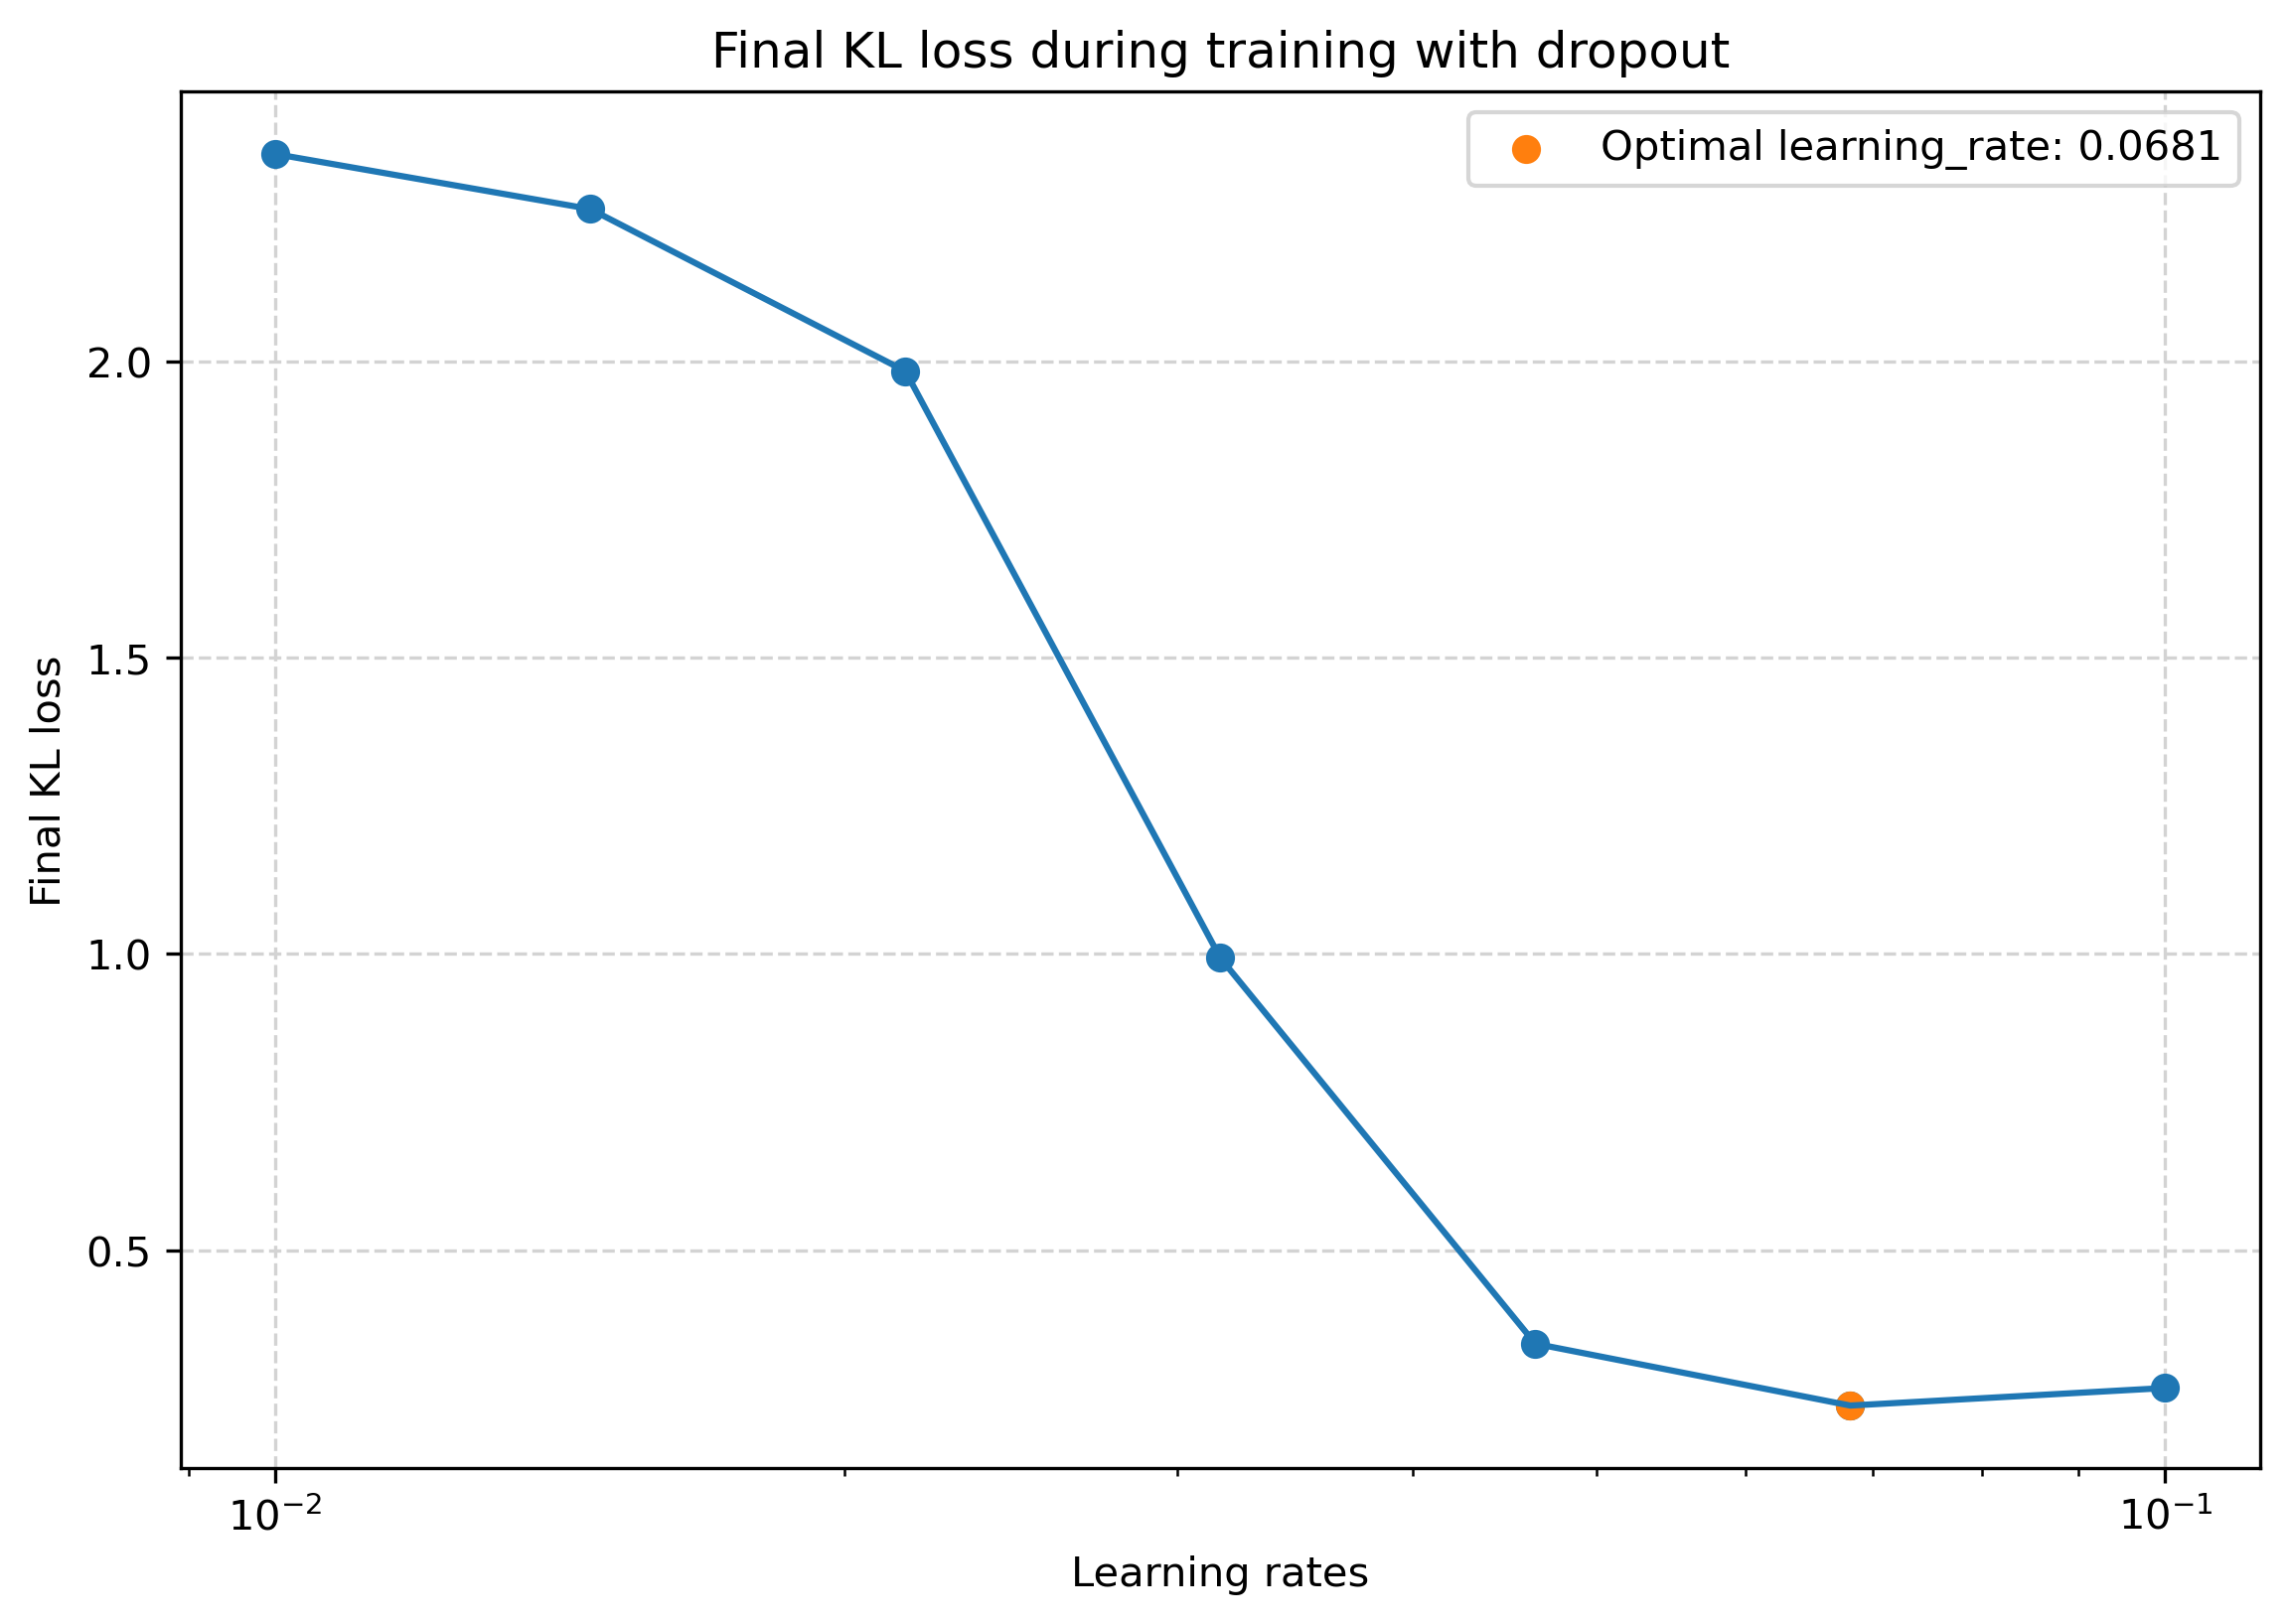

In [30]:
min_rate_dropout = learning_rates_drop[np.argmin(losses_dropout)]
min_loss_dropout = losses_dropout[np.argmin(losses_dropout)]

plt.plot(learning_rates_drop,losses_dropout)
plt.scatter(learning_rates_drop, losses_dropout)
plt.scatter(min_rate_dropout, min_loss_dropout, label = f'Optimal learning_rate: {np.round(min_rate_dropout,4)}')

plt.title('Final KL loss during training with dropout')
plt.xlabel('Learning rates')
plt.ylabel('Final KL loss')
plt.xscale('log')
plt.legend()

In [31]:
#Retraining the mlp with larger learning rate for 60 epochs
learning_rate = min_rate_dropout
batch_size = 128
epochs = 60

losses_train, losses_test, accuracy_train, accuracy_test = \
train_mlp_dropout(train_data_std, y_train, test_data_std, y_test,learning_rate =\
          learning_rate, batch_size = batch_size, dropout_rate = 0.2, epochs = epochs, scores = True)

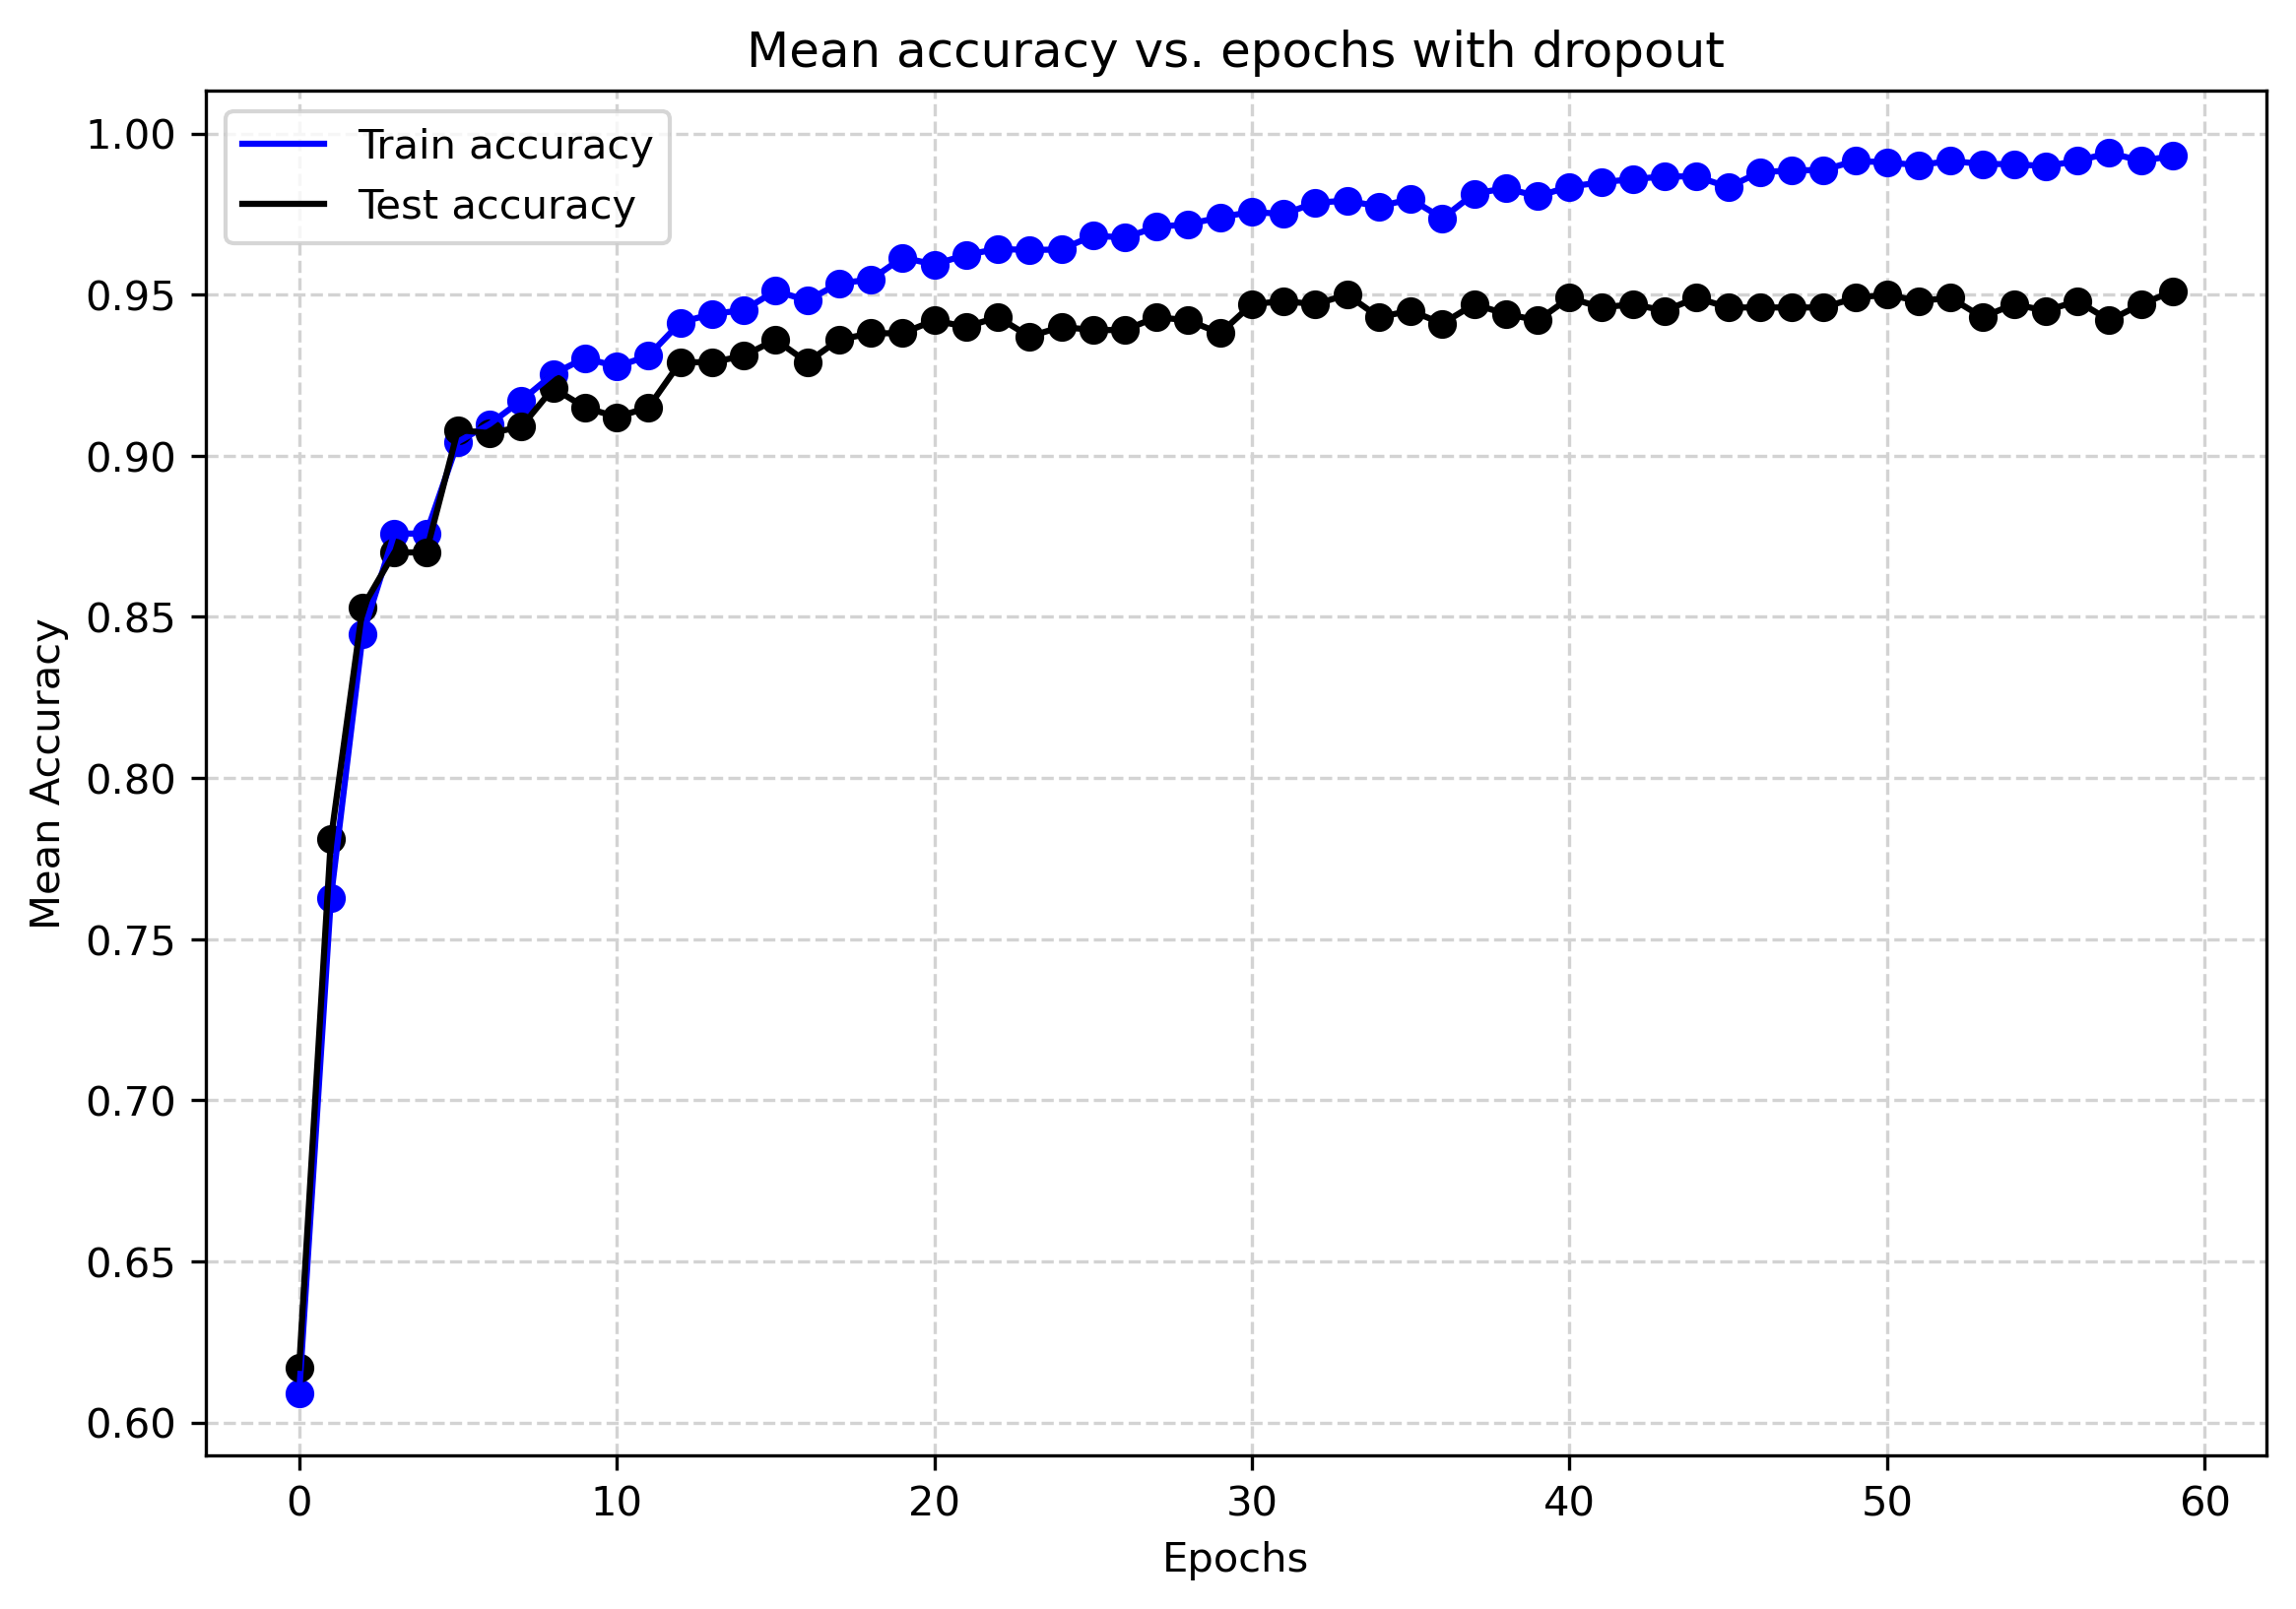

In [32]:
#Plotting accuracy scores
epoch_range = np.arange(60)
plt.plot(epoch_range,accuracy_train, label = 'Train accuracy', c = 'blue')
plt.plot(epoch_range,accuracy_test, label = 'Test accuracy', c = 'black')
plt.scatter(epoch_range,accuracy_train, c = 'blue')
plt.scatter(epoch_range,accuracy_test, c = 'black')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')
plt.title('Mean accuracy vs. epochs with dropout')
plt.show()

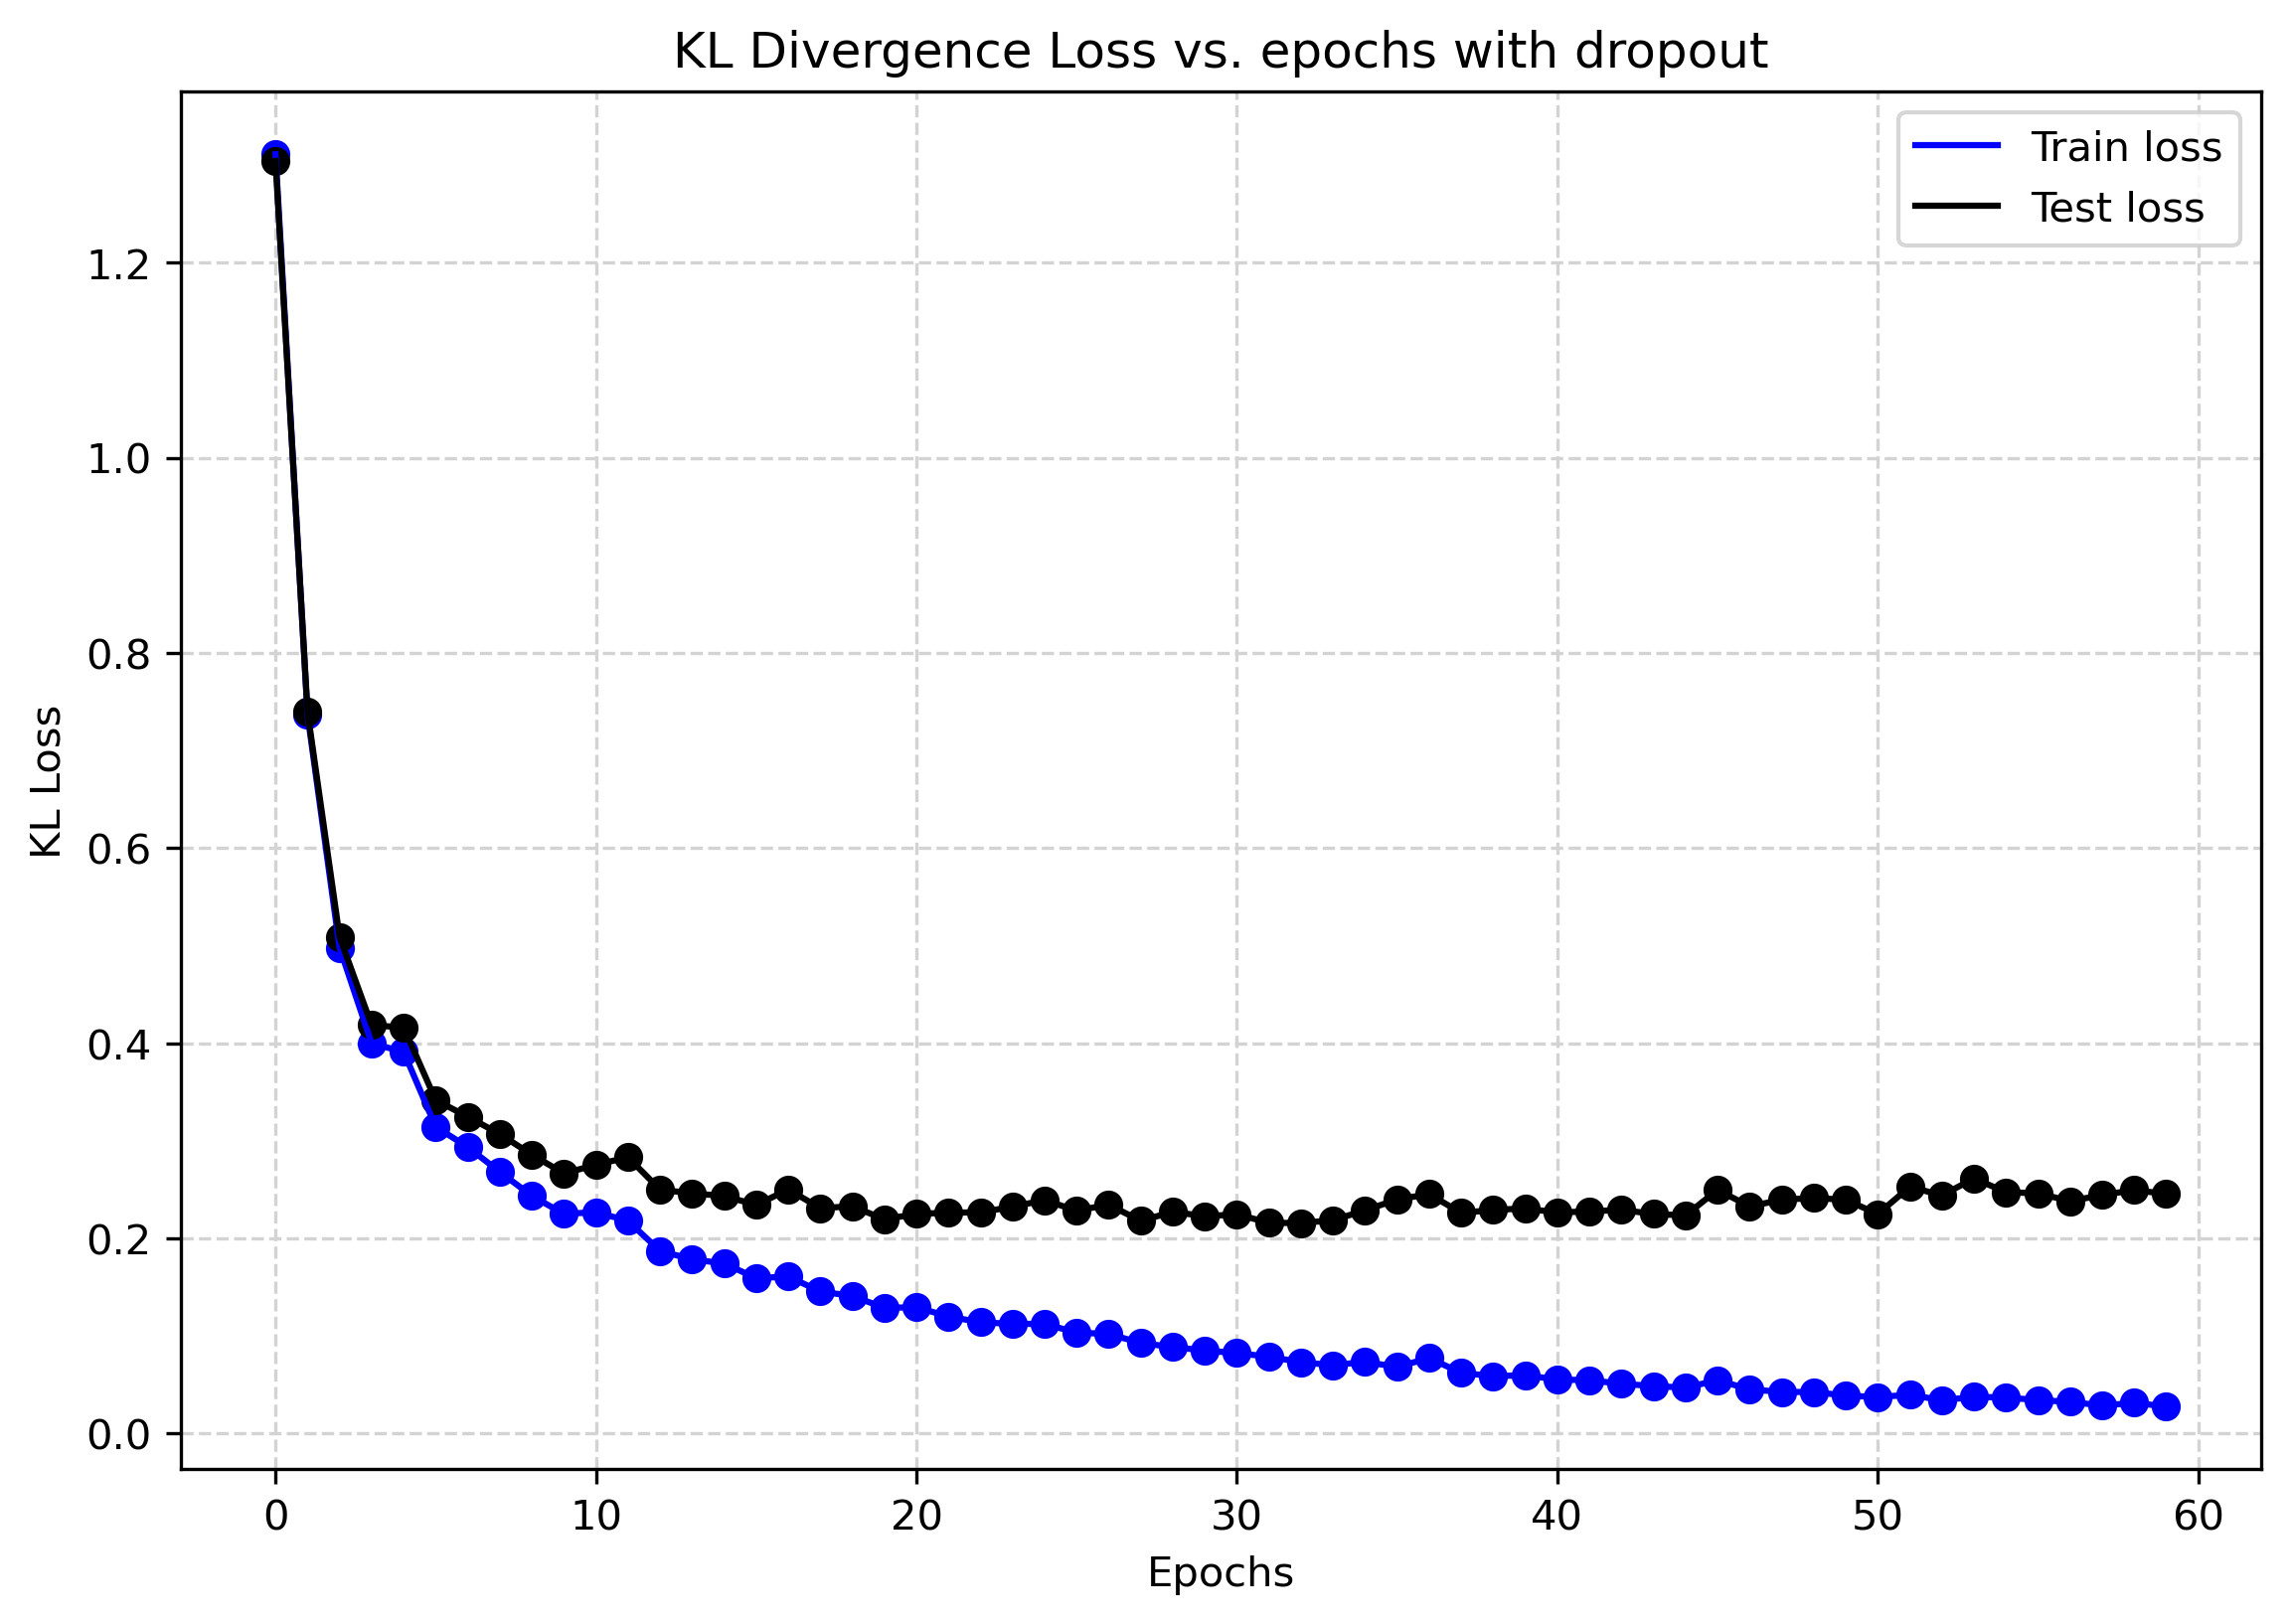

In [33]:
#Plotting Losses
plt.plot(epoch_range,losses_train, label = 'Train loss', c = 'blue')
plt.plot(epoch_range,losses_test, label = 'Test loss', c = 'black')
plt.scatter(epoch_range,losses_train, c = 'blue')
plt.scatter(epoch_range,losses_test, c = 'black')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('KL Loss')
plt.title('KL Divergence Loss vs. epochs with dropout')
plt.show()

Using a batch size of 128, I selected the first 128 such images from the training set 'MNIST_test.csv' to produce histograms of the activations of the units in the first hidden layer for both the network with dropout
and without dropout.

In [21]:
def activations(x_batch, W0, b0):
    """
    Args:

    x_batch (np.ndarray): The input batch of shape (batch_size, input_size).
    W0 (np.ndarray): The weight matrix of the first layer of shape (input_size, hidden_size).
    b0 (np.ndarray): The bias vector of the first layer of shape (1, hidden_size).

    Returns:

    h1 (np.ndarray): The output activations of the first layer of shape (batch_size, hidden_size).
    """
    a1 = dense(x_batch, W0, b0)
    h1 =  softplus(a1, β = 1)
    return h1

In [23]:
batch = test_data_std[:128]
batch_size = 128
learning_rate = 0.08
W0_drop, b0_drop, W1_drop,b1_drop, W2_drop, b2_drop, W3_drop, b3_drop, losses_test = train_mlp_dropout(train_data_std, y_train, test_data_std, y_test,learning_rate =\
          learning_rate, batch_size = batch_size, dropout_rate = 0.2, epochs = 100, scores = False)

activations_with_dropout = activations(batch, W0_drop, b0_drop)

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
learning_rate = min_rate
W0, b0, W1,b1, W2, b2, W3, b3, losses_test = train_mlp_dropout(train_data_std, y_train, test_data_std, y_test,learning_rate =\
          learning_rate, batch_size = batch_size, dropout_rate = 0, epochs = 100, scores = False)

activations_no_dropout = activations(batch, W0, b0)

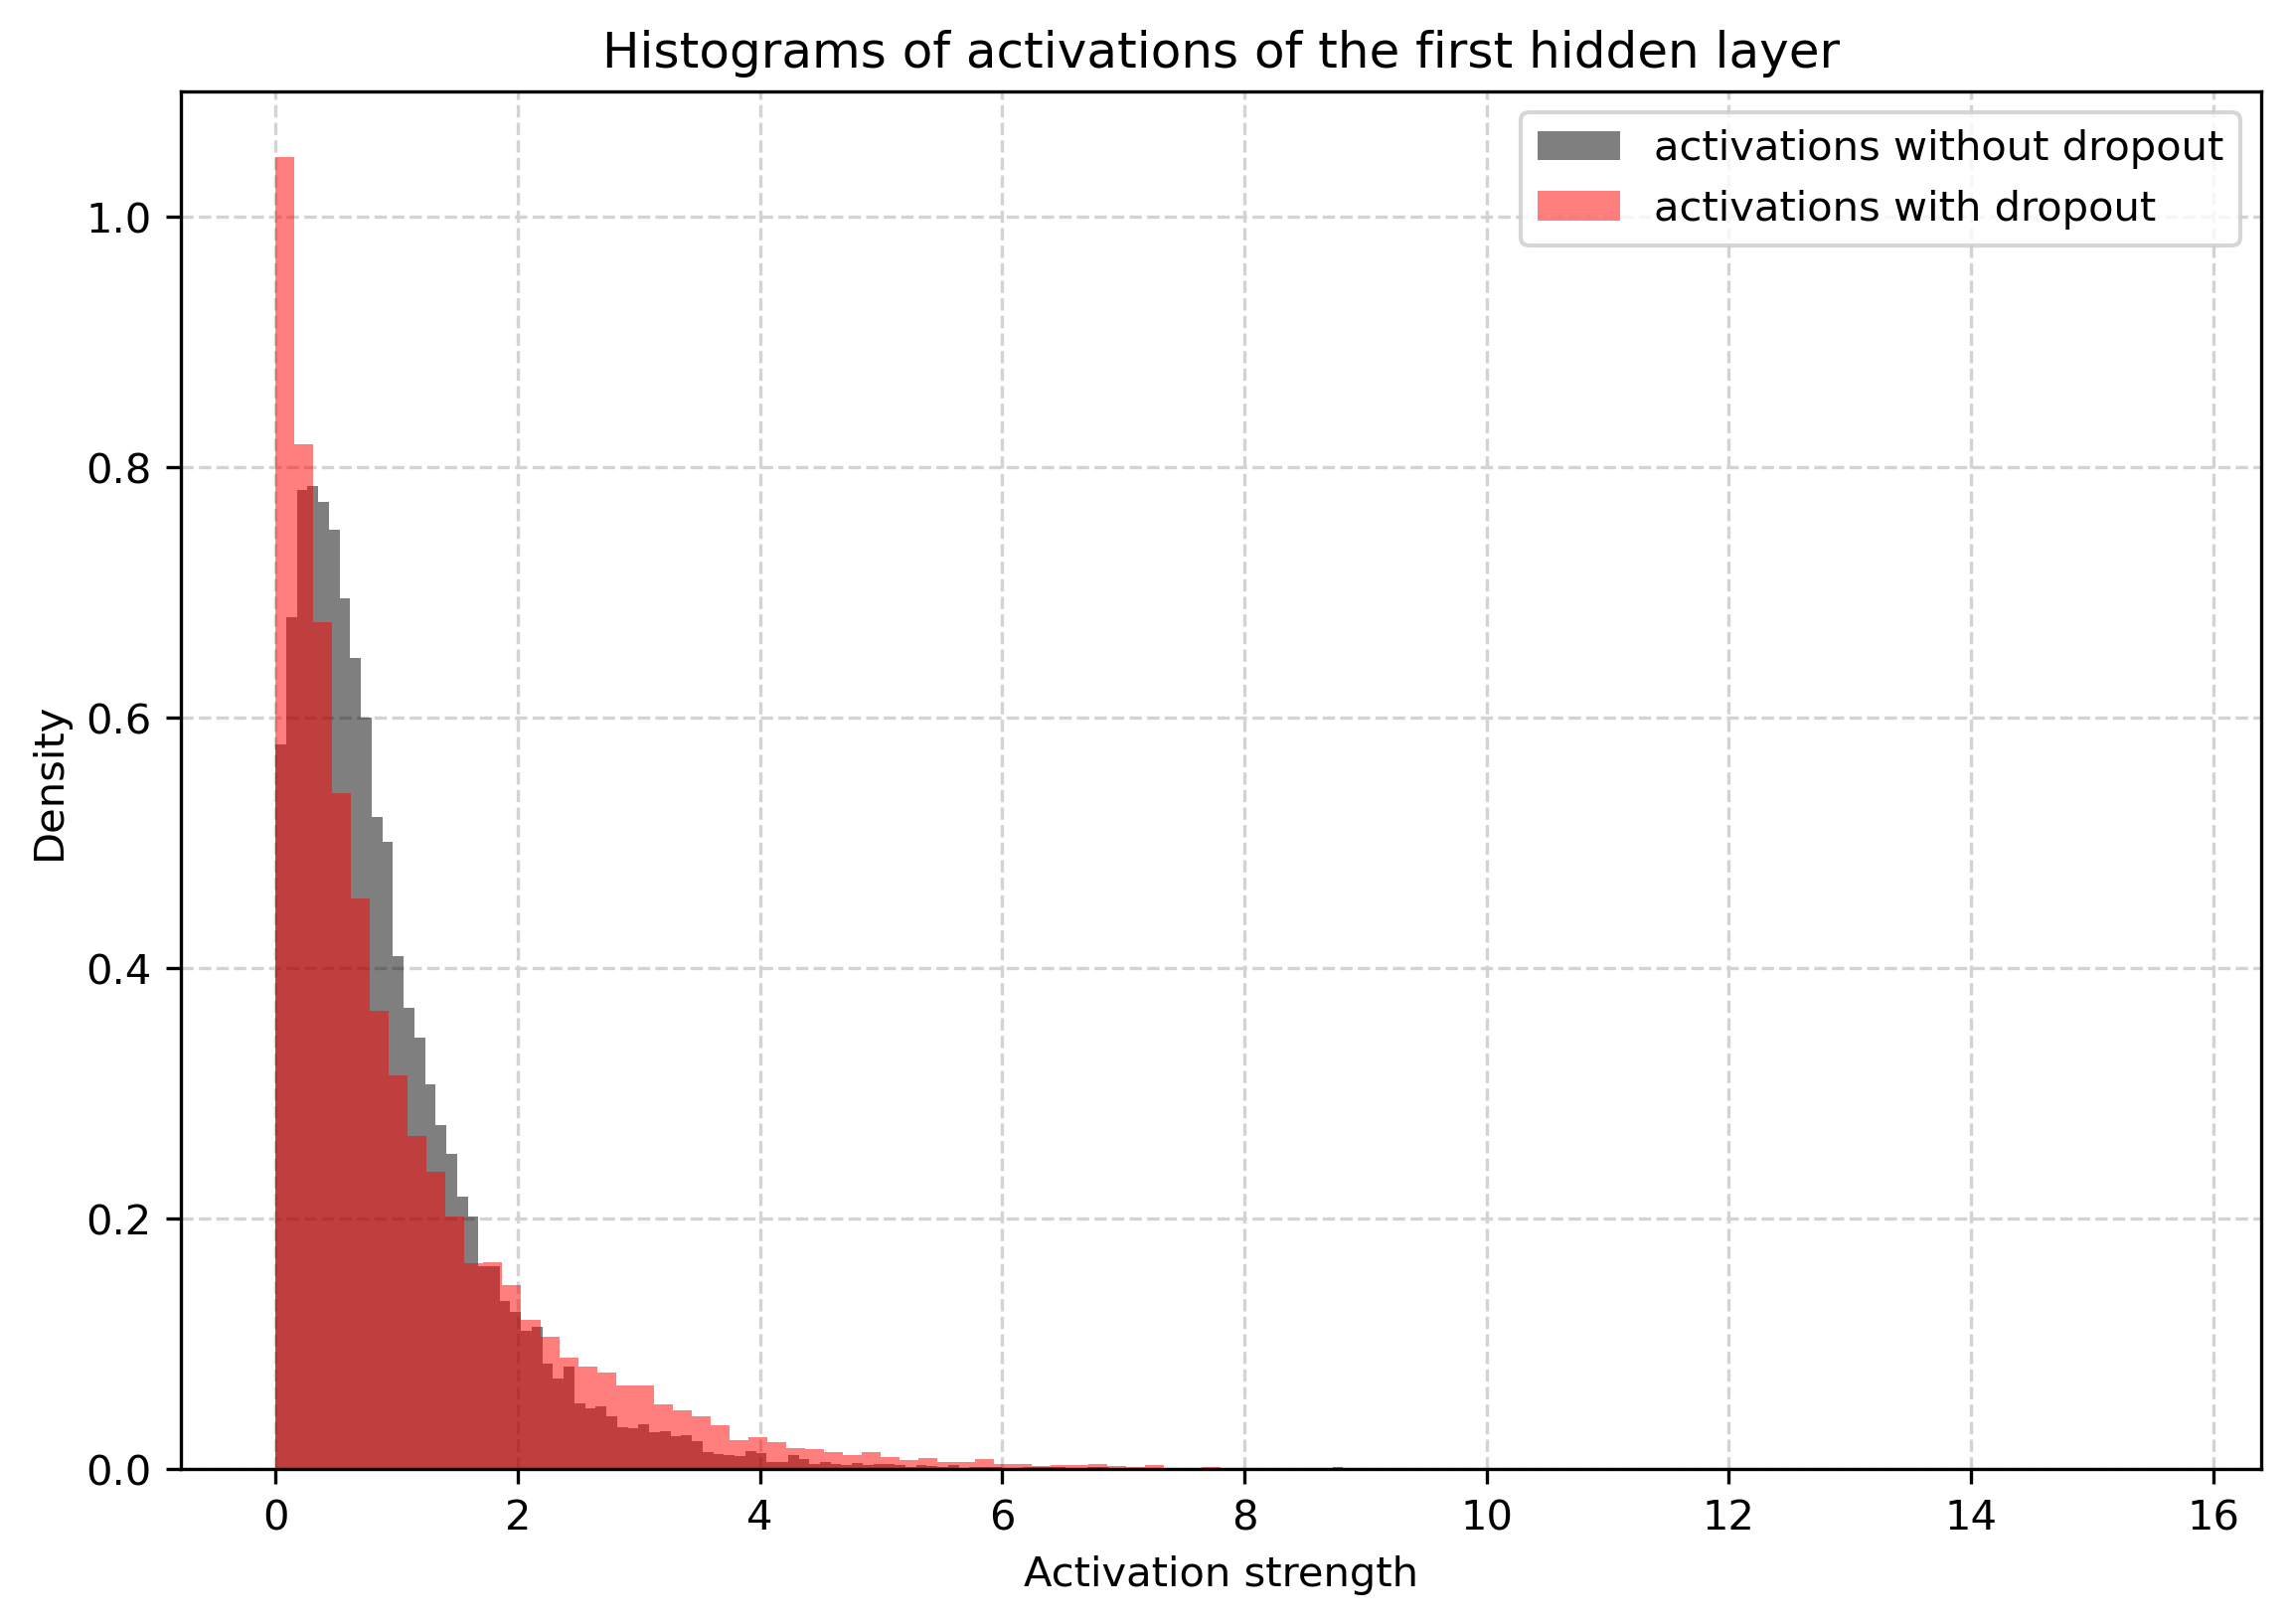

In [37]:
#histograms of first layer activations
plt.title('Histograms of activations of the first hidden layer')
plt.hist(np.ndarray.flatten(activations_no_dropout), bins = 100, alpha = 0.5, density = True, label = 'activations without dropout', color = 'black')
plt.hist(np.ndarray.flatten(activations_with_dropout), bins = 100, alpha = 0.5, density = True, label = 'activations with dropout', color = 'red')
plt.ylabel('Density')
plt.xlabel('Activation strength')
plt.legend()

In [38]:
#comparing model performance
X_test = test_data
y_pred_test_drop = np.argmax(mlp(X_test, W0_drop, b0_drop, W1_drop,b1_drop, W2_drop, b2_drop, W3_drop, b3_drop), axis = 1)     
y_pred_test = np.argmax(mlp(X_test, W0, b0, W1, b1, W2, b2, W3, b3), axis = 1)     
test_loss_drop = len(y_test[y_pred_test_drop == y_test])/len(y_test)
test_loss = len(y_test[y_pred_test == y_test])/len(y_test)
print(f'Test accuracy without dropout: {test_loss}\n')
print(f'Test accuracy with dropout: {test_loss_drop}')

Test accuracy without dropout: 0.848

Test accuracy with dropout: 0.889


Comparing the histograms in the above plot, we note the following:

The histogram of activations from the network without dropout (black) shows a $\textbf{sizeable mode away from zero}$, at around 0.5, whereas the histogram of activaitons from the network with dropout (red) shows a $\textbf{sharp peak at zero}$; very few units have high activation. This suggests that dropout acts as a $\textbf{regulariser}$ for the neural network, which induces sparsity on hidden layer activations.

This regularisation effect is reflected on model performance. Dropping out neurons in the network at random diminishes neuron dependencies, which in turn makes neurons learn features that are more robust, making the model generalise better to unseen data. This is seen in the higher ($\textbf{by 5.9}\%$) mean accurcay of the 200 neuron mlp of 0.911, compared to the accuracy of 0.852 achieved by 50 neuron mlp on the dataset 'MNIST_test.csv'.

### 1.2 Dimensionality reduction (20 marks)

In [39]:
np.random.seed(987654)

In [40]:
def standardise_pca(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [41]:
def inverse_transform_pca(X_train, X):
    """
    Args:
        X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:
        Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    X_inv = (X*std_filled)+mu
    return X_inv

In [42]:
#Loading data

#train data 
noise_train_data = pd.read_csv('MNIST_train_noisy.txt',sep= ' ', header=None).to_numpy()

#standardise train data
noise_train_data_std = standardise_pca(noise_train_data)

#test data
noise_test_data = pd.read_csv('MNIST_test_noisy.txt', sep= ' ', header=None).to_numpy()

#standardise test data
noise_test_data_std = standardise_pca(noise_test_data)

#### 1.2.1

Following the lecture notes, to perform PCA on some dataset $\boldsymbol X$ for $k$ principal components we need to perform the following steps:

>1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
>1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
>3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
>4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors

where $n$ is the number of samples in the design matrix $ X$.

In [43]:
def pca_function(X,m):

    """
    The pca_function performs Principal Component Analysis (PCA) on the standardised input dataset X\
    and returns the transformed dataset in the new feature space,\
    along with the corresponding eigenvectors and eigenvalues of the covariance matrix.

    Args:
        X (np.ndarray): The dataset to perform PCA on.
        m (int): The number of principal components to retain.

    Returns:
        X_pca (np.ndarray): The dataset transformed into the new feature space.
        eigenvectors (np.ndarray): The eigenvectors of the covariance matrix sorted by decreasing eigenvalue.
        eigenvalues (np.ndarray): The eigenvalues of the covariance matrix sorted in decreasing order.
    """

    # create covariance matrix S
    C = X.T@X / (len(X)-1)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k = m, which="LM", return_eigenvectors=True) 
    
    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors) 

    return X_pca, eigenvectors, eigenvalues

We now implement a function that computes the variance in each principle component:

In [44]:
def var_frac(X_train,m): 
    """
    The var_frac function computes the explained variance ratios for the top m principal components obtained through PCA on the input training data X_train.

    Args:

    X_train: A numpy array of shape (n_samples, n_features) representing the training data.
    m: An integer indicating the number of top principal components to consider.

    Returns:

    explained_variances: A numpy array of shape (m,) containing the explained variance ratios for the top m principal components.\
    The ratio is computed as the fraction of the total variance explained by each principal component.
    """

    # compute the projection, the eigenvector and eigenvalues from our function
    X_pca, eigenvectors, eigenvalues = pca_function(X_train,m) 

    C = 1.0/(len(X_train)-1)*X_train.T@X_train
    all_eigenvalues, _ = np.linalg.eig(C)
    total_variance = abs(all_eigenvalues.sum())
    explained_variances = eigenvalues / total_variance 

    return explained_variances

In [45]:
# Perform PCA analysis on standardised noisy training data
accounted_variance = np.cumsum(var_frac(noise_train_data_std, 783))
principle_component_range = np.arange(783)

In [46]:
#compute percentiles
m_70 = principle_component_range[accounted_variance >= 0.7][0]
m_80 = principle_component_range[accounted_variance >= 0.8][0]
m_90 = principle_component_range[accounted_variance >= 0.9][0]

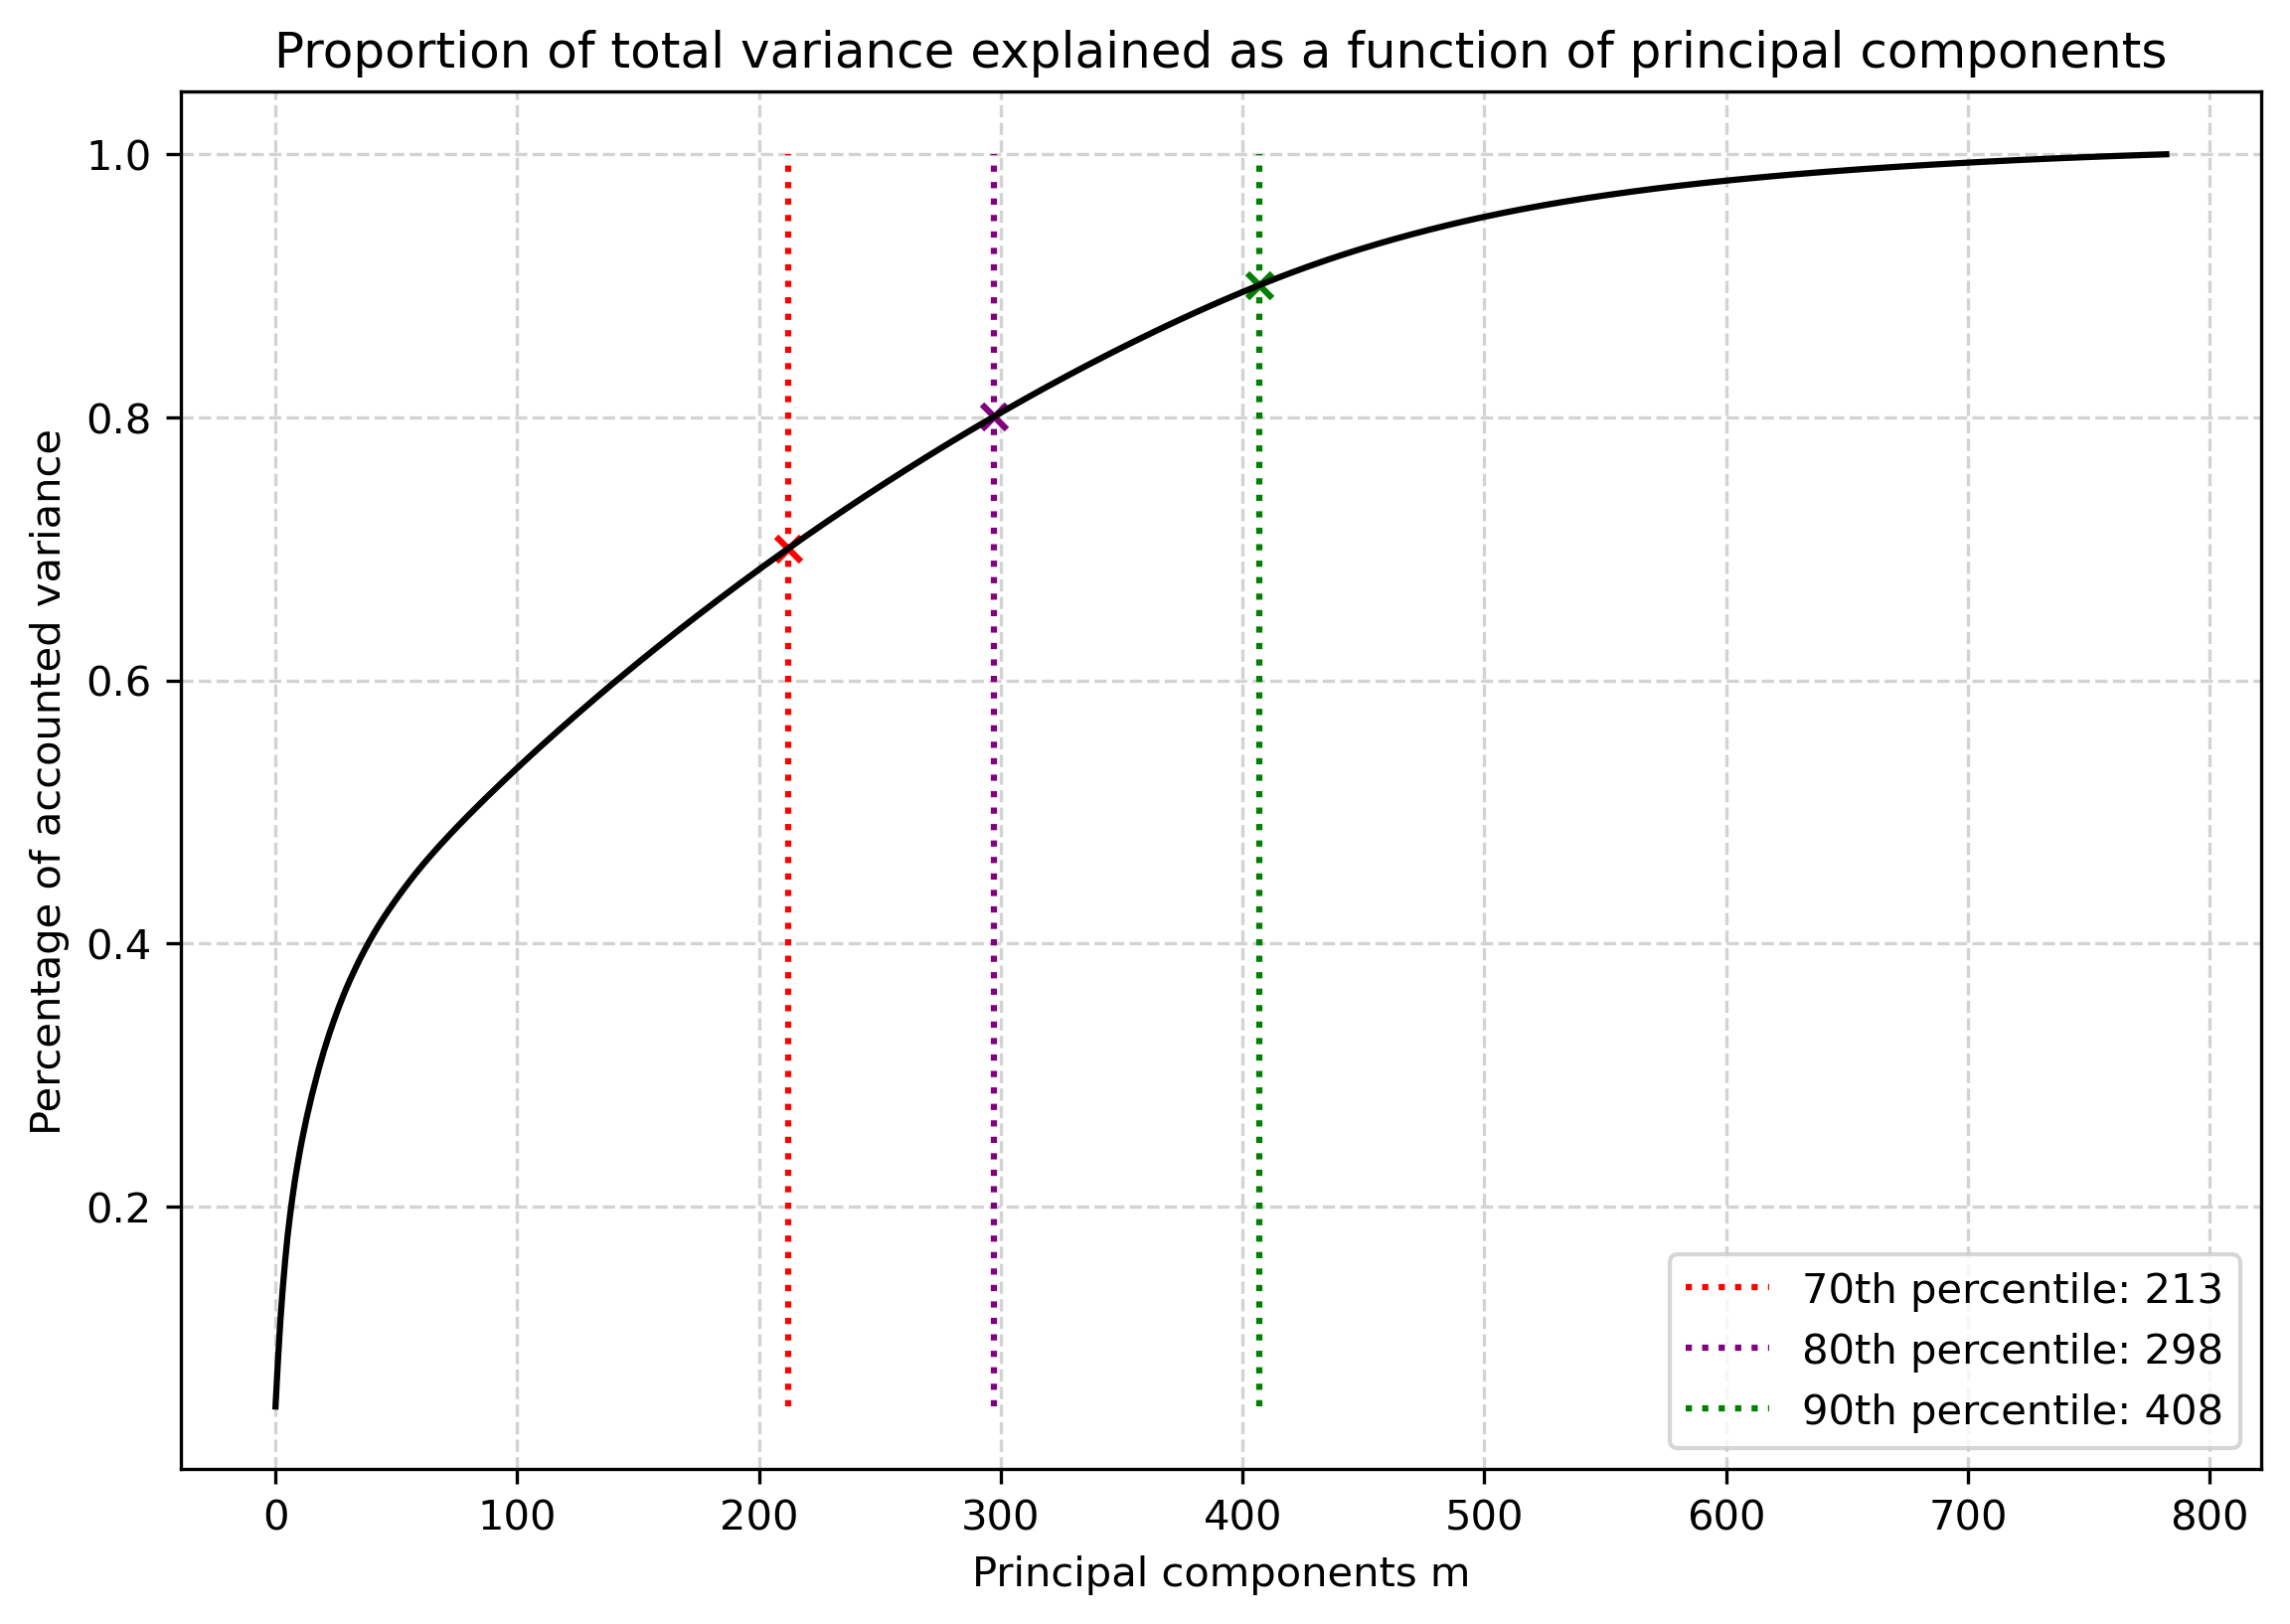

In [47]:
#Plot the fraction of variance explained by PCA as m is increased and provide the 3 values of m at which, respectively
plt.plot(principle_component_range, accounted_variance, color = 'black')
plt.vlines(m_70, ymin = min(accounted_variance), ymax = 1, color = 'red',\
           label = f'70th percentile: {m_70+1}', linestyle = 'dotted')
plt.vlines(m_80, ymin = min(accounted_variance), ymax = 1, color = 'purple',\
           label = f'80th percentile: {m_80+1}', linestyle = 'dotted')
plt.vlines(m_90, ymin = min(accounted_variance), ymax = 1, color = 'green',\
           label = f'90th percentile: {m_90+1}', linestyle = 'dotted')
plt.scatter(m_70, accounted_variance[m_70], marker = 'x', color = 'red')
plt.scatter(m_80, accounted_variance[m_80], marker = 'x', color = 'purple')
plt.scatter(m_90, accounted_variance[m_90], marker = 'x', color = 'green')
plt.title('Proportion of total variance explained as a function of principal components')
plt.ylabel('Percentage of accounted variance')
plt.xlabel('Principal components m')
plt.legend(loc = 'lower right')

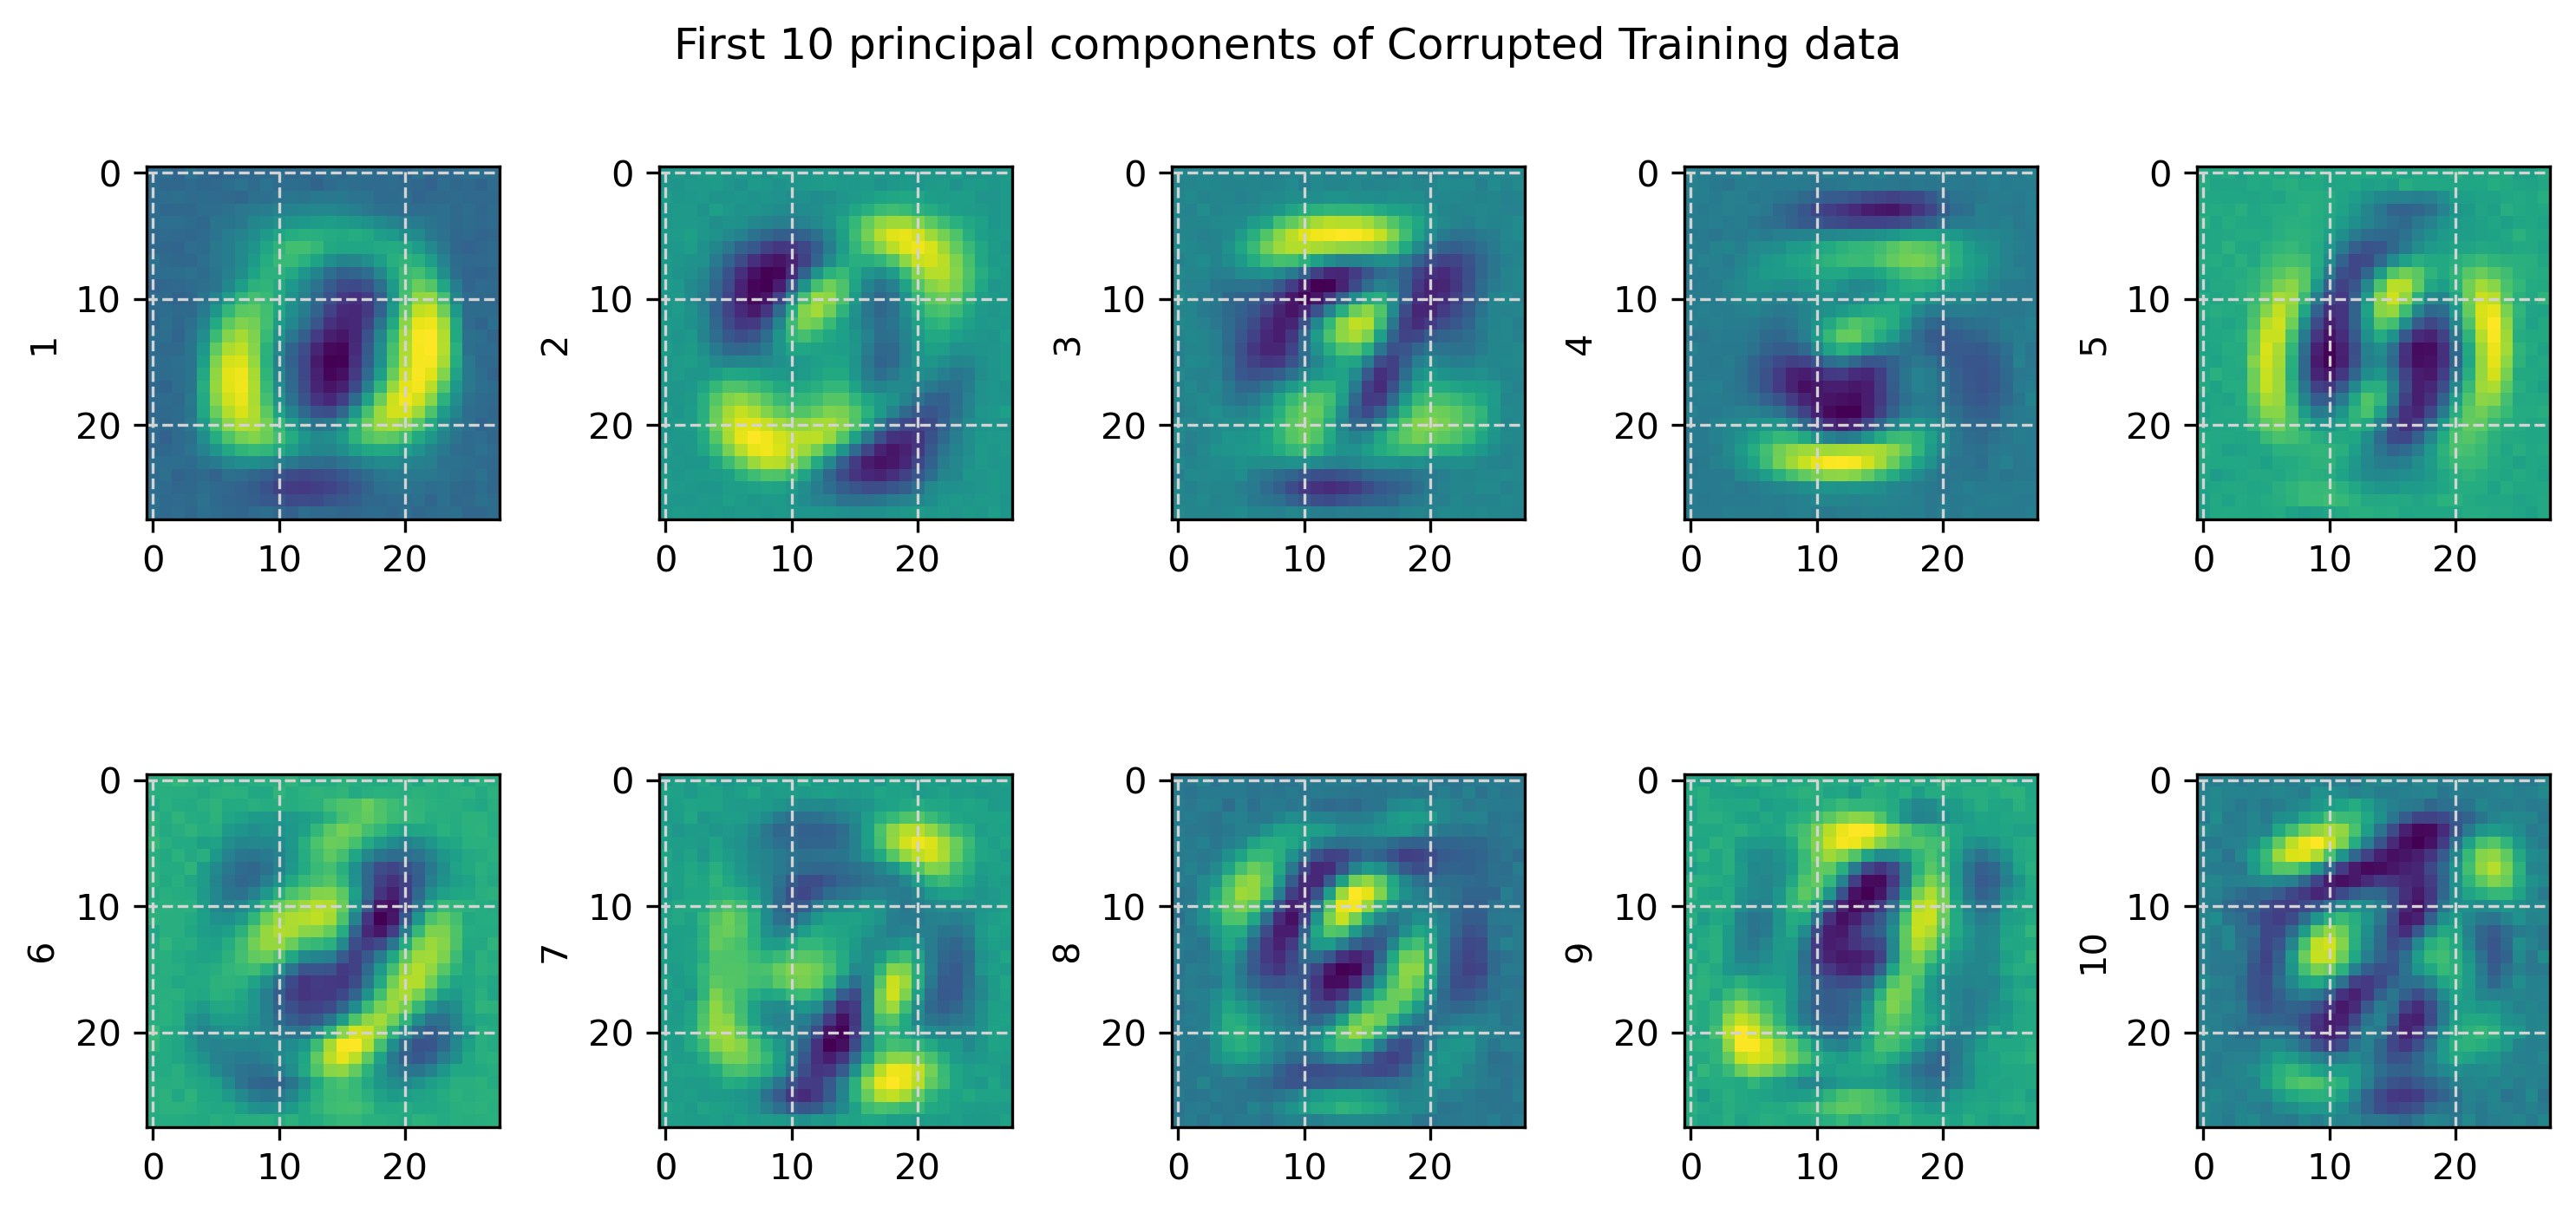

In [48]:
# visualise the first m=10 principal components from PCA
m = 10
X = noise_train_data_std
X_pca, eigenvectors, eigenvalues = pca_function(X,m) 

nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,5))
plt.suptitle('First 10 principal components of Corrupted Training data')

pca_components = eigenvectors
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(pca_components[:,i].reshape([28,28]))
    ax.set_ylabel(str(i+1))
fig.tight_layout()

### 1.2.2

NMF approximately factors our n-by-m feature matrix $\mathbf X$ into nonnegative factors $\mathbf W$ (n-by-k) and $\mathbf H$ (k-by-m). $\mathbf W\mathbf H$ is a lower-rank approximation to $\mathbf A$. The factors $\mathbf W$ and $\mathbf H$ minimize the root mean square residual D between $\mathbf X$and $\mathbf W\mathbf H$. Since the input matrix $X$ must be non-negative, minmax normalisation will be employed to standardise the data. Following the notebooks, we will use Lee and Seung's multiplicative update rule [4]: 
<center>
$
\mathbf{H}_{[i,j]}^{n+1}\leftarrow \mathbf{H}_{[i,j]}^{n} 
\frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}}
$
</center>

and

<center>
$
\mathbf{W}_{[i,j]}^{n+1}\leftarrow \mathbf{W}_{[i,j]}^{n} 
\frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}}
$
</center>

until $\mathbf{W}$ and $\mathbf{H}$ are stable.

In [49]:
def normalize_nmf(X):
    """
    The normalize_nmf function performs normalization on the input data X using min-max scaling technique, such that all the values are in the range [0,1].

    Args:

        X: A numpy array of shape (n_samples, n_features) representing the input data.
        
    Returns:
        X_norm: A numpy array of the same shape as X with the normalized values obtained by applying min-max scaling technique.
    """

    X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

In [50]:
def inverse_transform_nmf(X_train, X):
    """
    The normalize_nmf function performs normalization on the input data X using min-max scaling technique, such that all the values are in the range [0,1].

    Args:

        X: A numpy array of shape (n_samples, n_features) representing the input data.
        
    Returns:
        X_norm: A numpy array of the same shape as X with the normalized values obtained by applying min-max scaling technique.
    """

    X_norm = (X) *(np.max(X_train) - np.min(X_train)) +  np.min(X_train)
    return X_norm

Our loss for the optimisation algorithm described above is defined as:
<center>
$
\chi^2 = \frac{e^⊤ (X \odot d \odot d) e}{n}
$
</center>

where d is the difference $d = X - WH$, where $X$ is the original feature matrix and $W$ and $H$ are the two factored matrices. Also note, e is a vector of all ones and $n$ is the total number of elements in $X$. The symbol $\odot$ is the element wise product (Hadamard product).

In [51]:
def cost(X,W,H):
    """
    Calculates the cost function of a matrix factorization model.

    Args:
        X (numpy.ndarray): The input matrix with shape (n_samples, n_features).
        W (numpy.ndarray): The left factor matrix with shape (n_samples, n_components).
        H (numpy.ndarray): The right factor matrix with shape (n_components, n_features).

    Returns:
        chi2 (float): The cost value of the matrix factorization model.
    """
    
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) 
    #number of elements in X
    n = X.shape[0]*X.shape[1]

    chi2 = ((X*diff) * diff).sum() / n 
    
    return chi2

Now we implement Lee and Seung's multiplicative update rule using matrix multiplication as opposed to element-wise multiplication in the update step.

In [52]:
def nmf(X_train, m, n_iters = 1000):
    """
    Performs Non-negative Matrix Factorization on the input matrix.

    Args:
        X_train (numpy.ndarray): The input matrix with shape (n_samples, n_features).
        m (int): The number of dimensions on which to project.
        n_iters (int): The number of iterations to perform. Default is 1000.

    Returns:
        H (numpy.ndarray): The basis matrix with shape (m, n_features).
        W (numpy.ndarray): The coefficients matrix with shape (n_samples, m).
        chi2 (list): The cost values at each iteration.
        convergence_index (int): The index where the difference in cost is below tolerance.
    """

    # m x k components matrix, usually interpreted as the coefficients, where m is the number of data
    W = np.random.rand(X_train.shape[0], m)


    # choosing the number of dimensions on which to project

    # m x k components matrix, usually interpreted as the coefficients, where m is the number of data
    W = np.random.rand(X_train.shape[0], m)

    # k x n matrix interpreted as the basis set, where n is the number of features (e.g. pixels)
    H = np.random.rand(m, X_train.shape[1])
    
    # empty list for chi2 
    chi2 = []
    convergence_indices = []

    #index where difference in cost is betow tolerance 
    prev_cost = np.inf
    tolerance = 1e-4

    # loop over the n iterations
    for i in trange(n_iters):

        # compute the update on H
        H = H * ((W.T@(X_train)) / (W.T@(W@(H))+1e-4) )

        # compute the update on W
        W = W * ((X_train@(H.T)) / (W@(H@(H.T))+1e-4))

        #check for convergence of cost
        chi_cost = cost(X_train,W,H)

        if np.abs(prev_cost-chi_cost) < tolerance*prev_cost:
            convergence_indices.append(i)
            
        prev_cost = chi_cost
            
        # compute the chi2 and append to list
        chi2.append(chi_cost)
        
    return H, W, chi2, convergence_indices[0]

We fit the nmf model on the corrupted train data with 10 nmf components. We implement a convergence criterion in the 'nmf' function above to showcase convergence of the $\chi^2$ loss, which we also plot as a function of the number of iterations.

In [53]:
#Train nmf model with m=10 nmf components
m = 10
X_train = normalize_nmf(noise_train_data)
H, W, chi2, convergence_index = nmf(X_train, m, n_iters = 1000)
#check for convergence based on fraction of variance explained 

In [54]:
print(f'Convergence reached with cost: {chi2[convergence_index]}')
print(f'Convergence reached at iteration: {convergence_index}')

Convergence reached with cost: 0.007142930536196046
Convergence reached at iteration: 237


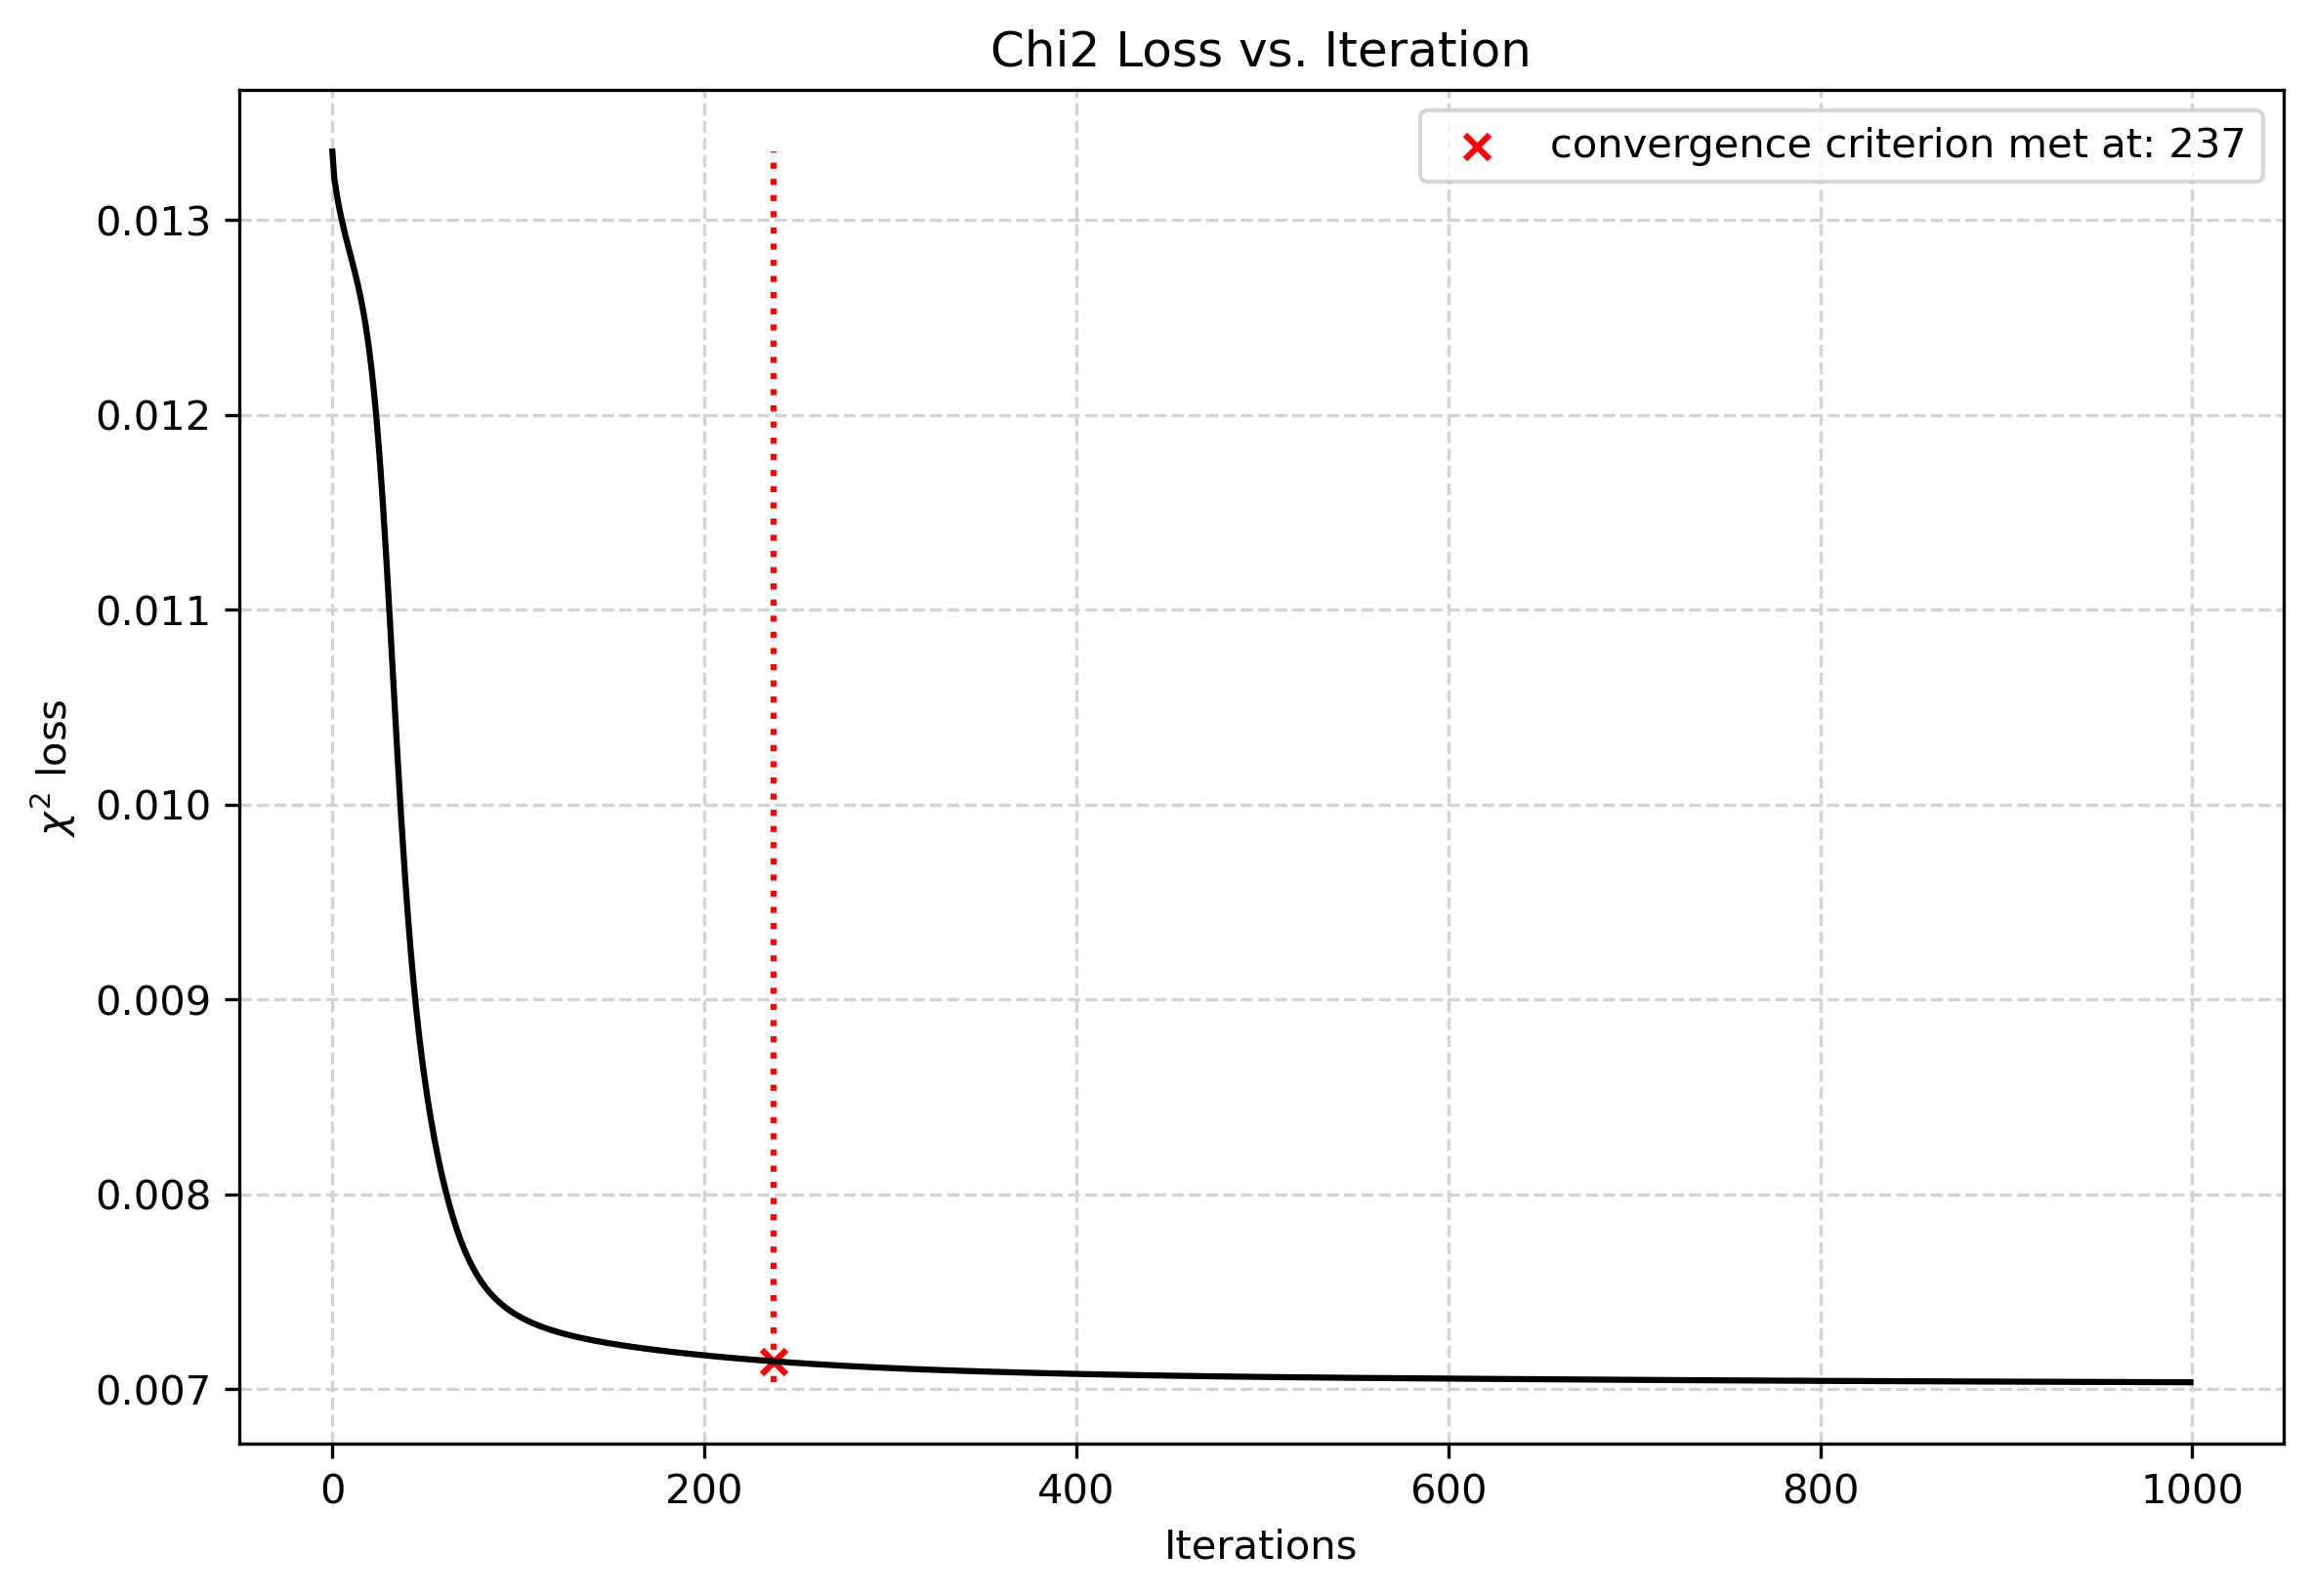

In [55]:
# plotting the cost to check for convergence 
plt.plot(chi2, color = 'black')
plt.title('Chi2 Loss vs. Iteration')
plt.vlines(convergence_index, ymin = min(chi2), ymax = max(chi2), linestyle = 'dotted', color = 'red')
plt.scatter(convergence_index, chi2[convergence_index], marker = 'x',\
            c = 'red', label = f'convergence criterion met at: {convergence_index}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel(r'$\chi^2$ loss')
plt.show()

### Now we visualise the m=10 NMF components using imshow: 

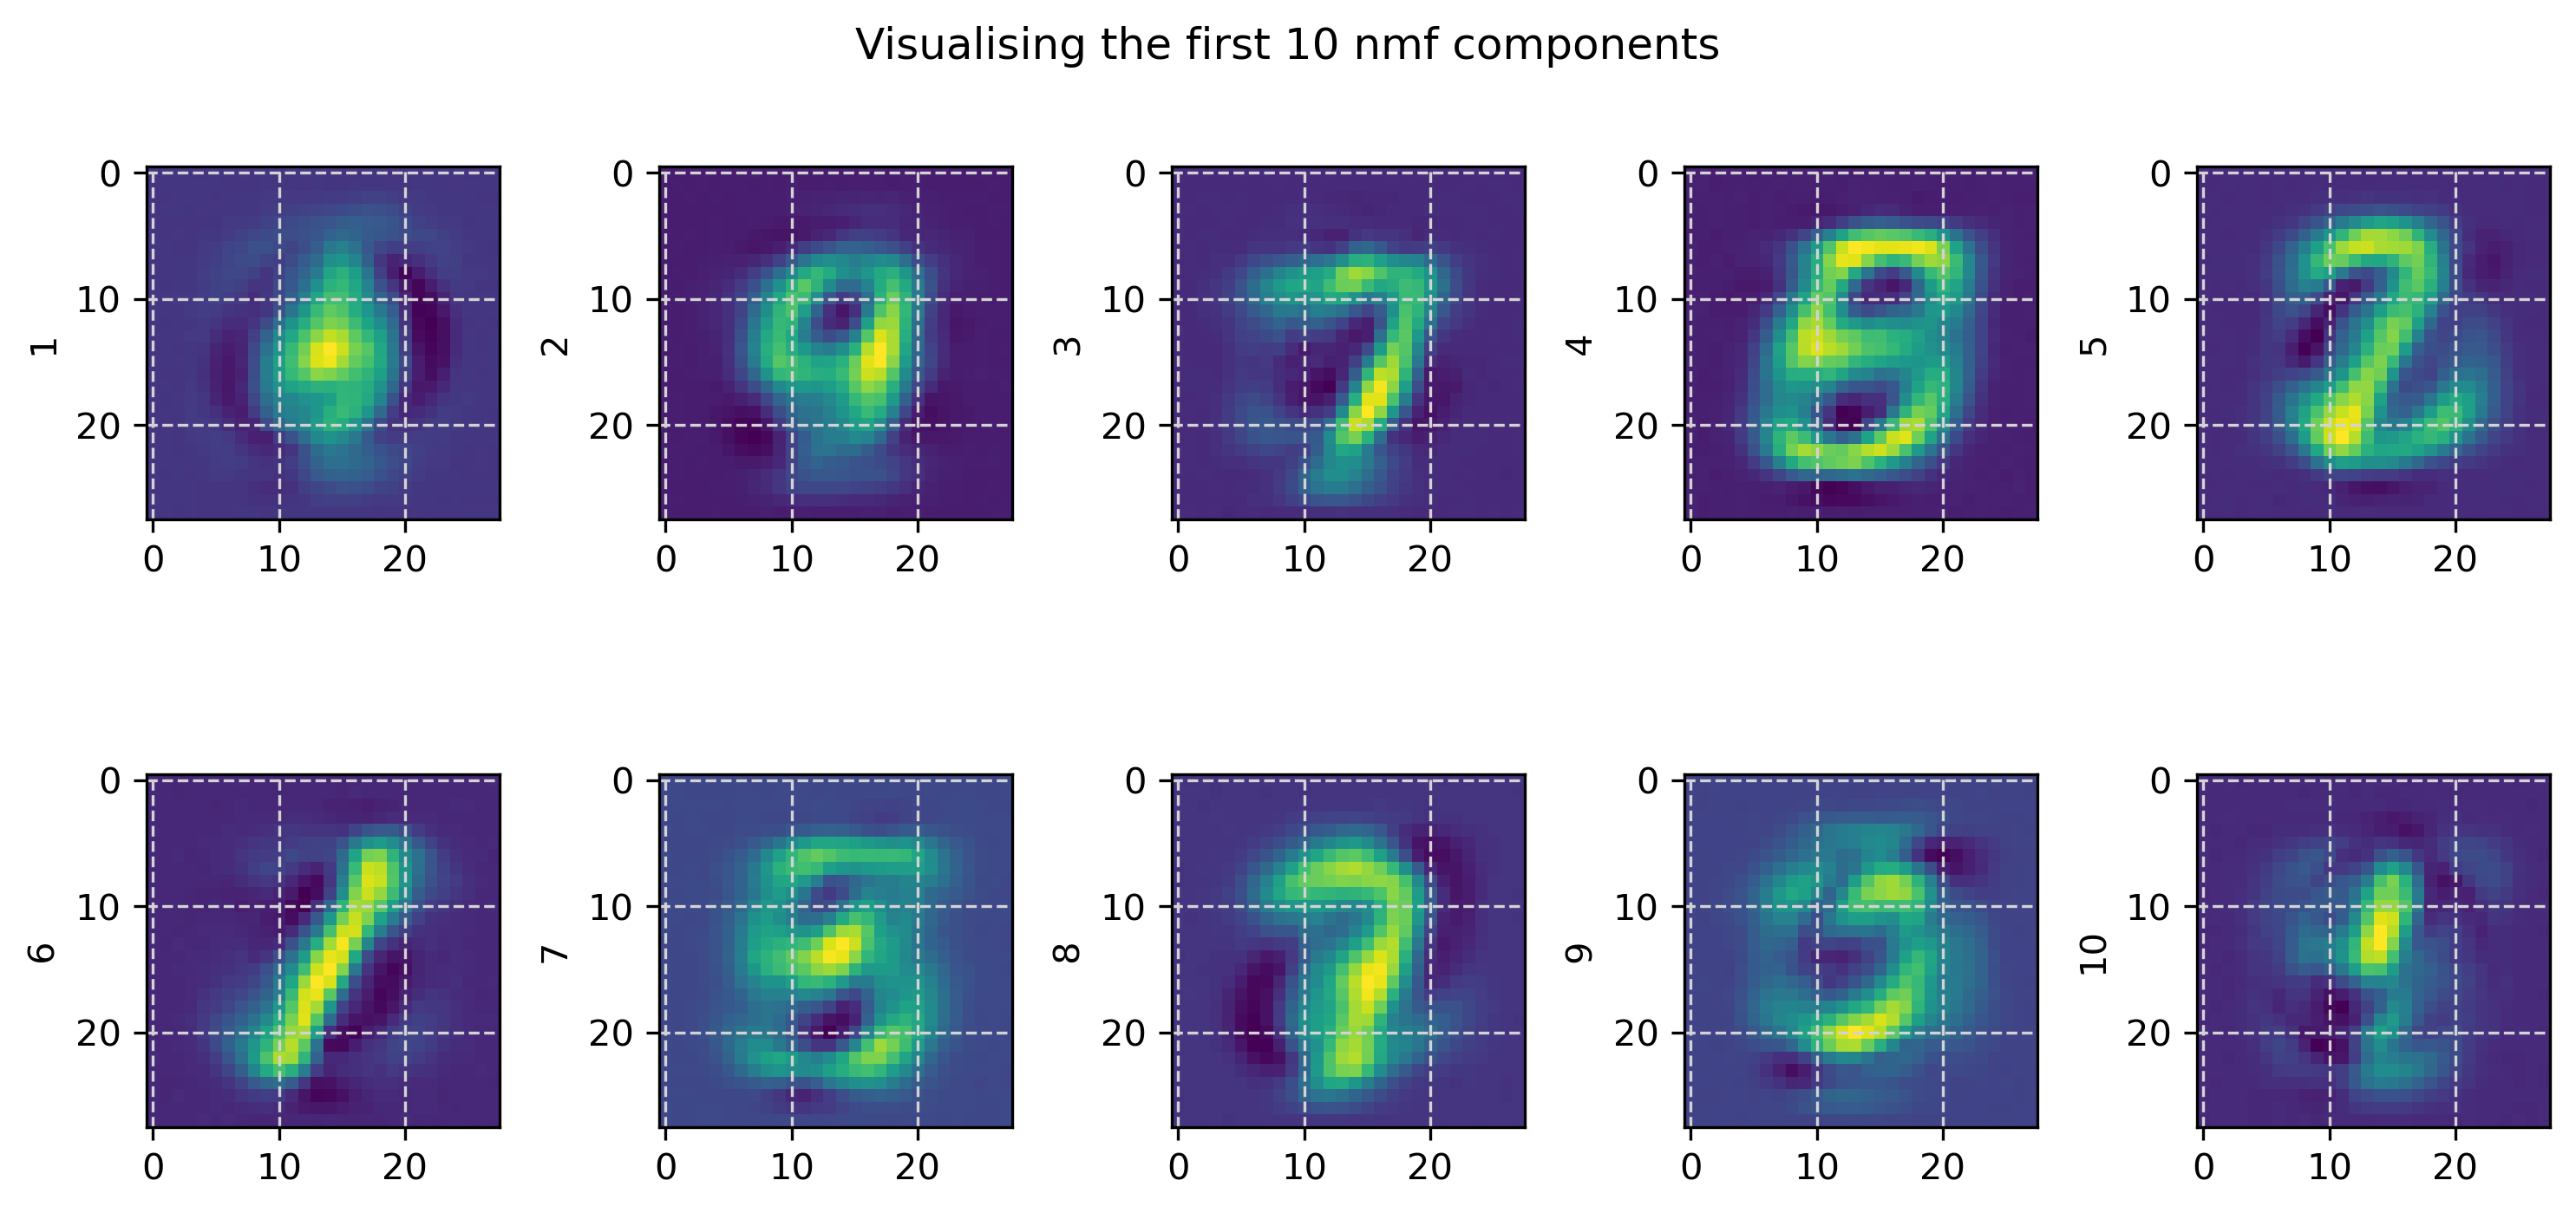

In [56]:
#Visualising the m=10 NMF components using imshow 
m = 10

X_nmf = normalize_nmf(noise_train_data)
H, W, losses, convergence_indices = nmf(X_nmf, m, n_iters = 1000)

nmf_components = W@H

nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,5))
fig.suptitle('Visualising the first 10 nmf components')

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(nmf_components[i].reshape([28,28]))
    ax.set_ylabel(str(i+1))
fig.tight_layout()

Comparing side-by-side various principal components:

Text(0, 0.5, '7')

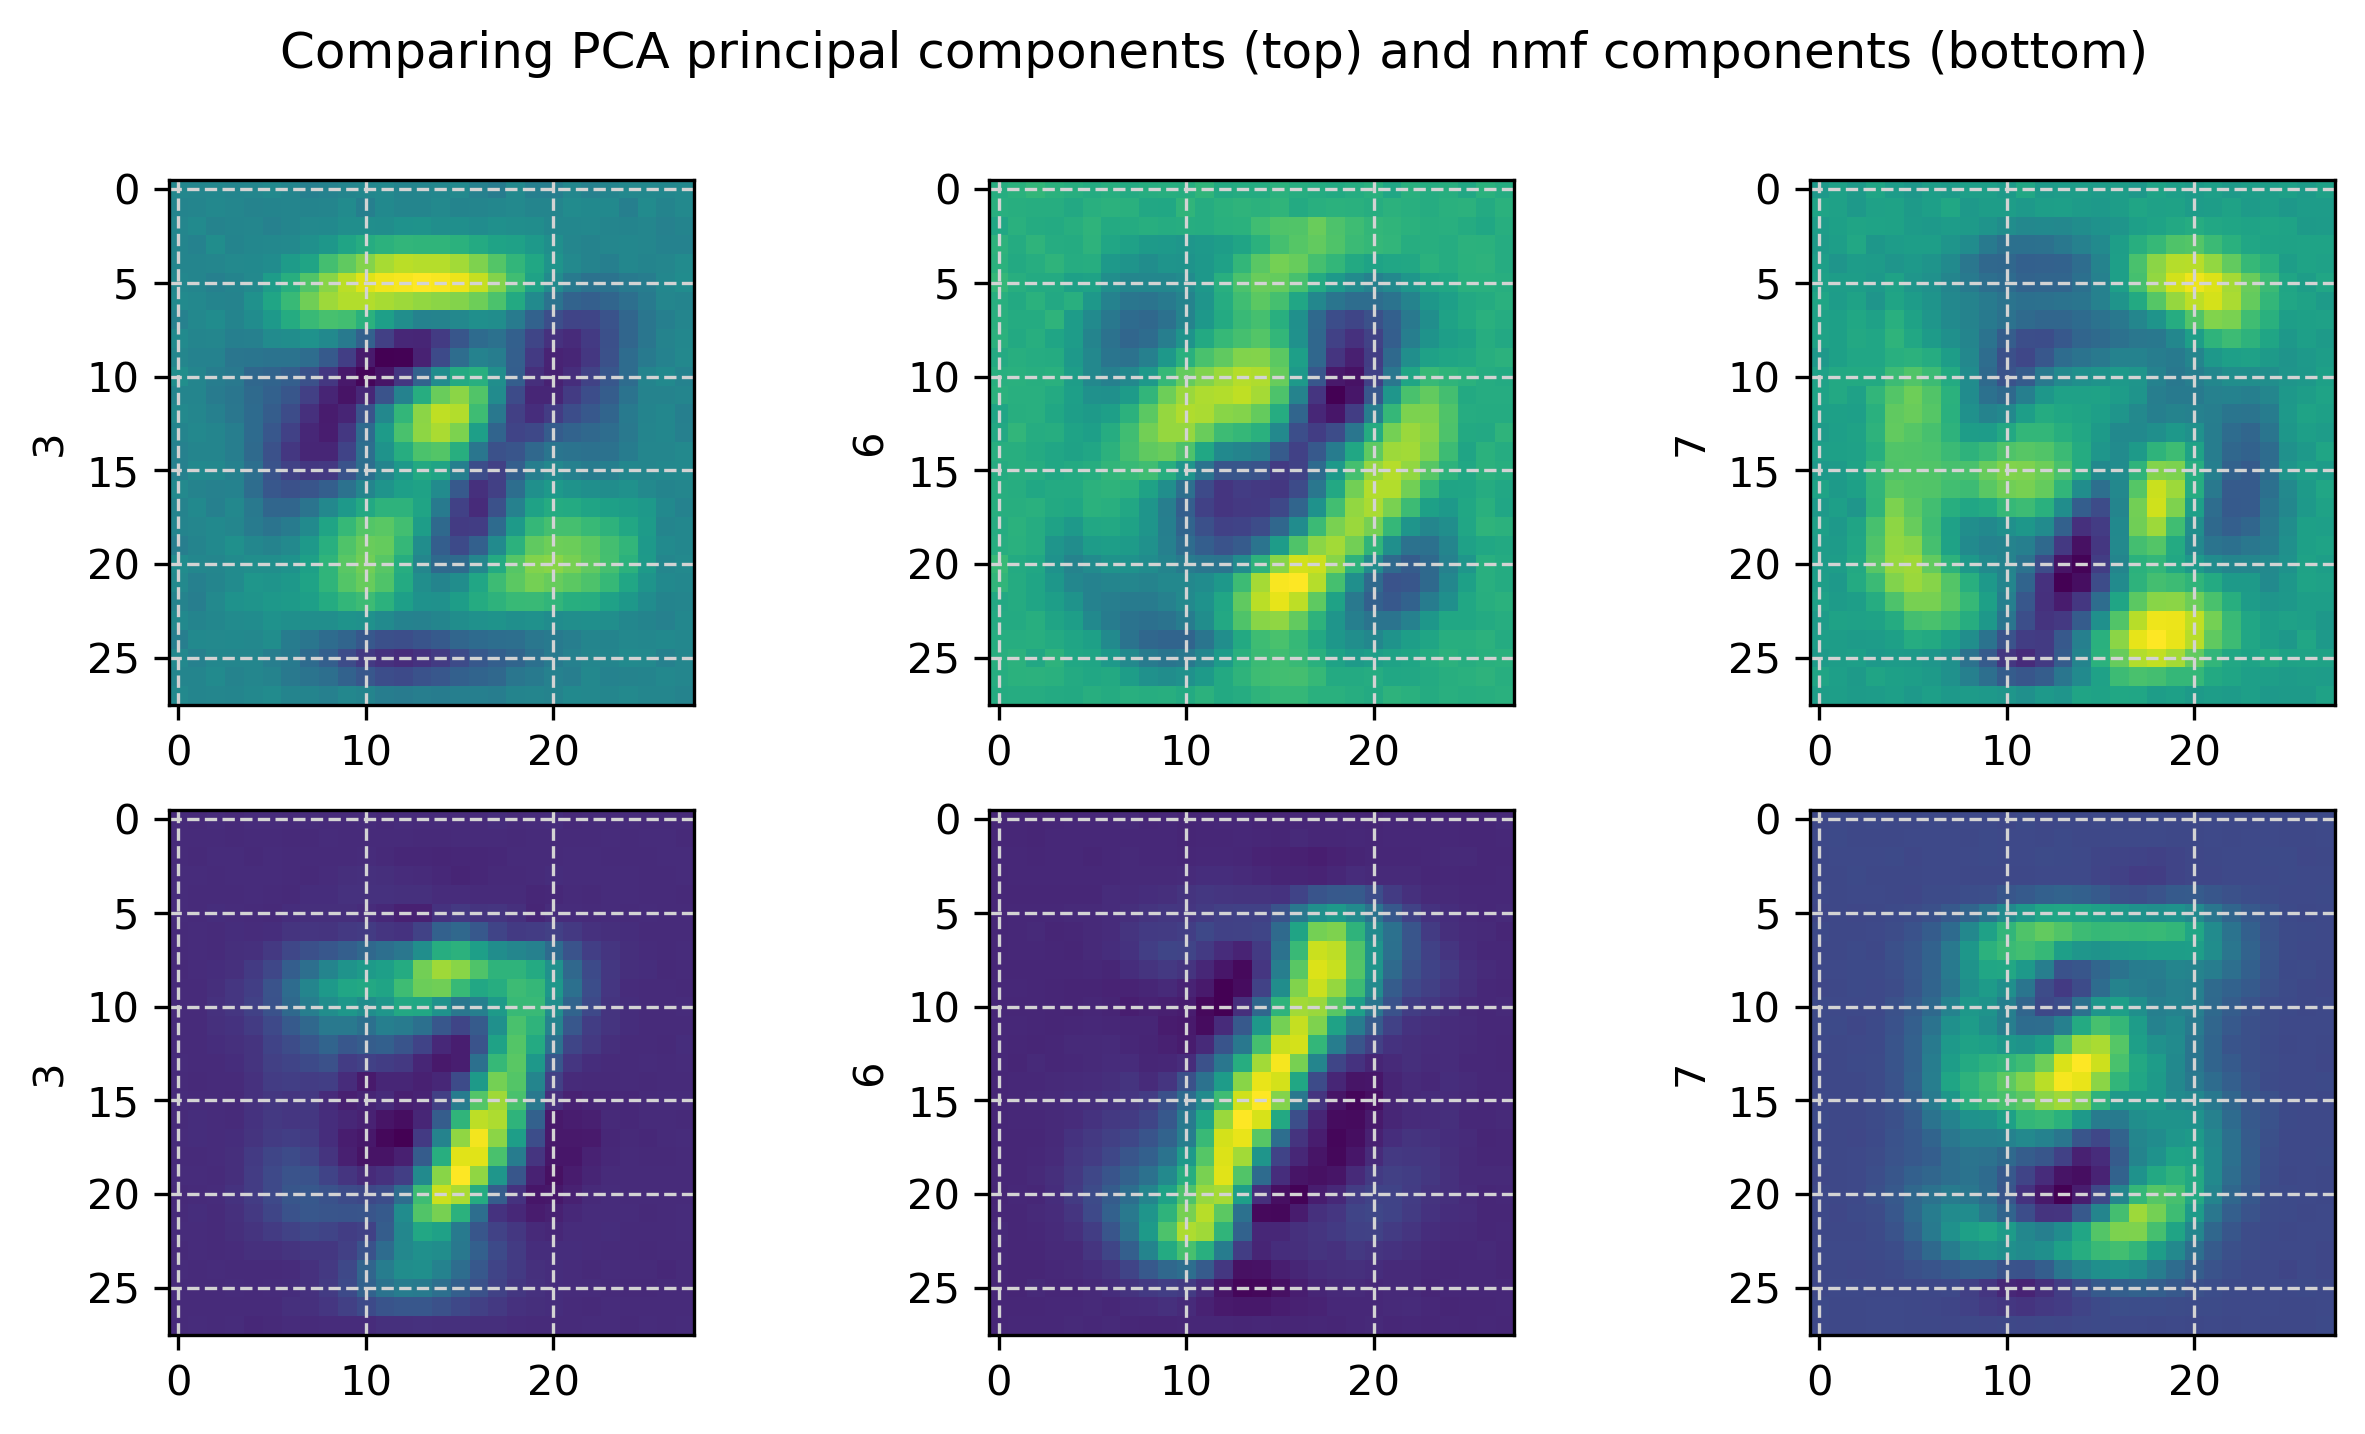

In [57]:
nrow = 2; ncol = 3;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,5))
fig.suptitle('Comparing PCA principal components (top) and nmf components (bottom)')

axs[0,0].imshow(pca_components[:,2].reshape([28,28]))
axs[0,0].set_ylabel('3')

axs[0,1].imshow(pca_components[:,5].reshape([28,28]))
axs[0,1].set_ylabel('6')

axs[0,2].imshow(pca_components[:,6].reshape([28,28]))
axs[0,2].set_ylabel('7')

axs[1,0].imshow(nmf_components[2].reshape([28,28]))
axs[1,0].set_ylabel('3')

axs[1,1].imshow(nmf_components[5].reshape([28,28]))
axs[1,1].set_ylabel('6')

axs[1,2].imshow(nmf_components[6].reshape([28,28]))
axs[1,2].set_ylabel('7')

Comparing the first 10 PCA principal and nmf components, we observe that the nmf components in general resemble single digits more closely than their PCA counterparts. Specifically, the $3^{rd}, 6^{th}$ and $7^{th}$ nmf components resemble the digits 7, 1 and 3 respectively, whereas the PCA ones don't resemble digits at all. This suggests that the nmf factorisation has $\textbf{more interpretability}$ as it learns to reconstruct images based on a basis of images with discernible features, i.e. a digit, or parts of digits. this is in line with the findings of Daniel D. Lee and H. Sebastian Seung in [4].

### 1.2.3

We train PCA and NMF on 'MNIST_train_noisy.txt' to
find the set of principal components in PCA and non-negative components in NMF, using m = 100 for both
PCA and NMF. 

In [58]:
#Train PCA
m = 100
#train data
X = standardise_pca(noise_train_data)

X_pca, eigenvectors, eigenvalues = pca_function(X,m)

In [59]:
#Train NMF
m = 100
#train data
X_nmf = normalize_nmf(noise_train_data)

H, W, losses, convergence_indices = nmf(X_nmf, m, n_iters = 1000)

### Reconstruction Formulas

The covariance matrix $\mathbf C_{\boldsymbol X} = \mathbf X^\top \mathbf X/(n-1)$, of the centered data 
$$
X = \boldsymbol( X)_{N\times p }=\begin{pmatrix}
\boldsymbol x^{(1)} \\
\vdots \\
\boldsymbol x^{(N)}
\end{pmatrix}, 
$$
where the $\boldsymbol x^{(i)}, i = 1, \cdots, N$ are individual images can be diagonalised by the spectral theorem for symmetric matrices. This gives the decomposition, 
$\mathbf C_{\boldsymbol X} = \mathbf V \mathbf L \mathbf V^\top$, where
$$ 
V = \boldsymbol( V)_{p\times p }=\begin{pmatrix}
\boldsymbol \phi^{(1)} \\
\vdots \\
\boldsymbol \phi^{(p)}
\end{pmatrix}, 
$$ is an orthogonal matrix of (normalised) eigenvectors $\phi^{(j)}$ ordered in such a way that $\phi^{(j)}, j = 1, \cdots, p$ corresponds to the $j^{th}$ principal component. We assume that these principal components extracted from the training data capture correlations in all data (seen/unseen) of this type, i.e. images in the MNIST dataset. When considering the first $m$ such principal components, the projection $\hat{Y}$ of any (unseen) centered data 
$$
Y = \boldsymbol( Y)_{M\times p }=\begin{pmatrix}
\boldsymbol y^{(1)} \\
\vdots \\
\boldsymbol y^{(M)}
\end{pmatrix}, 
$$
is easily computed as:
$$
\hat{Y}^{(k)} = \displaystyle \sum_{j=1}^m \left(y^{(k)}\cdot \phi^{(j)}\right) \phi^{(j)}
 = y^{(k)}V^\top_mV_m
$$
Thus, the in matrix form, the reconstructed sample $\hat{Y}_m$ using $m$ principal components are given by:
$$
\hat{Y}_m =  Y V^\top_mV_m,
$$
where 
$$ 
V_m = \boldsymbol( V_m)_{m\times p }=\begin{pmatrix}
\boldsymbol \phi^{(1)} \\
\vdots \\
\boldsymbol \phi^{(m)}
\end{pmatrix}.
$$

Similarly, since NMF (approximately) factors the N-by-p feature matrix $\mathbf X$ into nonnegative factors $\mathbf W$ (N-by-m) and $\mathbf H$ (m-by-p), a matrix of non-negative components
$$
H_m = \boldsymbol(H_m)_{m\times p }=\begin{pmatrix}
\boldsymbol h^{(1)} \\
\vdots \\
\boldsymbol h^{(m)}.
\end{pmatrix}
$$ 
Since $H_m$ has full rank, the weights can be obtained as $W_m\approx X\tilde{H}_m$, by considering the right inverse $\tilde{H}_m$. Extrapolating this relationship to all data in the MNIST set, we form the image reconstructions as:
$$
\hat{Y}_m =  Y \tilde{H}_mH_m,
$$
for $Y$, a set of 'unseen' images.

Upon reconstruction of the images below, in order to make a comparison with the original train and test images, I will perform inverse transforms to bring the image reconstructions to the original scale with pixel values ranging from 0-255.

In [60]:
#noisy test set normalisation
X_test_noise_pca = noise_test_data_std
X_test_noise_nmf = normalize_nmf(noise_test_data)

#noise-free test set normalisation
X_test_pca = standardise_pca(test_data)
X_test_nmf = normalize_nmf(test_data)

In [61]:
#Choosing image from test set
image_index = 10

In [62]:
#noisy reconstructions
image_pixels_pca_noise = X_test_noise_pca[image_index]@eigenvectors@eigenvectors.T
image_pixels_nmf_noise = X_test_noise_nmf[image_index]@np.linalg.pinv(H)@H

#noise-free reconstructions
image_pixels_pca = X_test_pca[image_index]@eigenvectors@eigenvectors.T
image_pixels_nmf = X_test_nmf[image_index]@np.linalg.pinv(H)@H

#inverse transform
image_pixels_pca = inverse_transform_pca(train_data,image_pixels_pca)
image_pixels_pca_noise = inverse_transform_pca(train_data,image_pixels_pca_noise)

#inverse transform
image_pixels_nmf = inverse_transform_nmf(train_data,image_pixels_nmf)
image_pixels_nmf_noise = inverse_transform_nmf(train_data,image_pixels_nmf_noise)

#original noisy image
image_original = test_data[image_index]
image_original_noise = noise_test_data[image_index]

In [63]:
print(f'Chosen Image number in noisy test set: {image_index}\n')
print(f'Corresponding Number: {y_test[image_index]}')

Chosen Image number in noisy test set: 10

Corresponding Number: 9


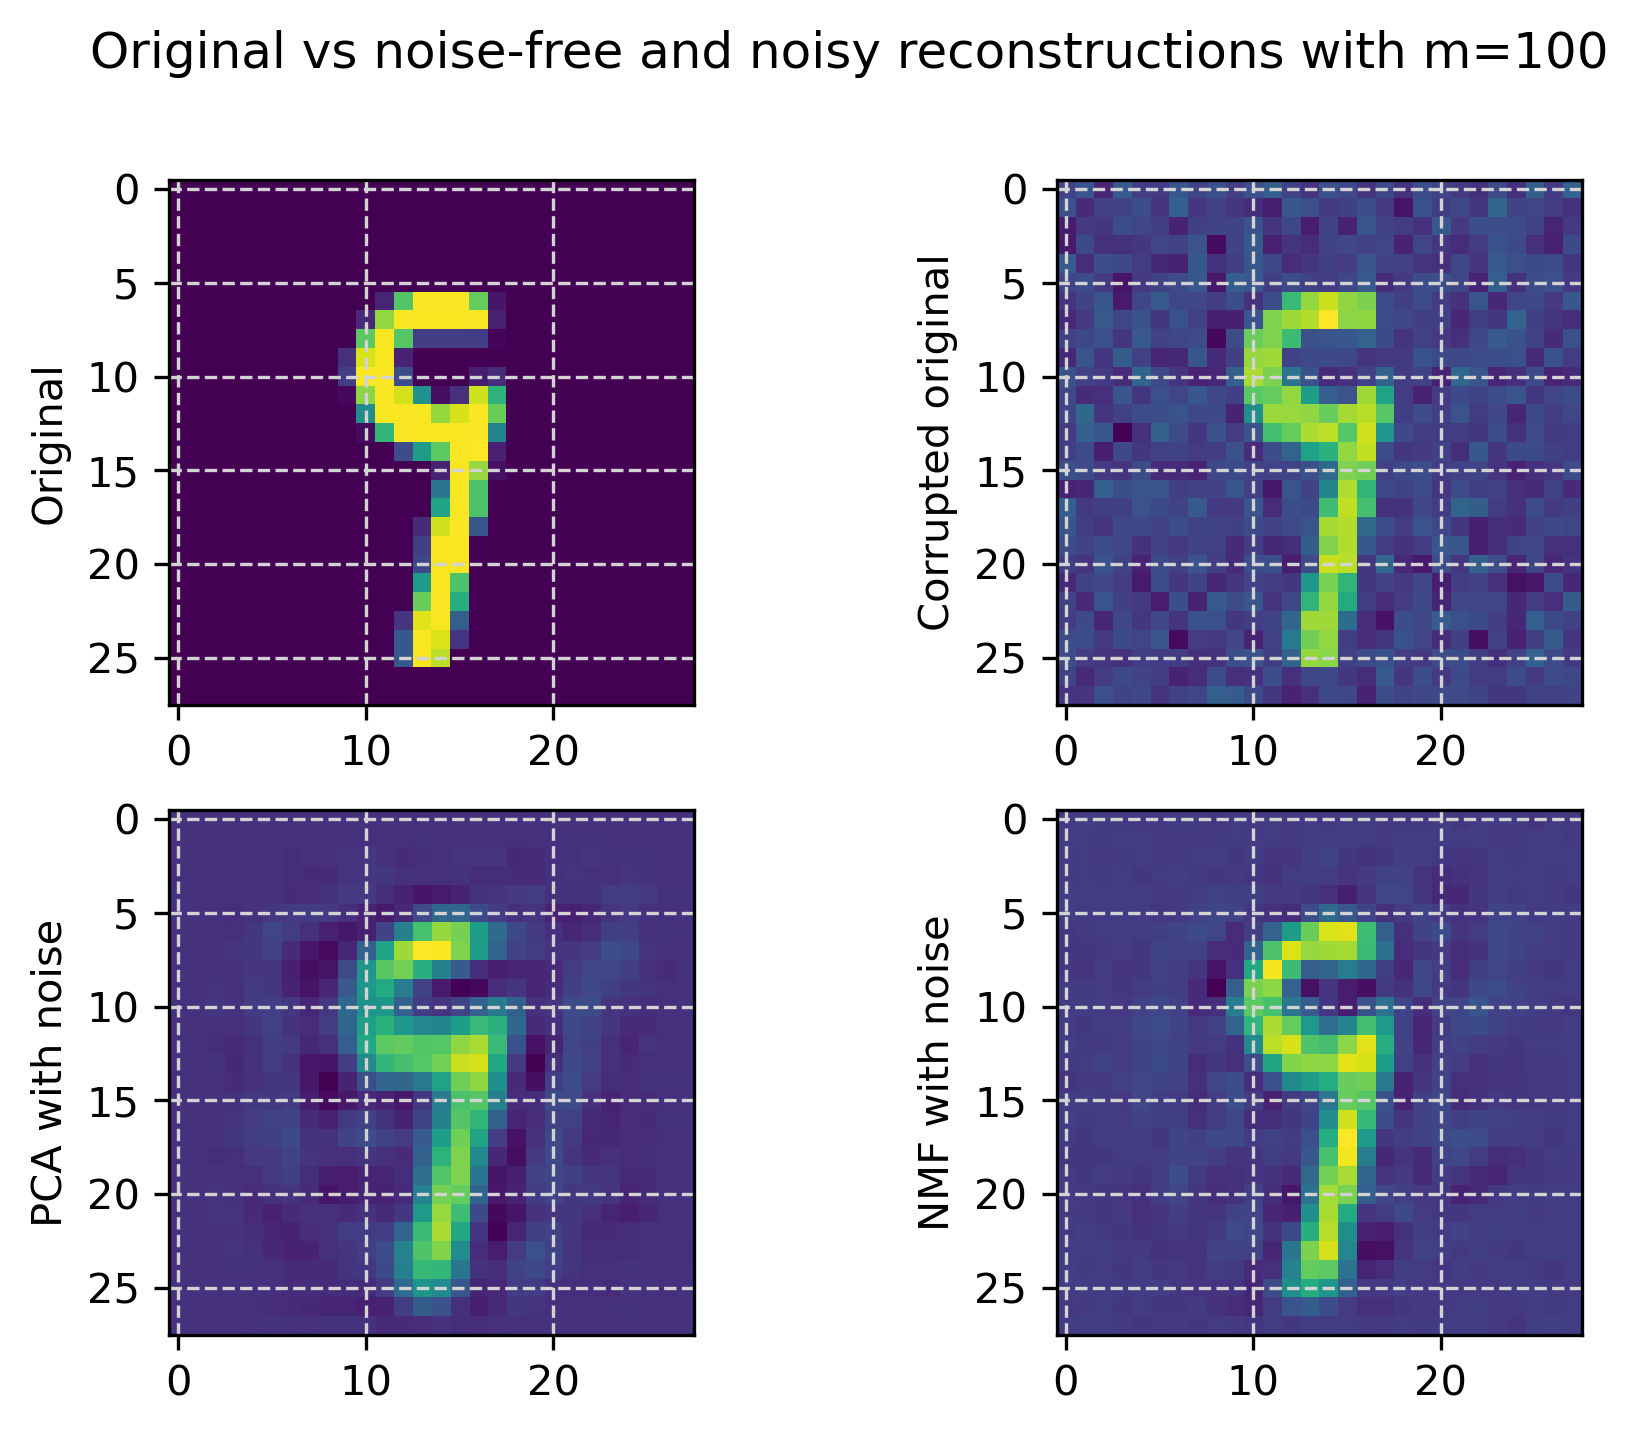

In [64]:
#comparing noisy reconstructions of test set image with original and noisy versions thereof
nrow = 2; ncol = 2;
images = [image_original, image_original_noise, image_pixels_pca_noise, image_pixels_nmf_noise]

titles = ['Original', 'Corrupted original',   'PCA with noise', 'NMF with noise']

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(7,5))
plt.suptitle('Original vs noise-free and noisy reconstructions with m=100')

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(images[i].reshape([28,28]))
    ax.set_ylabel(f'{titles[i]}')

Both PCA and nmf seem to denoise the image above, and remove the background noise present in the corrupted image. However there are some differences to be noted. First, the PCA image reconstruction of the noisy image has retained more noise, that is the digit has not been reproduced with the same 'resolution' as in the nmf reconstriction. Also, there is a more of a pronounced 'halo' with darker pixels in the PCA reconstruction than in the nmf one, matching the dark backround off the uncorrupted original image more closely.

### 1.2.4

In [65]:
def mse_pca(x,y):
    return np.mean((x-y)**2)

In [66]:
def pca_reconstruction_mse(X_train, X_reconstruct, X_test, m_range):
    
    """
    Reconstruct the images in `X_test` using PCA with different number of principal components `m` in `m_range`, 
    and compute the mean squared error (MSE) between the reconstructed images and the original ones.

    Args:
        X_train (np.ndarray): the training set of images, shape (n_train_samples, n_features).
        X_reconstruct (np.ndarray): the set of images to be reconstructed using PCA, shape (n_samples, n_features).
        X_test (np.ndarray): the set of ground-truth images to compute the MSE, shape (n_samples, n_features).
        m_range (Iterable[int]): the range of the number of principal components to use for reconstruction.
    
    Returns:
        images (np.ndarray): the reconstructed images for each value of `m`, shape (len(m_range), n_samples, n_features).
        mse (List[float]): the mean squared error between the reconstructed images and the original ones for each value of `m`.
    """
    
    mse = []
    images = []
    
    for m in tqdm(m_range):
        
        #Train PCA model on train data

        X_pca, eigenvectors, eigenvalues = pca_function(X_train,m)
                
        # test set image reconstructions using PCA with m principal components

        images_pca = X_reconstruct@eigenvectors@eigenvectors.T
        
        #compute mse between reconstructed image and original
        error = mse_pca(images_pca, X_test)
        mse.append(error)
        images.append(images_pca)
        
    return np.array(images), mse

In [67]:
m_range = np.arange(5,401,5)
#standardising data
X_train = standardise_pca(train_data)
X_train_noise = standardise_pca(noise_train_data)
X_test = standardise_pca(test_data)
X_test_noise = standardise_pca(noise_test_data)

mse_noise_free = pca_reconstruction_mse(X_train_noise, X_test_noise, X_test, m_range)[1]

mse_with_noise = pca_reconstruction_mse(X_train_noise, X_test_noise, X_test_noise, m_range)[1]

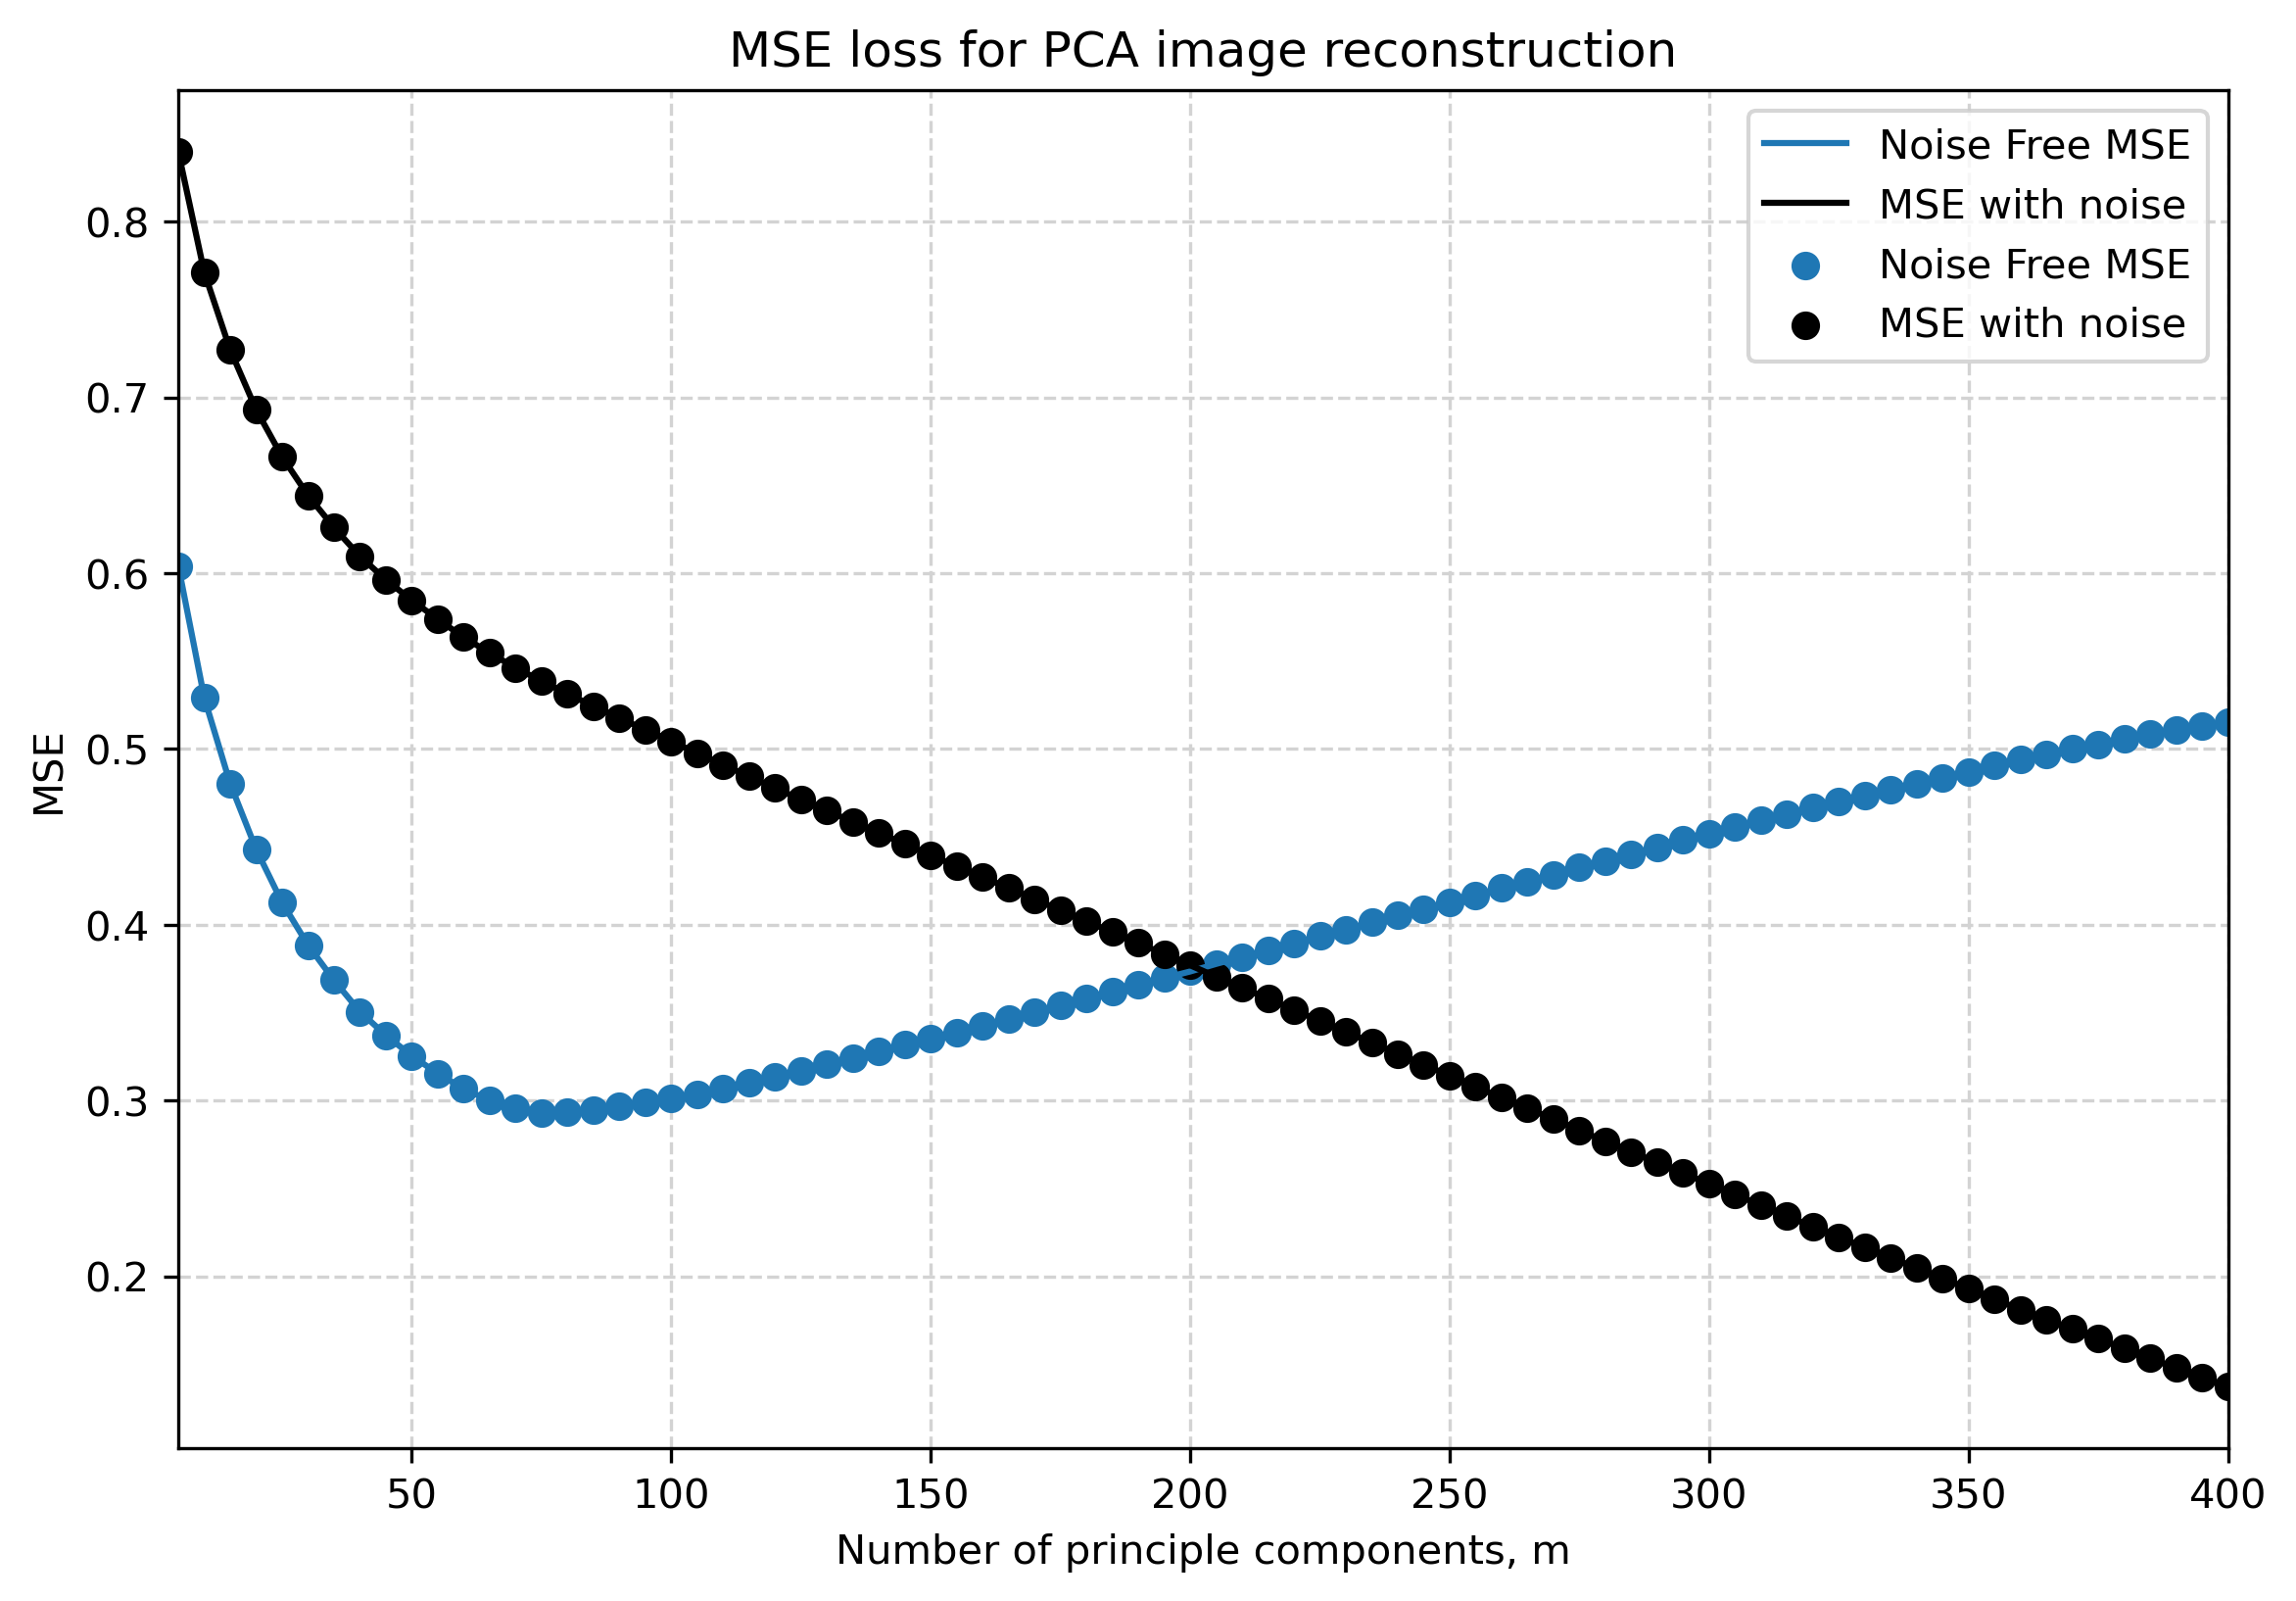

In [68]:
#PLotting mses
plt.title('MSE loss for PCA image reconstruction')
plt.plot(m_range, mse_noise_free, label = 'Noise Free MSE')
plt.scatter(m_range, mse_noise_free, label = 'Noise Free MSE')
plt.plot(m_range, mse_with_noise, label = 'MSE with noise', color = 'black')
plt.scatter(m_range, mse_with_noise, label = 'MSE with noise', color = 'black')
plt.ylabel('MSE')
plt.xlabel('Number of principle components, m')
plt.xlim([5,400])
plt.legend(loc = 'upper right')

In [69]:
#noise-free etst set image reconstruction
images, mse = pca_reconstruction_mse(X_train_noise, X_test_pca, X_test_pca, [10, 40, 100, 200])
images = images[:,0,:]
images = [inverse_transform_pca(train_data, image) for image in images]

images = np.concatenate(( images, [test_data[0]]))

#noisy test set reconstruction
images_noise, mse_noise = pca_reconstruction_mse(X_train_noise, X_test_noise_pca, X_test_noise_pca, [10, 40, 100, 200])
images_noise = images_noise[:,0,:]
images_noise = [inverse_transform_pca(noise_train_data, image) for image in images_noise]
images_noise = np.concatenate(( images_noise, [noise_test_data[0]]))

images_combined = np.concatenate((images, images_noise))

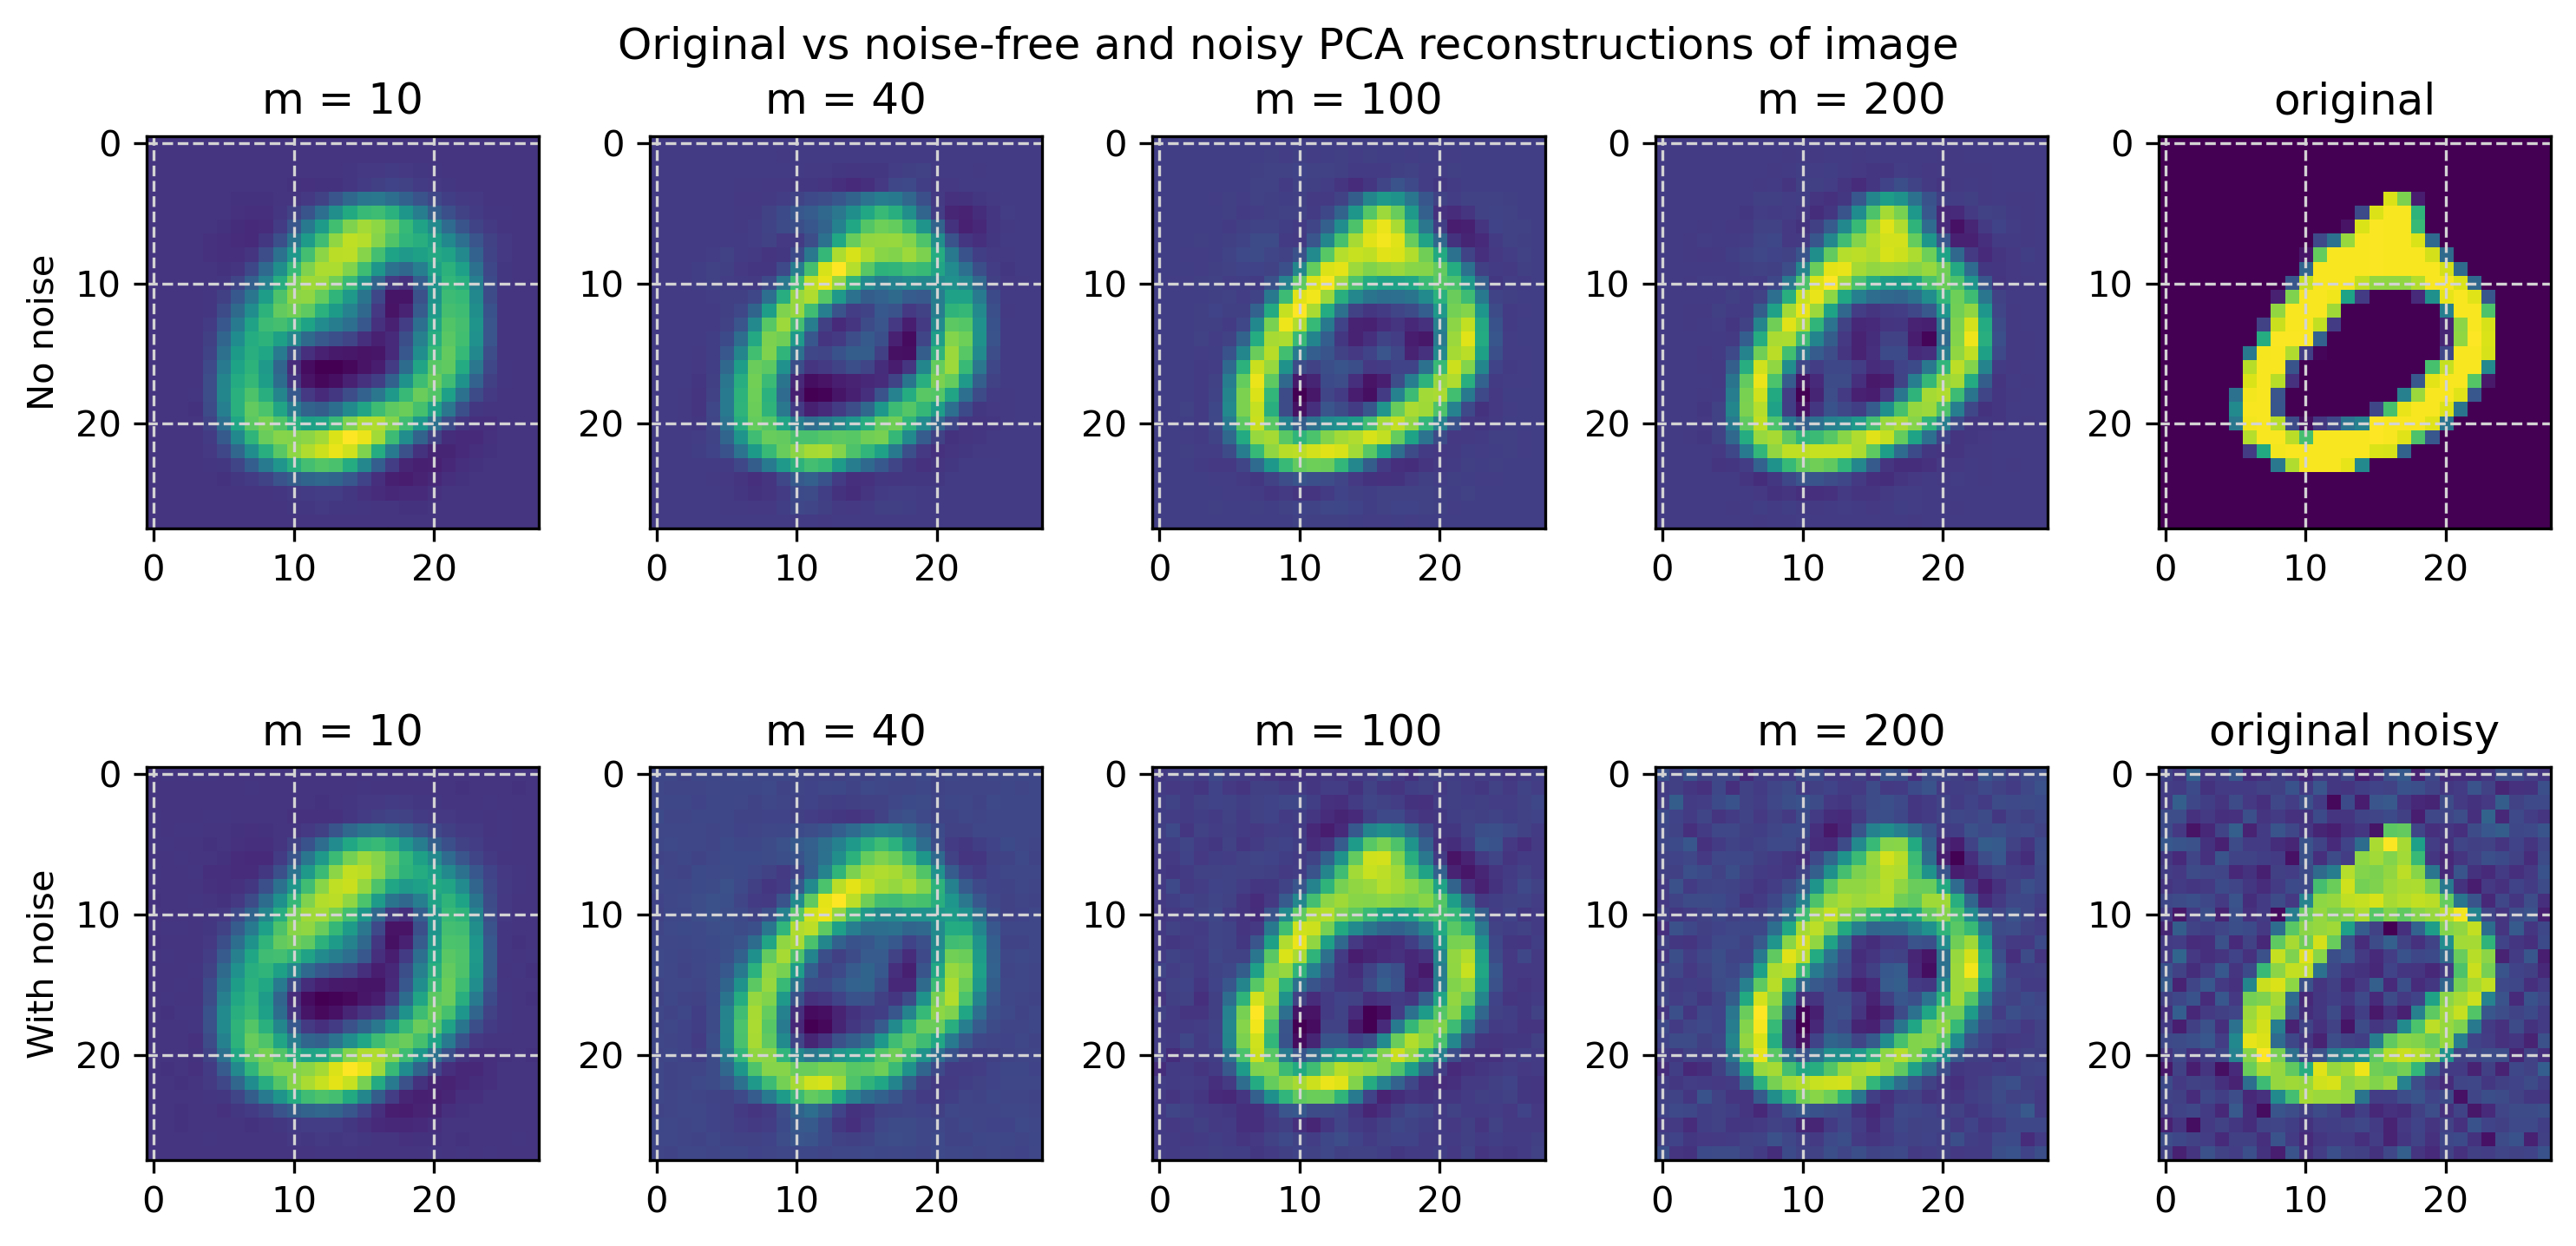

In [70]:
nrow = 2; ncol = 5;

titles = ['m = 10', 'm = 40', 'm = 100', 'm = 200', 'original', 'm = 10', 'm = 40', 'm = 100', 'm = 200', 'original noisy']

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,5))
plt.suptitle('Original vs noise-free and noisy PCA reconstructions of image')

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(images_combined[i].reshape([28,28]))
    ax.set_title(f'{titles[i]}')
    if i == 0:
        ax.set_ylabel('No noise')
    if i == 5:
        ax.set_ylabel('With noise')
fig.tight_layout()

### Analysis of MSEs and PCA image denoisng

By observing the above plot, we note that the MSE between the reconstructions of the noisy images and themselves (black) is greater than the MSE of the noisy images and their uncorrupted versions (blue) with the PCA model trained for principal components less than 200, where the errors coincide. Thereafter, the reverse behaviour is observed, with the noisy MSE steadily decreasing, and the noise-free MSE plateauing. 

This is no surprise, as the PCA reocnstruction of the corrupted image using m principal components is simply a projection onto an increasing sequence of eigenspaces that eventually stabilise to the entire space, by virtue of the principal components being an eigenbasis of the covariance matrix, which has the same number of dimensions as the images, when arranged as arrays. Thus, we expect the MSE to decrease monotinically to zero.

On the other hand, the above implies that the reconstructions of the noisy images converge to the noisy image, thus the MSE between the above recontruction and the original uncorrupted image should plateau to the MSE of between the original corrupted and uncorrupted images. 

Finally note that up to the first 75 principal components, the PCA reconstruction produces an increasingly faithful, denoised representation of the original image with the MSE steadily decreasing. Principal components larger than 75 only contribute to higher MSEs due to $\textbf{overfitting}$, as the model begins to capture the noise from the corrupted image.

This behaviour is reflected in the following plot comparing the PCA image denoising applied to one image. in particular, as the reconstructions of the uncorrupted image converge to the original (top row), the reconstructions of the noisy image first match the reconstructions of the original at m = 40 principal components. Thereafter as noise is captured by the PCA model, for m = 100, 200, the reconstructions start to deviate from the original.

### 1.3 Gaussian Mixture Models (20 marks)


In [71]:
np.random.seed(7654567)

#### 1.3.1

We use the first five principal components of the PCA on the first N=1000 images of the dataset
'MNIST_train.csv' to perform clustering using a Gaussian Mixture Model with 10 hidden components. For a set of continuous observed variables $X$, in our case the standardised images, the model associates the categorical latent  variable $Z$. More specifically, a Gaussian Mixture Model (GMM) consists of mixture  components:
$$
P(\boldsymbol{X}=\boldsymbol{x}_i|Z=k, \boldsymbol{\theta}) = p_k(\boldsymbol{x}_i|\boldsymbol{\theta})
$$
and mixture weights:
$$
P(Z = k) = \pi_k
$$
$$
P(\boldsymbol{X}=\boldsymbol{x}) = \sum_{k=1}^K \pi_k p_k(\boldsymbol{x}|\boldsymbol{\theta})\, .
$$
Here $K$ is the number of clusters described as mixture components, each of which are multivariate normal distributions with density:
$$
p_k(\boldsymbol{x}|\boldsymbol{\theta}) = {\displaystyle (2\pi )^{-k/2}\det({\boldsymbol {\Sigma }_k})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {\mu }_k})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }_k}^{-1}(\mathbf {x} -{\boldsymbol {\mu }_k})\right),}
$$
where $\boldsymbol{\theta} = \{\pi_k,\mu_k, \Sigma_k \}_{k=1,2,...,K}$ is the vectors of parameters consiting of the mixture weight $\pi_k$, mixture component mean $\boldsymbol{\mu}_k$ and mixture component covariance matrix $\boldsymbol{\mu}_k$.

We can perform 'soft' clustering of the data using the cluster probabilities of the data using Bayes' rule:
$$r_{ik}(\boldsymbol{\theta})=P(Z=k|\boldsymbol{X}=\boldsymbol{x}_i,\boldsymbol{\theta}) = \frac{\pi_k p_k(\boldsymbol{x}_i|\boldsymbol{\theta})}{\sum_{k'=1}^K \pi_{k'} p_{k'}(\boldsymbol{x}_i|\boldsymbol{\theta})}$$
This yields a distribution over each data point, denoting the probability of said data point to belong to cluster $k$.

In [72]:
class GMModel:
    """
    A class to define a Gaussian Mixture Model.
    
    Attributes:
    dim (int): The number of mixture components.
    pi (numpy.ndarray): The mixture weights.
    mu (list): The mixture component means for each cluster.
    sigma (list): The mixture component covariance matrix for each cluster.
    
    Methods:
    __init__(X, dim): Initializes parameters through random split of the data.
    """
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in pi or P(Ci=j)
        self.pi = np.full(shape=self.dim, fill_value=1/self.dim) 
    
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size = self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 


In [73]:
def cluster_probabilities(gmm, X):
    """
    Predicts the probability of each data point with respect to each cluster in a Gaussian Mixture Model.
    
    Args:
    gmm (GMModel): The Gaussian Mixture Model to use for the prediction.
    X (numpy.ndarray): The input data matrix of shape (n_samples, n_features).
        
    Returns:
    weights (numpy.ndarray): The matrix of predicted probabilities of shape (n_samples, n_clusters).
    """

    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) 
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.pi.reshape(1,-1)
        denominator = numerator.sum(axis=1).reshape(-1,1)
        weights = numerator / (denominator+1e-10)
    return weights

In [74]:
def predict(gmm, X):
    """
    Performs hard clustering
    """
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1)

In [75]:
#Train PCA with first 5 principal components
m = 5
#train data
X_train_gmm = standardise_pca(train_data[:1000])
X_pca, eigenvectors, eigenvalues = pca_function(X_train_gmm,m)

In [76]:
# Initialise Gaussian Mixture Model with 10 hidden components
X_gmm = X_pca
gmm_10 = GMModel(X_gmm,10)

We employ the EM algorithm to fit the data. The algorithm iteratively updates parameters of the Gausian Mixture. In each iteartion, the new likelihood obtained is guaranteed to be greater or equal to the previous one.

Given the current values of the model parameters $\{\pi_k^{(n)},\boldsymbol \mu^{(n)}, \boldsymbol \Sigma^{(n)}\}_{k = 1,\cdots, K}$, we first perform the $\textbf{Expectation}$ step where we obtain the weights from the cluster probabilities:
$$
w_{ik}(\boldsymbol{\theta}^{(n)})=\frac{r_{ik}(\boldsymbol{\theta}^{(n)})}{\sum_{i'} r_{i'k}(\boldsymbol{\theta}^{(n)})}.
$$
Next, we perform the $\textbf{Maximisation}$, wherein we update the model parameters by applying the following update rules:
>$$
	\pi_k^{(n+1)} = \frac{1}{N}\sum_{i=1}^N r_{ik}(\boldsymbol{\theta}^{(n)}),
$$
>$$	\boldsymbol{\mu}_k^{(n+1)} =\sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) \boldsymbol{x}_i$$
>$$\boldsymbol{\Sigma}_k^{(n+1)}= \sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) (\boldsymbol{x}_i-\boldsymbol{\mu}_k) (\boldsymbol{x}_i-\boldsymbol{\mu}_k)^T.$$

We now implement this algorithm below:

In [77]:
def fitStep(gmm,X):
    
    """
    Performs one iteration of the Expectation-Maximization algorithm to update the Gaussian Mixture Model parameters.
    
    Args:
    gmm (GMModel): The Gaussian Mixture Model to update.
    X (numpy.ndarray): The input data matrix of shape (n_samples, n_features).
        
    Returns:
    None
    """
    
    # E-Step: update weights and pi holding mu and sigma constant
    weights =  cluster_probabilities(gmm,X)
    gmm.pi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights = (weight/total_weight).flatten(), bias=True)

In [78]:
#Train 'until convergence'
for _ in trange(1000):
    fitStep(gmm_10,X_gmm)

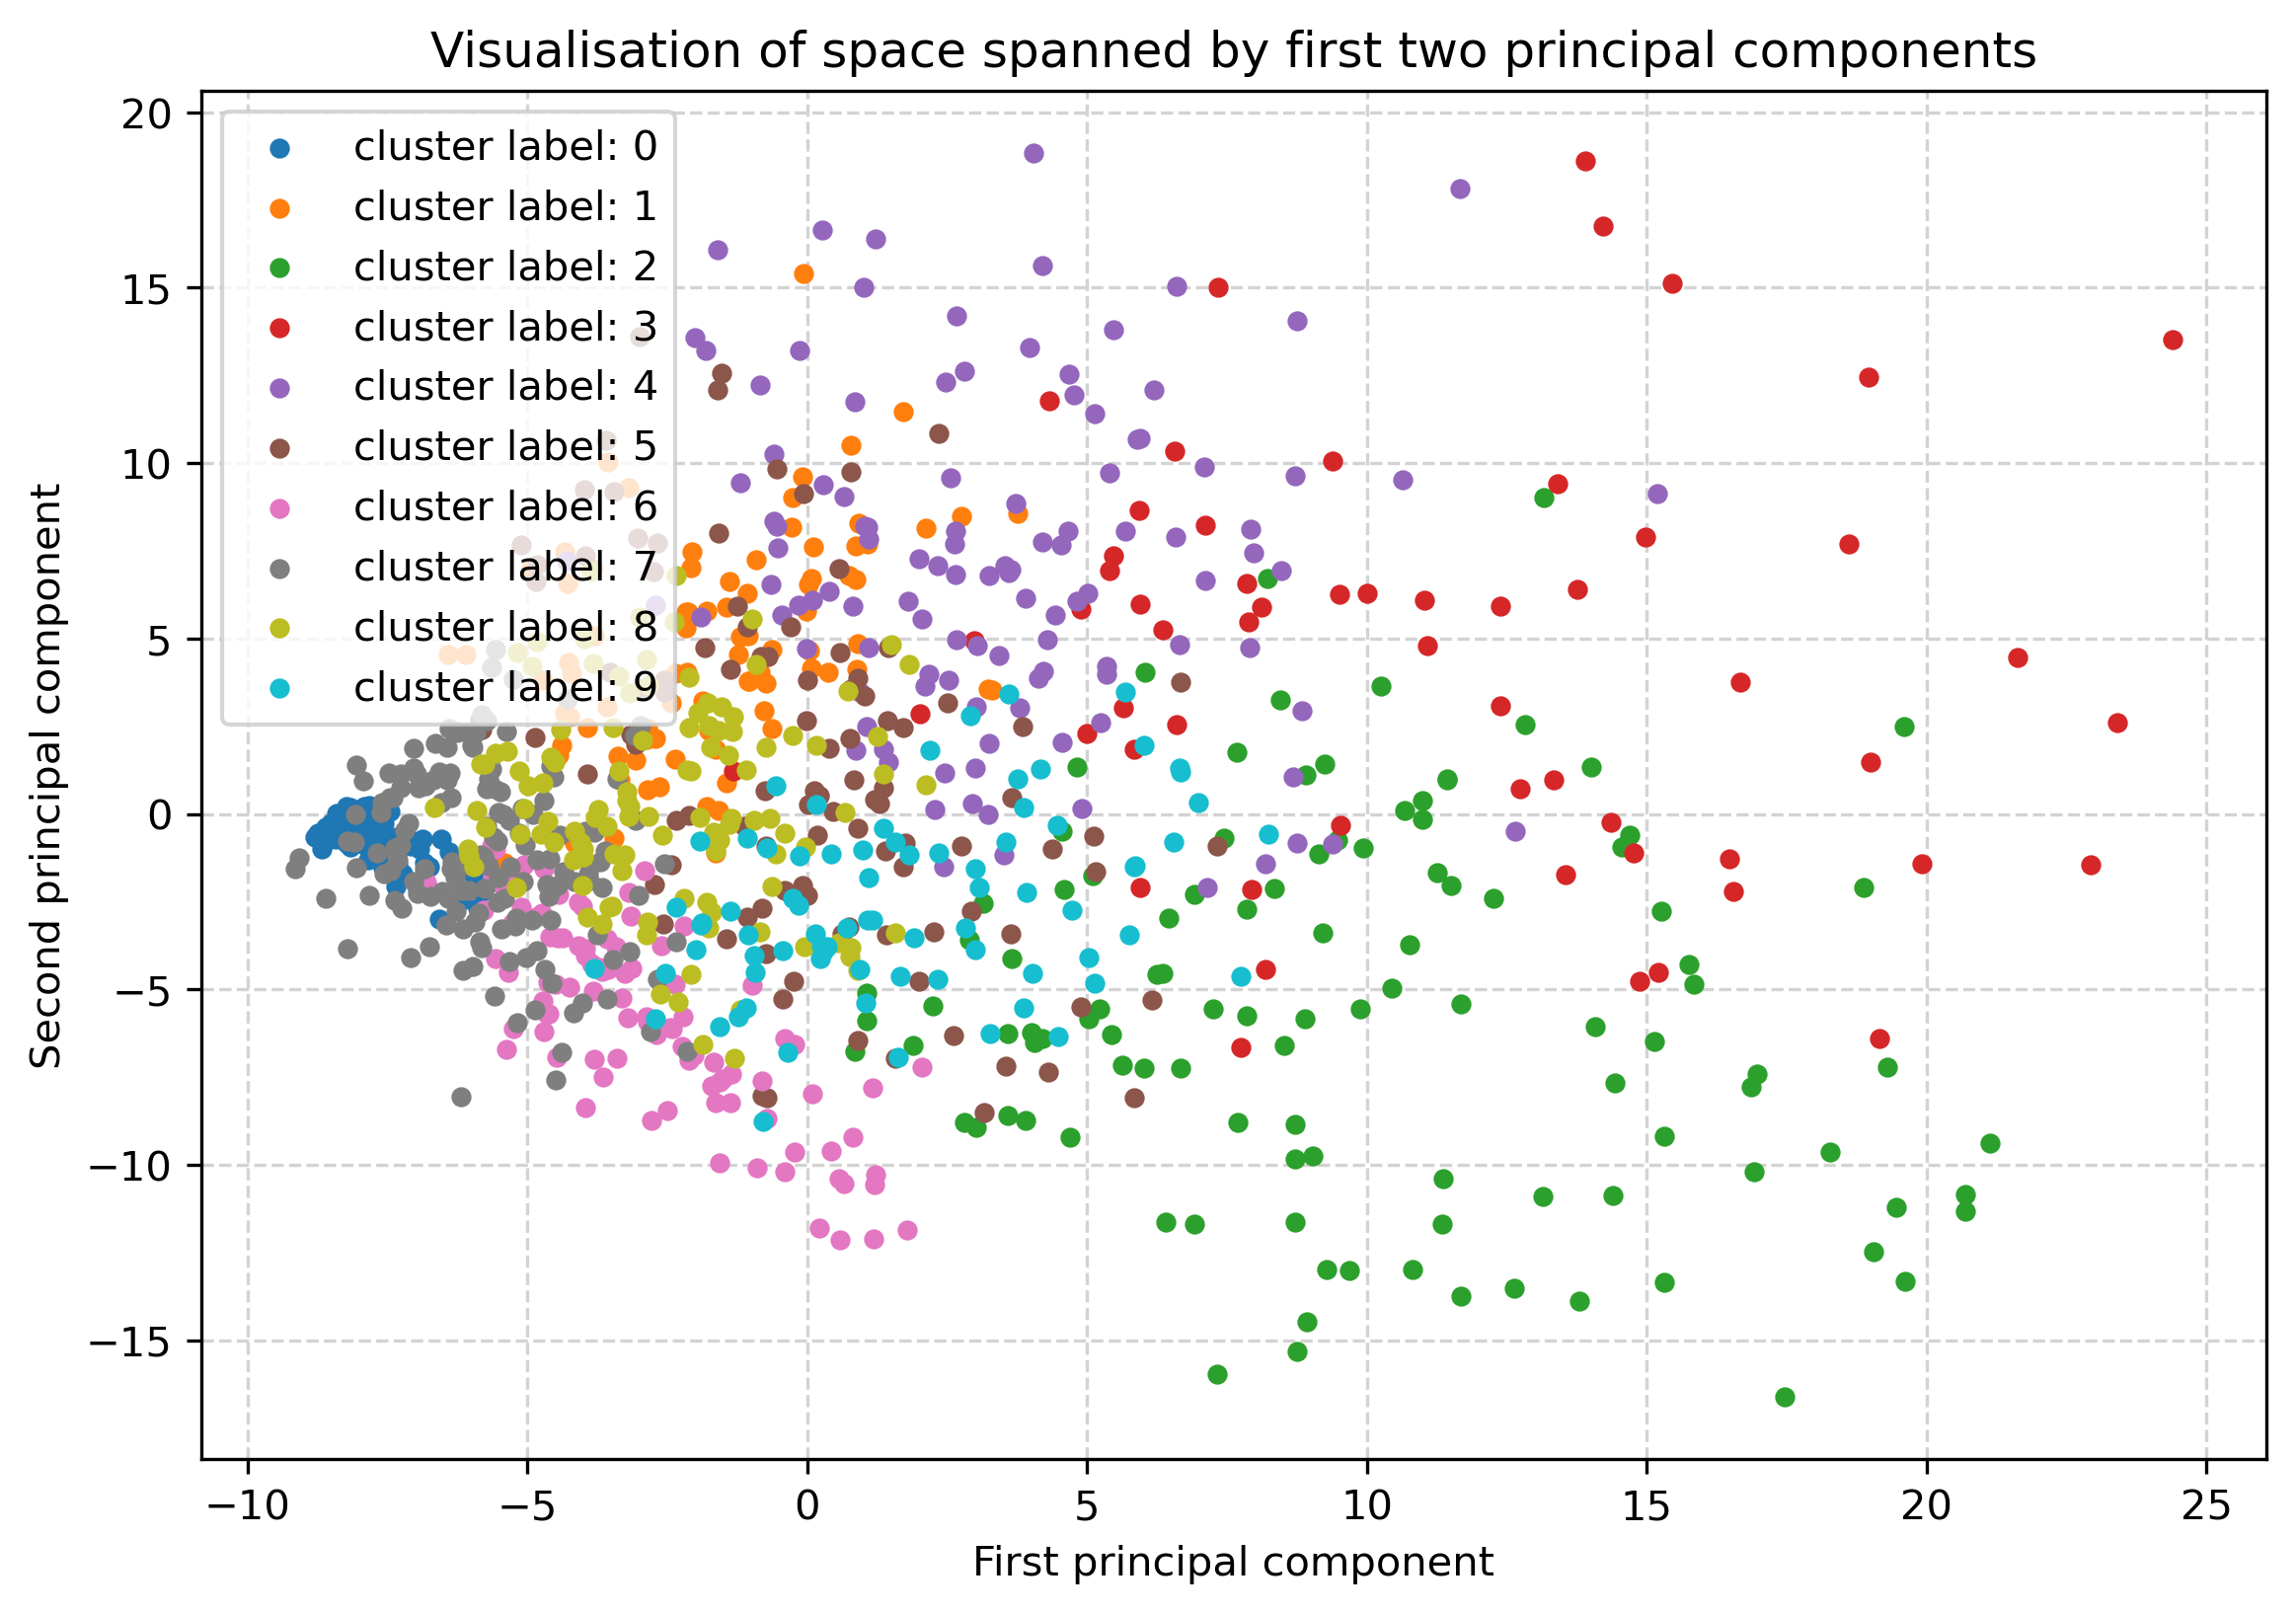

In [79]:
#Plotting first two principal components
preds_10 = predict(gmm_10, X_gmm)

for c in np.unique(preds_10):
    plt.scatter(X_gmm[:, 0][preds_10==c],X_gmm[:, 1][preds_10==c],label=f'cluster label: {c}', s = 15);
plt.title('Visualisation of space spanned by first two principal components')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend(loc = 'upper left')

### 1.3.2

Text(0, 0.5, 'Second principal component')

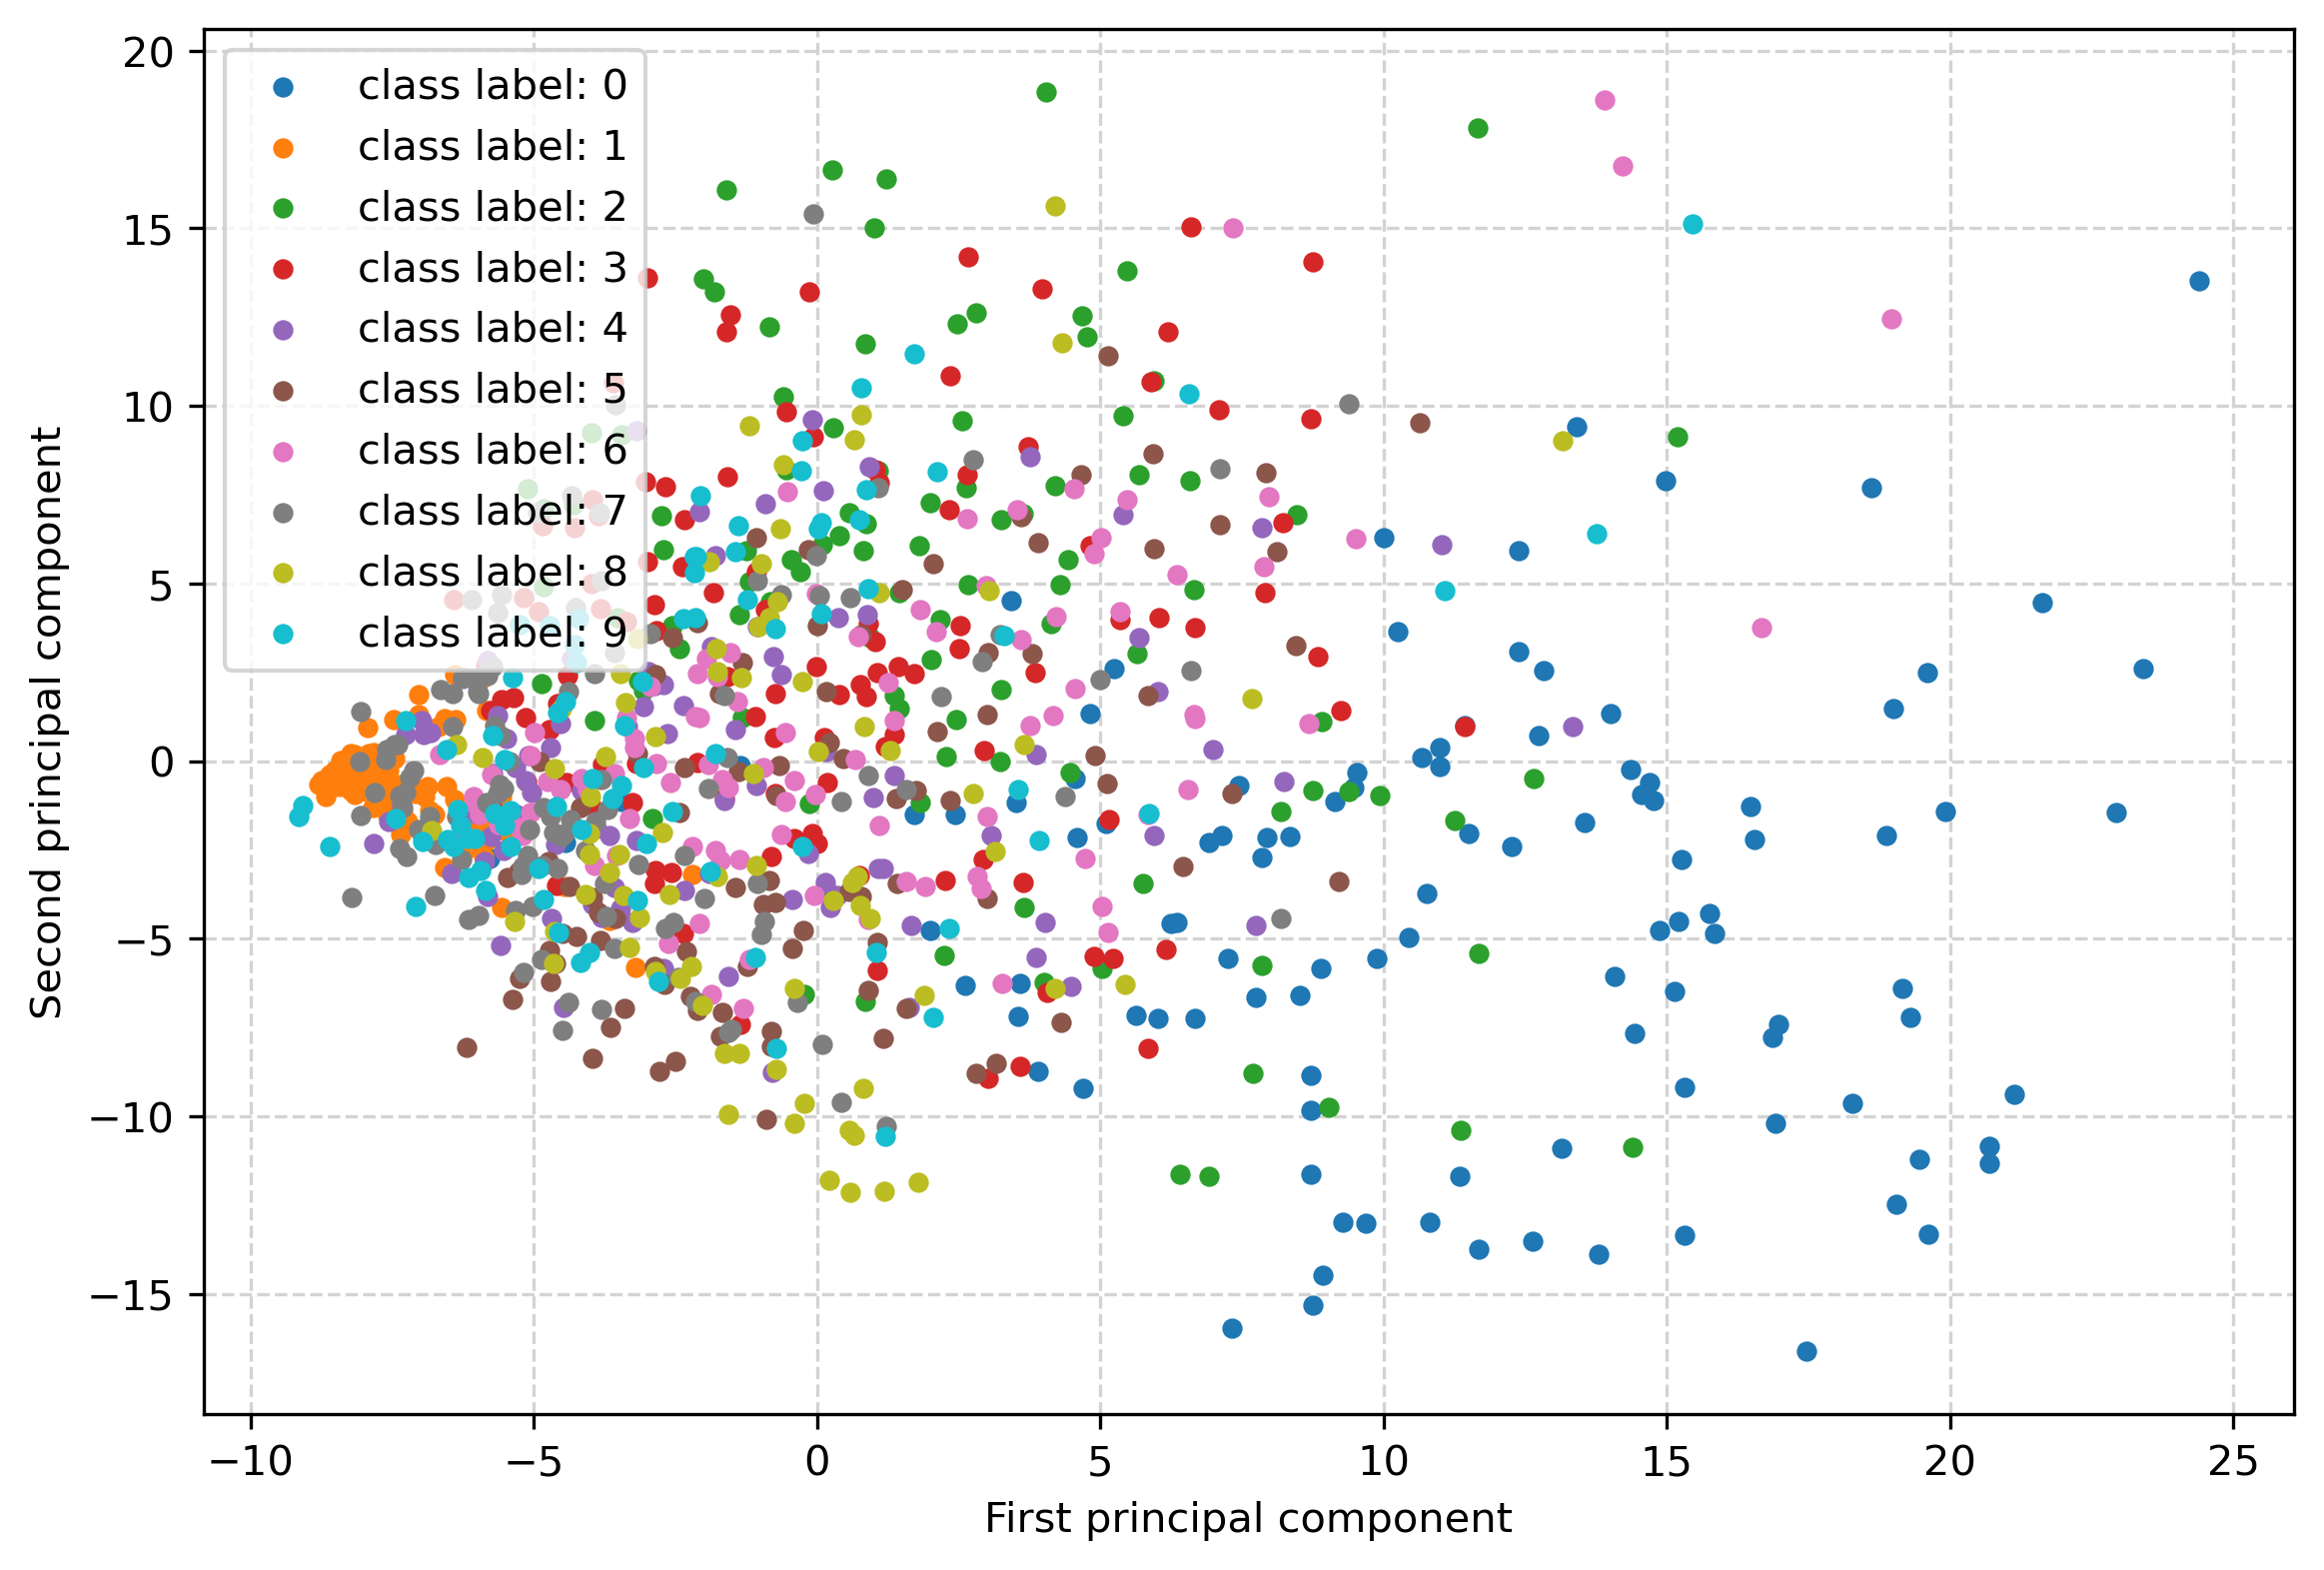

In [80]:
#plotting the first two princaipal components, where each points is coloured according to its ground truth label
y = y_train[:1000]
labels = np.unique(y)

for c in np.unique(y):
    plt.scatter(X_gmm[:, 0][y==c],X_gmm[:, 1][y==c],label = f'class label: {c}', s = 15);
plt.legend(loc = 'upper left')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

We use the log-likelihood of each mixture component evaluated at the images in each
class to measure the fit quality. Assuming independence, between samples, this log-likelihood is computed as:

$$ 
\text{Log-likelihood}\left(\text{Class label} =  i | M_k \right) = \displaystyle\sum_{ x\in X: y(x) = i}\log p_k(x),
$$

with $p_k(x)$ as above, $X$ is the design matrix, $Y_i$ a collection of samples with labels, $y$ the map between samples and their class labels and $M_i$ denoting the $k^{th}$ mixture componet.

In [81]:
def assign_label(gmm,X,y):
    """
    Performs one iteration of the Expectation-Maximization algorithm to update the Gaussian Mixture Model parameters.
    
    Args:
    gmm (GMModel):
        The Gaussian Mixture Model to update.
    X (numpy.ndarray): The input data matrix of shape (n_samples, n_features).
        
    Returns:
    None
    """
    vals = []
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a matrix denoting likelihood belonging to each cluster/hidden component 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) 
        likelihood[:,i] = distribution.pdf(X)
    log_likelihood = np.log(likelihood+1e-10)
    
    for label in np.unique(y): 
        #compute the log-likelihood of each mixture component evaluated at the images in each class
        log_likelihood_total = np.sum(log_likelihood[np.where(y == label)], axis = 0).reshape(1,-1)   
        val = np.argmax(log_likelihood_total)
        vals.append(val)
    return np.array(vals)

In [82]:
#reassigning labels
mapped_preds_10 = assign_label(gmm_10, X_gmm, y)
print(f'mapped predictions:\n {mapped_preds_10}')

mapped predictions:
 [2 0 4 5 9 5 8 7 5 1]


First, we note that the map is $\textbf{not bijective}$, meaning that different ground truth labels get mapped to the same mixture component, for example labels 3,5 get mapped to mixture component 5. Further, note that the labels with points whose first two principal components couster heavily on the periphery, namely, 0 and 1, get mapped to mixture components 2 and 0 respectively. We also see that for such labels, the mixture components are largely homogeneous, containing mostly points of a single ground truth label. However, the remaining mixture components are not homogeneous in terms of the labels they contain, and there is no obvious clustering of their first two principle components.

This seems to suggest that 5 principal components do not capture all of the correlations between the data effectively, thereby reducing the interpretability/certainty of the clustering produced by the GMM.

#### 1.3.3

We now compute the cluster probabilities for each digit using the label-cluster index map 

In [83]:
#Compute cluster probabilities for each digit
y = y_train[:1000]
cluster_probs_10 = np.array([cluster_probabilities(gmm_10,X_gmm)[i, mapped_preds_10[y[i]]] for i in range(len(y))])

For each class, we visualise the space spanned by the top two components by colouring each point according to the cluster probability of the best-fitting cluster:

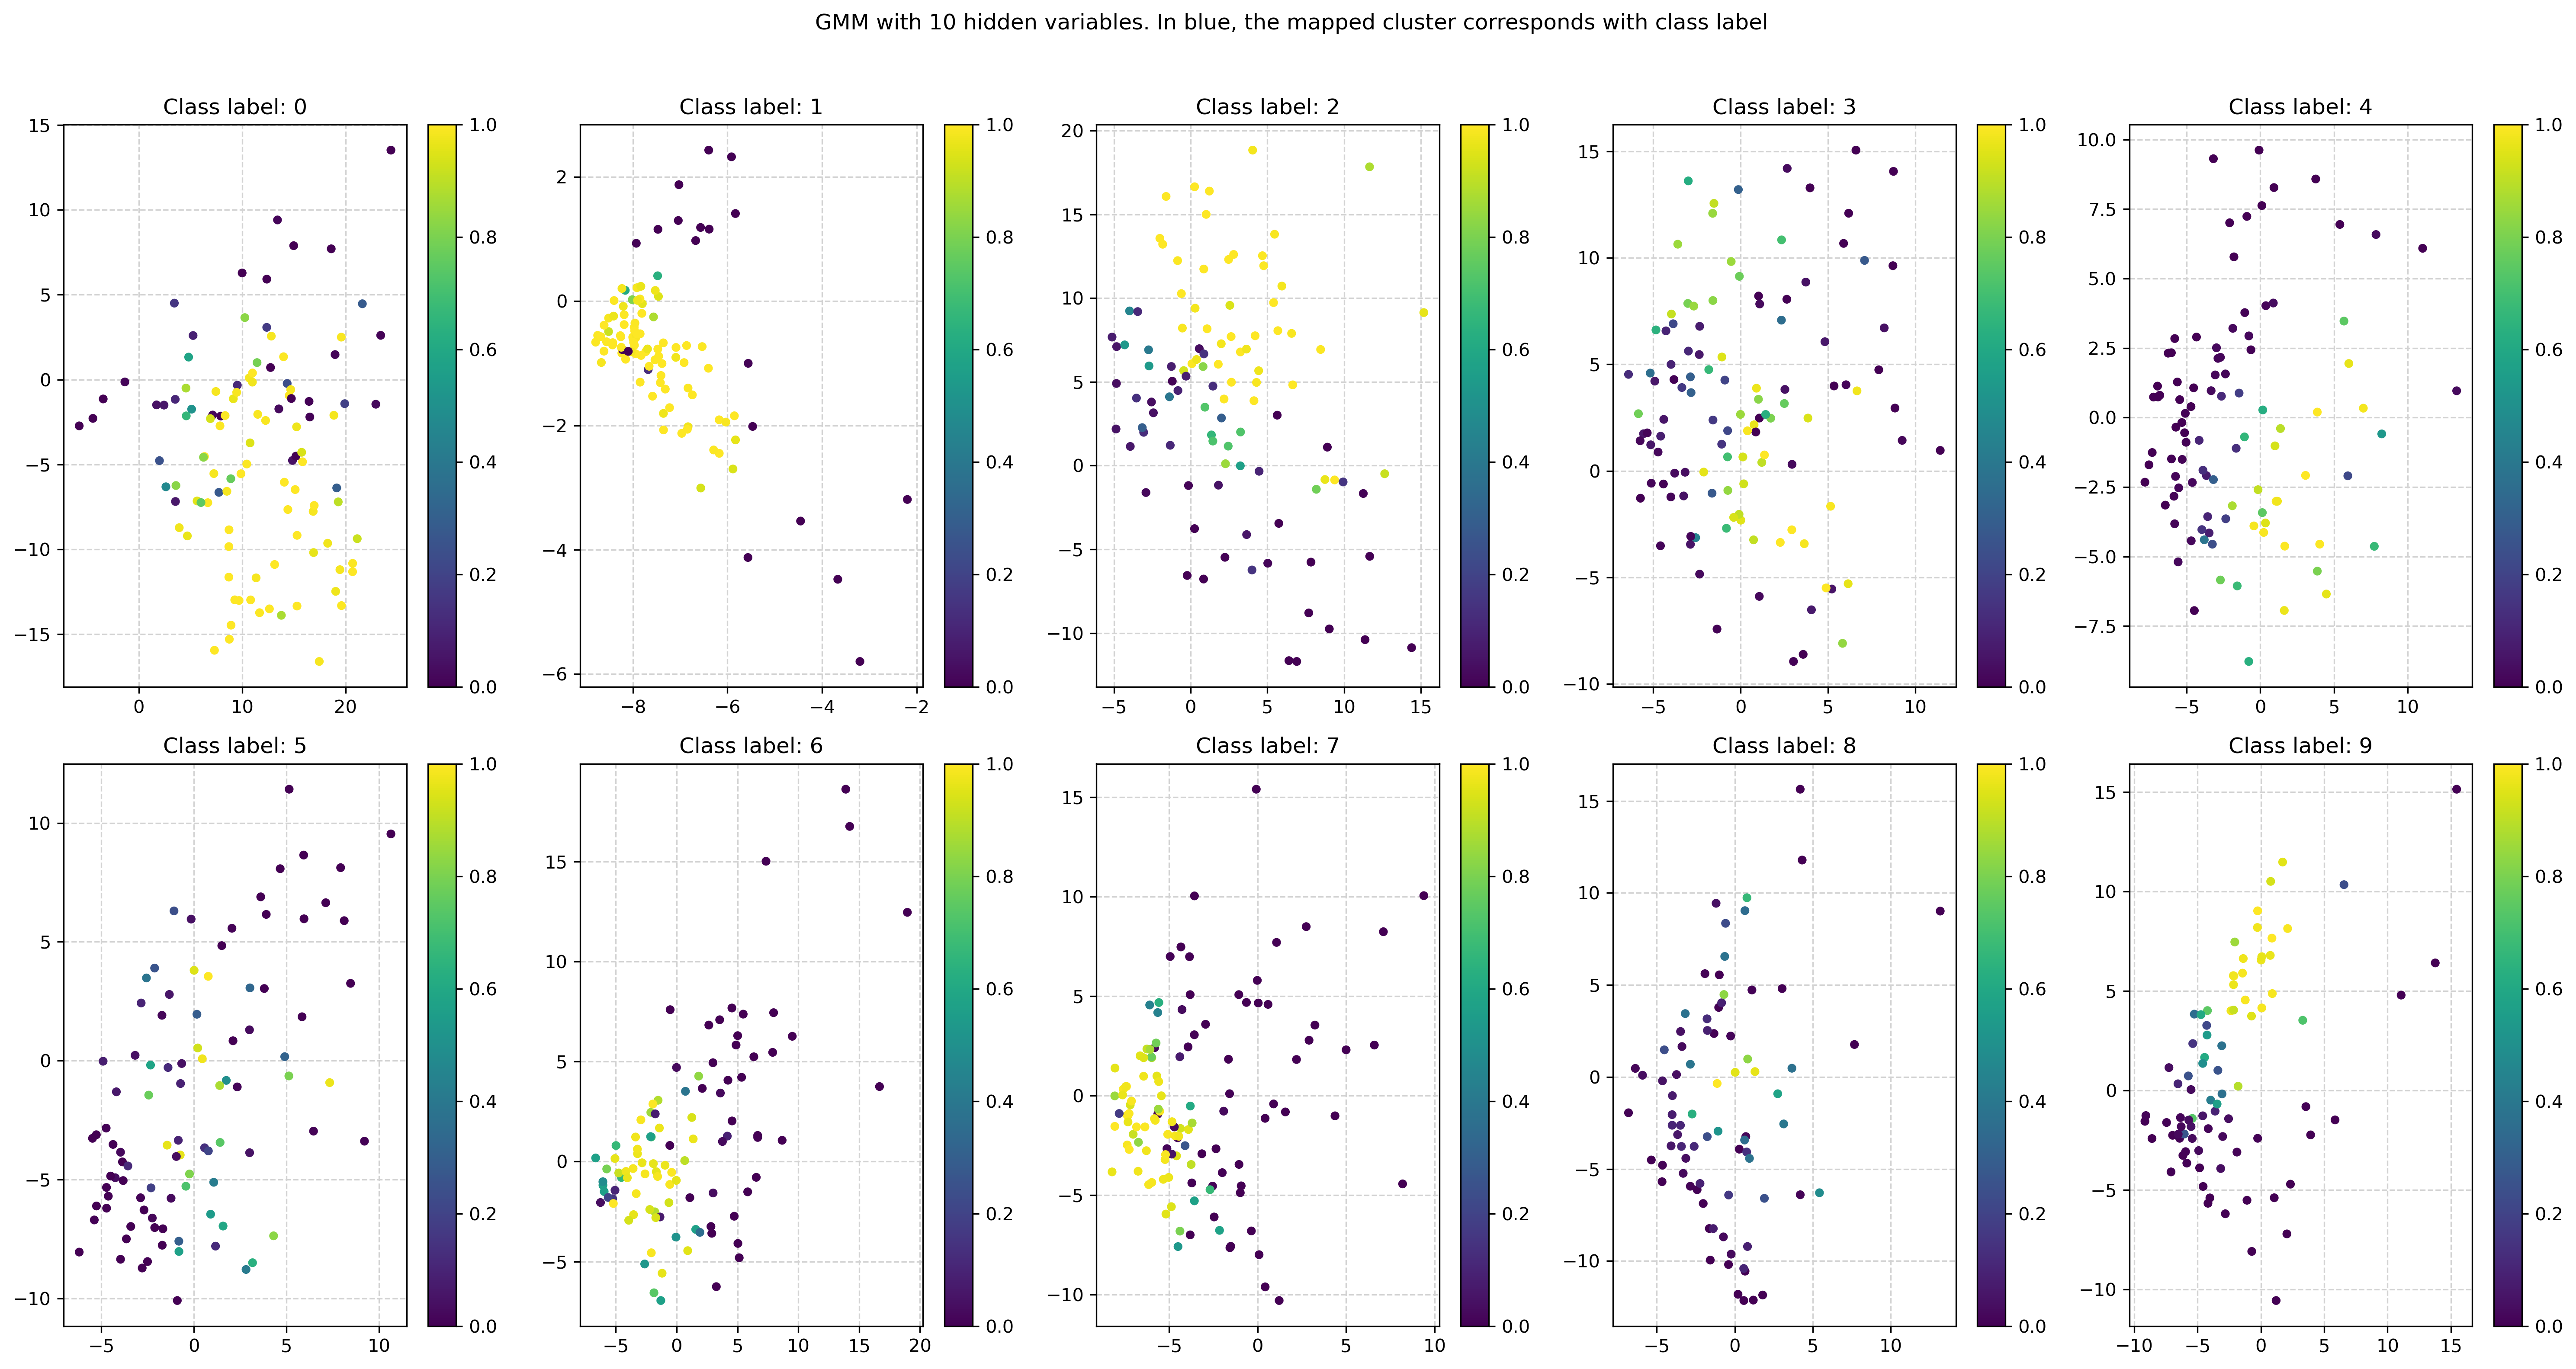

In [84]:
#ground truth labels
y = y_train[:1000]

nrow = 2; ncol = 5;

titles = []

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(20,10))
fig.suptitle('GMM with 10 hidden variables. In blue, the mapped cluster corresponds with class label', y = 1.05)

for i,ax in enumerate(axs.reshape(-1)): 
    X_i_0 = X_gmm[:, 0][np.where(y==i)]
    X_i_1 = X_gmm[:, 1][np.where(y==i)]
    n = len(X_i_0)
    ax.scatter(X_i_0,X_i_1,  c = cluster_probs_10[np.where(y==i)], cmap = 'viridis', s = 15)
    ax.set_title(f'Class label: {i}')
    sm = plt.cm.ScalarMappable(cmap = "viridis", norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    fig.colorbar(sm, ax=ax)
fig.tight_layout() 

The plots above are in line with the previous dicsussion. For labels '0', '1', '6', '7', most points have a high probability of belonging to their assigned mixture component. This indicates a higher homogeneity of the corresponding mixture components in terms of class labels. For the rest, one observed mixed results, with class labels '2', '3', '4', '5' having a wide range of probabilities of belonging to the assigned cluster and finally the class labels '8', '9' showing most values with small probabilities.

### 1.3.4

We retrain the Gaussian Mixture Model with a reduced number of five and eight components and
compute the map of the class labels to the best-fitting cluster index (as in 1.3.2). 

In [85]:
# Initialise Gaussian Mixture Model with 10 hidden components
X_gmm = X_pca
gmm_5 = GMModel(X_gmm,5)

In [86]:
# Initialise Gaussian Mixture Model with 10 hidden components
X_gmm = X_pca
gmm_8 = GMModel(X_gmm,8)

In [87]:
#Train gmm model 'until convergence'
for _ in trange(1000):
    fitStep(gmm_5,X_gmm)
    fitStep(gmm_8,X_gmm)

In [88]:
#reassigning labels
mapped_preds_5 = assign_label(gmm_5, X_gmm, y)
print(f'mapped predictions:\n {mapped_preds_5}')

mapped predictions:
 [4 2 3 4 0 3 0 0 3 0]


In [89]:
#reassigning labels
mapped_preds_8 = assign_label(gmm_8, X_gmm, y)
print(f'mapped predictions:\n {mapped_preds_8}')

mapped predictions:
 [4 5 6 6 0 6 2 0 4 0]


In [90]:
#Compute cluster probabilities for each digit with 5 hidden components
y = y_train[:1000]
cluster_probs_5 = np.array([cluster_probabilities(gmm_5,X_gmm)[i, mapped_preds_5[y[i]]] for i in range(len(y))])

In [91]:
#Compute cluster probabilities for each digit with 8 hidden components
y = y_train[:1000]
cluster_probs_8 = np.array([cluster_probabilities(gmm_8,X_gmm)[i, mapped_preds_8[y[i]]] for i in range(len(y))])

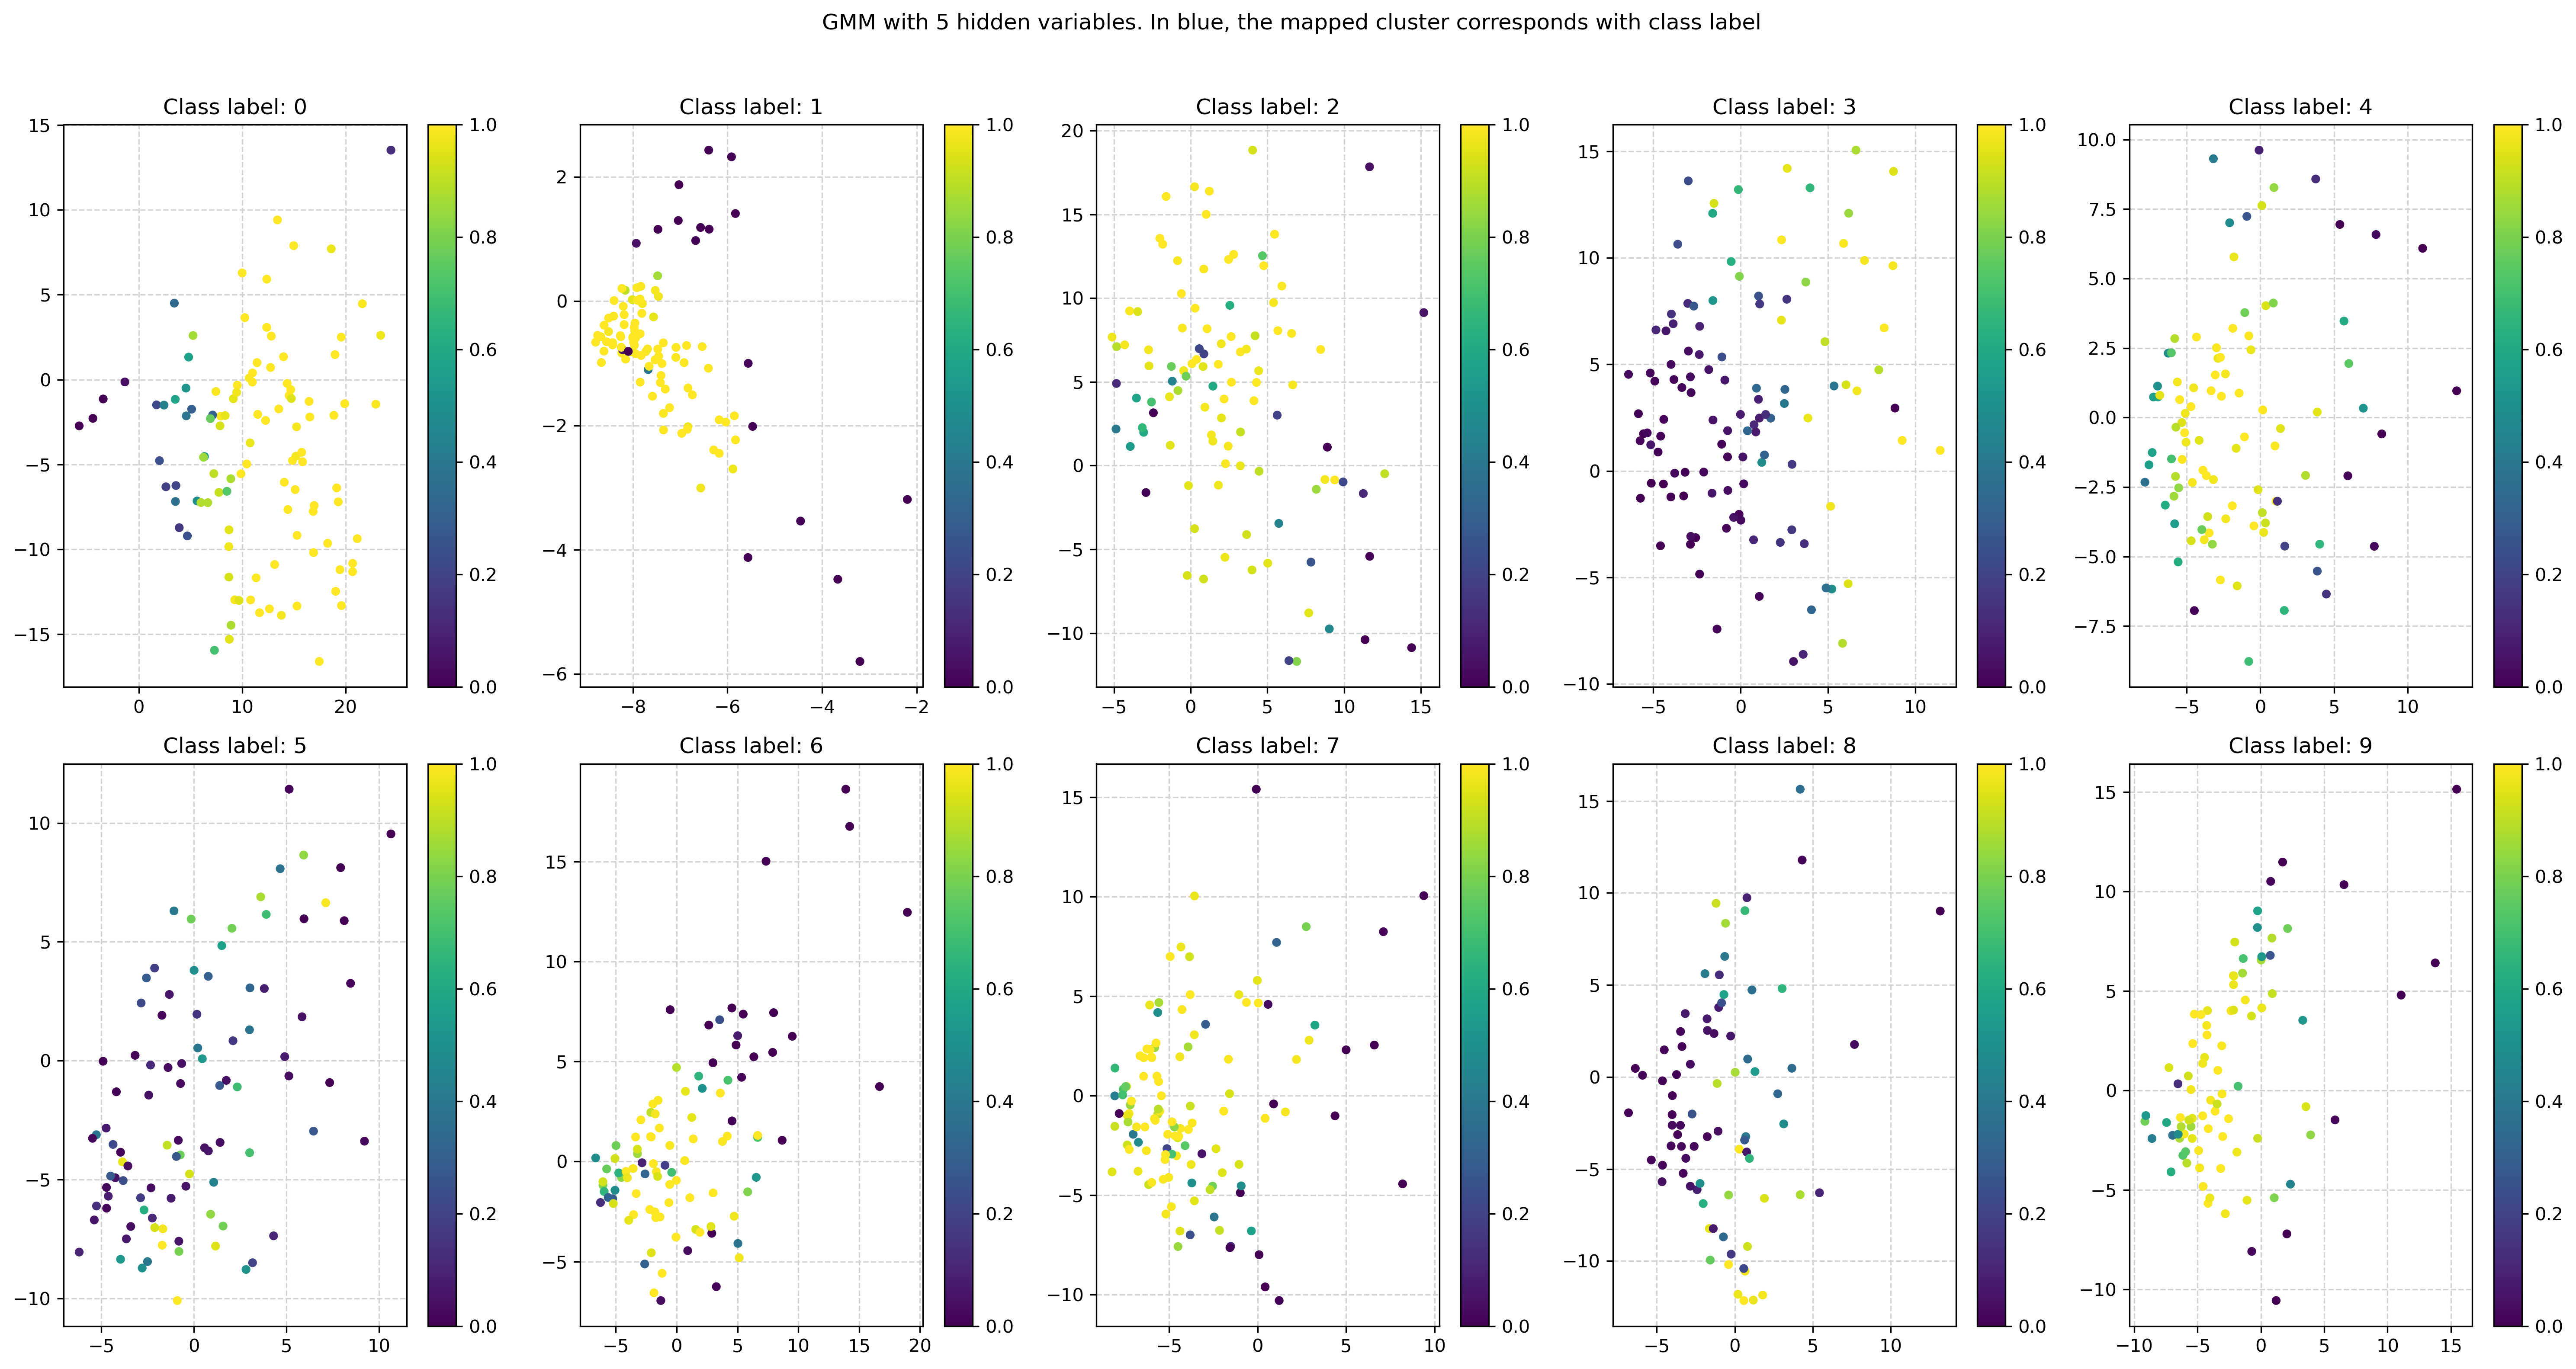

In [92]:
#ground truth labels 5 hidden components
y = y_train[:1000]

nrow = 2; ncol = 5;

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(20,10))
fig.suptitle('GMM with 5 hidden variables. In blue, the mapped cluster corresponds with class label', y = 1.05)
cmap = 'viridis'

for i,ax in enumerate(axs.reshape(-1)): 
    X_i_0 = X_gmm[:, 0][np.where(y==i)]
    X_i_1 = X_gmm[:, 1][np.where(y==i)]
    n = len(X_i_0)
    ax.scatter(X_i_0,X_i_1, c = cluster_probs_5[np.where(y==i)], cmap = 'viridis', s = 15)
    ax.set_title(f'Class label: {i}')
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    fig.colorbar(sm, ax=ax)
fig.tight_layout() 

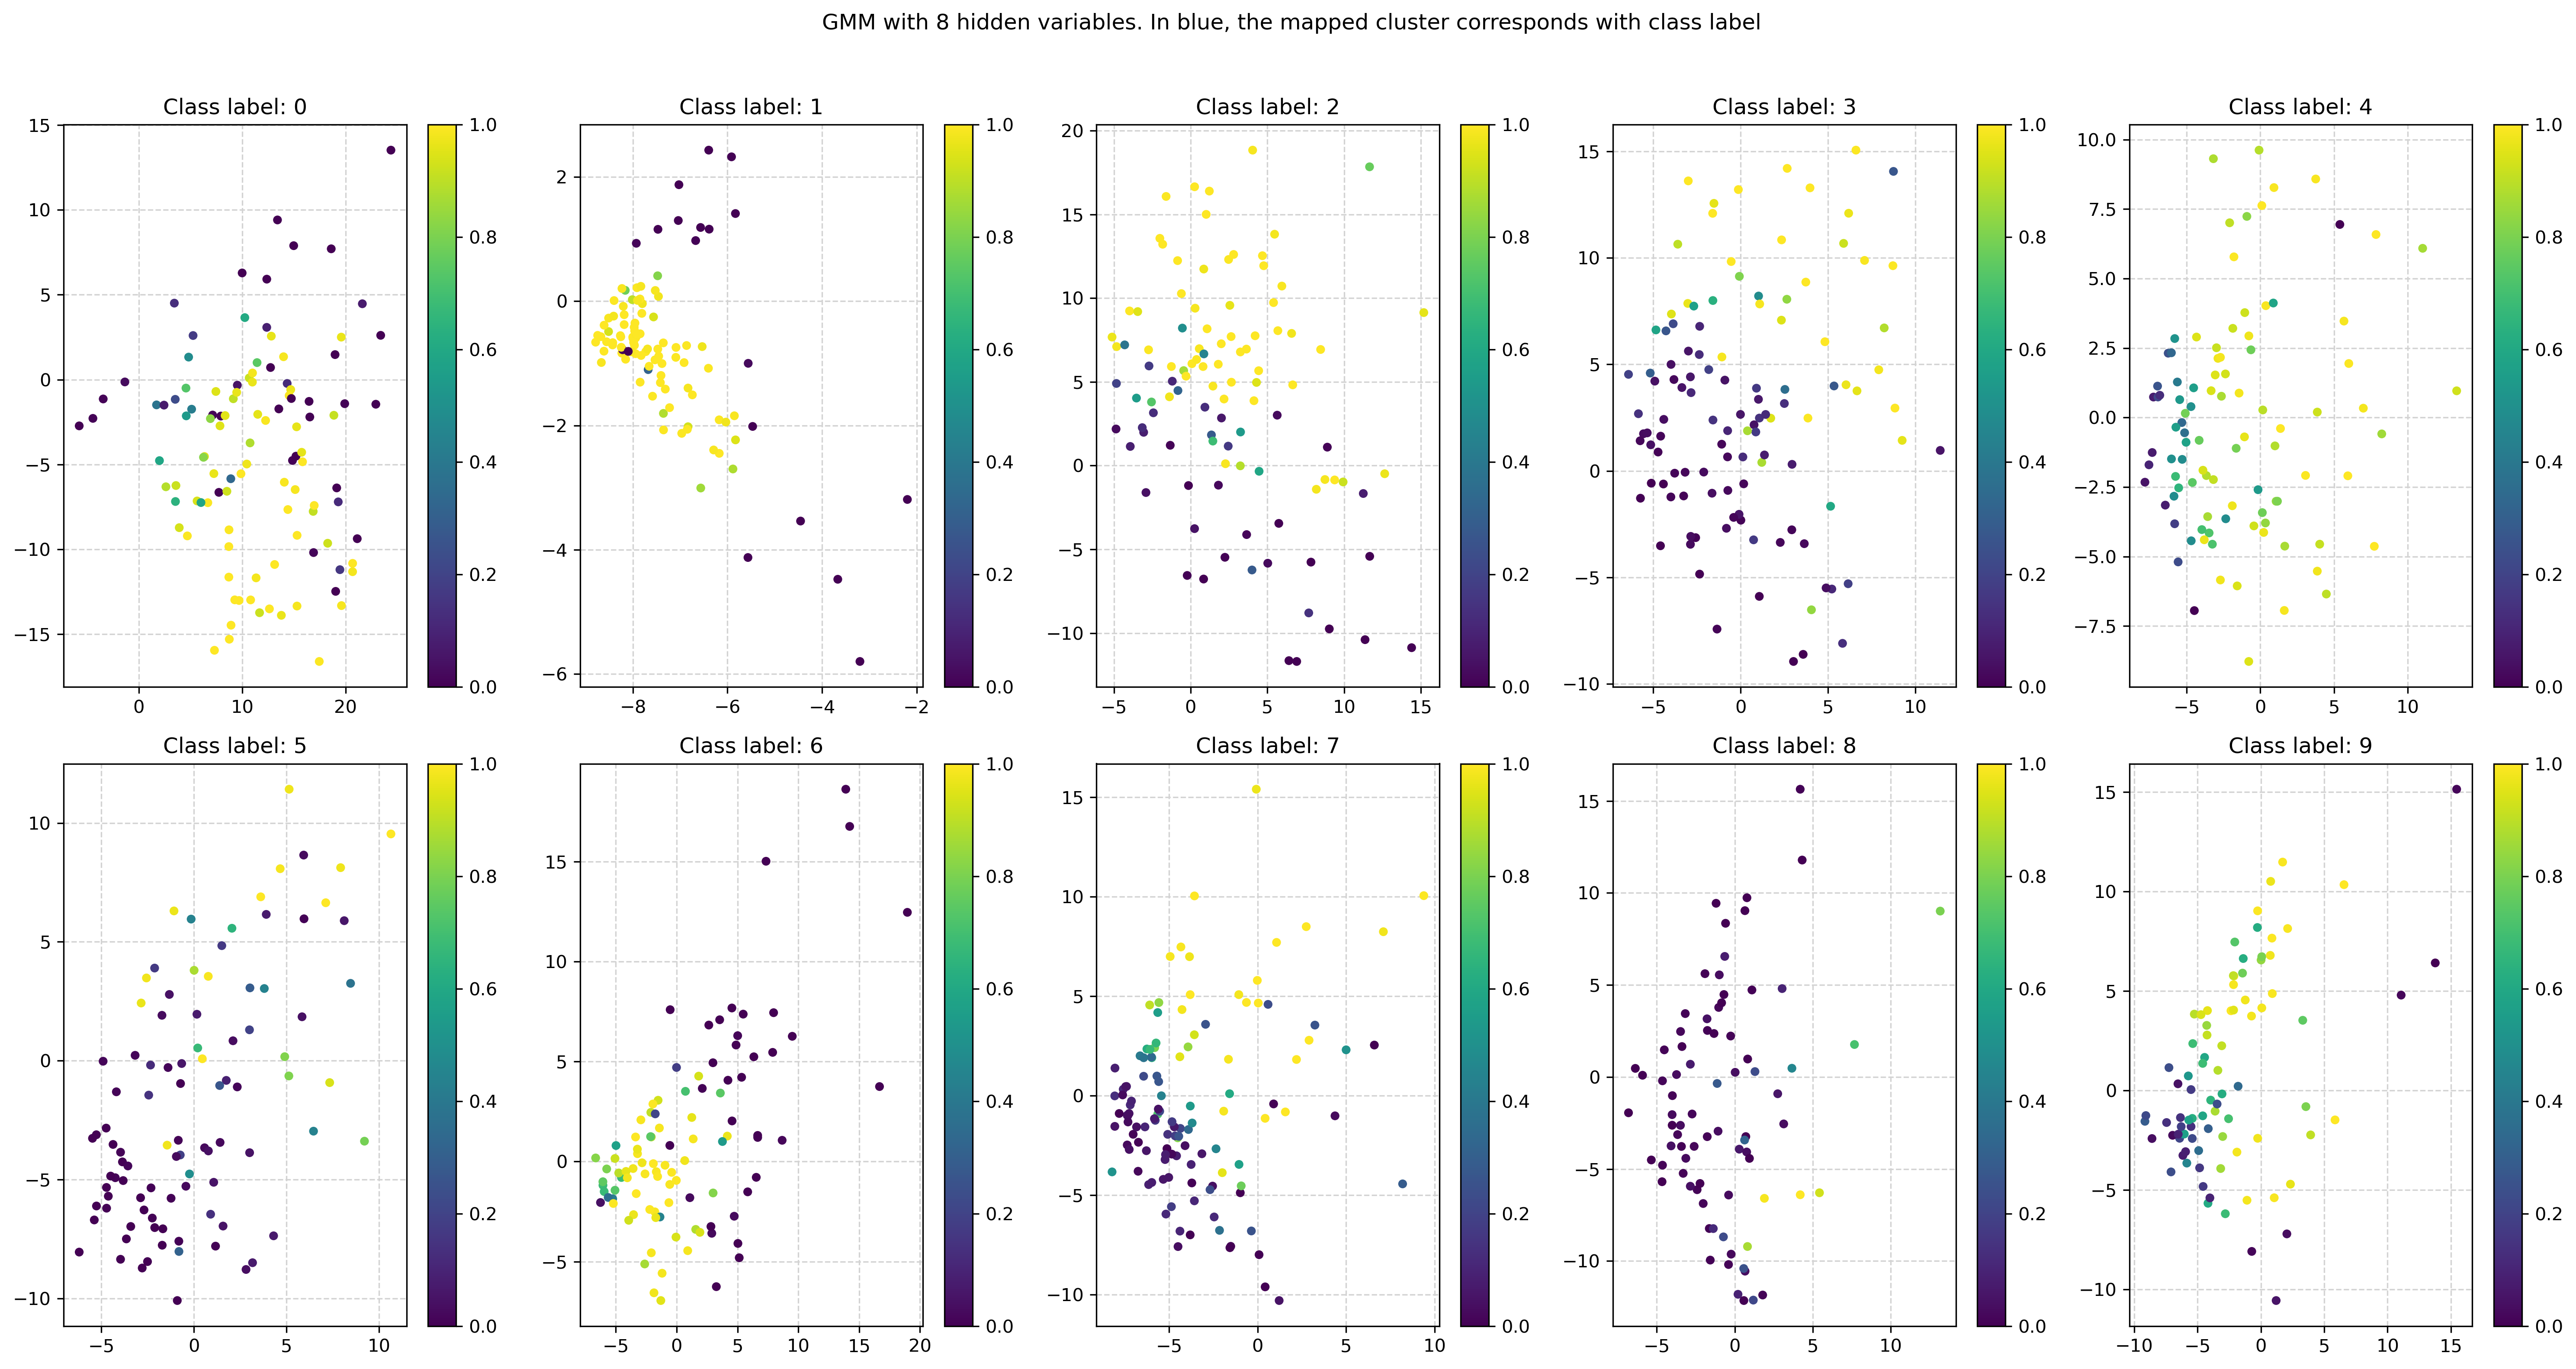

In [93]:
#ground truth labels 8 hidden components
y = y_train[:1000]

nrow = 2; ncol = 5;

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(20,10))
fig.suptitle('GMM with 8 hidden variables. In blue, the mapped cluster corresponds with class label', y = 1.05)
cmap = 'viridis'

for i,ax in enumerate(axs.reshape(-1)): 
    X_i_0 = X_gmm[:, 0][np.where(y==i)]
    X_i_1 = X_gmm[:, 1][np.where(y==i)]
    n = len(X_i_0)
    ax.scatter(X_i_0,X_i_1, c = cluster_probs_8[np.where(y==i)], cmap = 'viridis', s = 15)
    ax.set_title(f'Class label: {i}')
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    fig.colorbar(sm, ax=ax)
fig.tight_layout()  

We compare the model performance by varying the number of hidden components from 5 to 8 and to 10.

We first observe that for class the labels '0' and '1', the clustering across all the models is near certain, with data having a near one probability of belonging to their assigned cluster; this can be seen in the three sets of colour plots above. 

For other class labels, model performance varies. When the number of hidden components is increased to 8, for each class label, we see similar probabilities of belonging to their assigned cluster. We also note that the number of assigned clusters is the same for 5 and 8 hidden components. This suggests that adding more components than the dimenisonality of the data, in this case, the 5 PCA principal components, does not improve model performance, and can even lead to overfitting. 

Finally, the GMM trained with 10 hidden components performs the worst. This suggests the model $\textbf{overfitting}$ is present with the model being $\textbf{too complex}$, and learns noise present in the data, rather than underlying correlations between thereof.

### Task 2: Clustering and graph-based analysis (35 marks)

### 2.1 Clustering (15 marks)
#### 2.1.1

In [94]:
np.random.seed(15849)

In [95]:
def standardise(X):
    """
    The function standardise takes an array X and returns a standardized version of X, where each feature (column) has mean 0 and standard deviation 1.

    Args:
        X : numpy array of shape (n_samples, n_features). The data to be standardized.

    Returns:
        Xbar : numpy array of shape (n_samples, n_features). 
    """

    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

We standardise the gene espression data, which is continuous, to bring every variable in the same range. This will improve the clustering analysis and help uncover with more clarity correlations present in the data rather than be impacted by the dimensions thereof.

In [96]:
# Load training data 

#train data
gene_data = pd.read_csv('gene_expression_data.csv')

features = gene_data.columns

X_gene = gene_data.to_numpy()

#extracting gene extraction data
X_gene = X_gene[:,:-1]
#standardise non-categorical data
X_gene = standardise(X_gene.astype(float))

In [97]:
def train_k_means(X, k=3, max_iter = 15): 

    """
    Applies the K-means clustering algorithm to the input data matrix X.
    
    Args:
    
    X (numpy.ndarray): The input data matrix of shape (n_samples, n_features).
    k (int, optional (default=3)): The number of clusters to form.
    max_iter (int, optional (default=15)): The maximum number of iterations for the K-means algorithm.
        
    Returns:
    labels (numpy.ndarray): An array of integers representing the cluster assignment of each data point of shape (n_samples,).
    centroids (numpy.ndarray): An array of shape (k, n_features) containing the coordinates of the centroids of the k clusters.
    """
    
    n_samples, n_features = X.shape
    
    labels = np.random.randint(low=0, high=k, size=n_samples)
    new_labels = np.zeros(X.shape[0])
    difference = 0

    centroids = np.zeros((k, n_features))
    for c in range(k):
        # update centroids by taking the mean over associated data points
        if (labels == c).any():
            centroids[c] = np.mean(X[labels==c], axis=0) 
    
    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            break
        else:
            # labels changed
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)    
    return labels, centroids

Following [2], we now code a function that computes the Calinski-Harabasz index of a given clustering, which measures the clustering quality based on a ratio of the between-cluster scatter matrix, and the within-cluster scatter matrix.

$$
CH_k = \frac{BCSM}{k-1}\cdot\frac{n-k}{WCSM}\\
BCSM = \displaystyle\sum_{i=1}^k n_i\cdot d(z_i, z_{tot})^2\\
WCSM = \displaystyle\sum_{i=1}^k\displaystyle\sum_{x\in c_i}\cdot d(x, z_{tot})^2
$$
where $z_i$ is the center of the cluster $c_i$, and $n_i$, the number of points in $c_i$. Also note that $z_{tot}$ is the centroid of all the data points in the feature matrix.

In [98]:
def CH(X, labels, centroids, k = 3):
    """
    The function CH calculates the Calinski-Harabasz index of a given clustering, which is a measure of the quality of a clustering solution.

    Args:
    X: The dataset as a 2D numpy array where each row represents a data point and each column represents a feature.
    labels: The cluster assignments for each data point.
    centroids: The coordinates of the cluster centers.
    k: The number of clusters.

    Returns: 
    The Calinski-Harabasz index of the clustering solution.
    """
    return BCSM(X, labels, centroids, k)/(k-1)*(len(X)-k)/WCSM(X, labels, centroids, k)

In [99]:
def BCSM(X, labels, centroids, k = 3):
    """
    The function BCSM calculates the between-cluster scatter matrix of a given clustering solution.
    
    Args:
    X: The dataset as a 2D numpy array where each row represents a data point and each column represents a feature.
    labels: The cluster assignments for each data point.
    centroids: The coordinates of the cluster centers.
    k: The number of clusters.

    Returns: 
    The between-cluster scatter matrix of the clustering solution.
    """
    bcsm = 0
    z_tot = np.mean(X, axis = 0)
        
    distances = np.array([np.linalg.norm(centroids[i] - z_tot.reshape(1,-1))**2 for i in range(k)])
    
    bcsm = np.dot([len(X[labels == i])  for i in range(k)], distances)
    return bcsm

In [100]:
def WCSM(X, labels, centroids, k = 3):
    
    """
    Computes the within-cluster scatter matrix (WCSS) of a given clustering.

    Args:
        X (ndarray): The dataset of shape (n_samples, n_features).
        labels (ndarray): The cluster labels for each sample of shape (n_samples,).
        centroids (ndarray): The centroid coordinates for each cluster of shape (k, n_features).
        k (int): The number of clusters.

    Returns:
        wcsm (float): The within-cluster scatter matrix (WCSS) value.
    """
    
    distances = [np.sum(np.linalg.norm(X[labels == i] - centroids[i].reshape(1,-1), axis = 1) **2)\
                          for i in range(k)]
    wcsm = np.sum(distances)
    
    return wcsm

In [101]:
#Find optimal k with CH measure
k_range = np.arange(2,30)
CH_scores = []
for i in tqdm(k_range):
    #random label initialisations
    score = []
    for j in range(5):
        labels, centroids = train_k_means(X_gene, k = i, max_iter = 100)
        score.append(CH(X_gene, labels, centroids, k = i))
    CH_scores.append(np.mean(score))

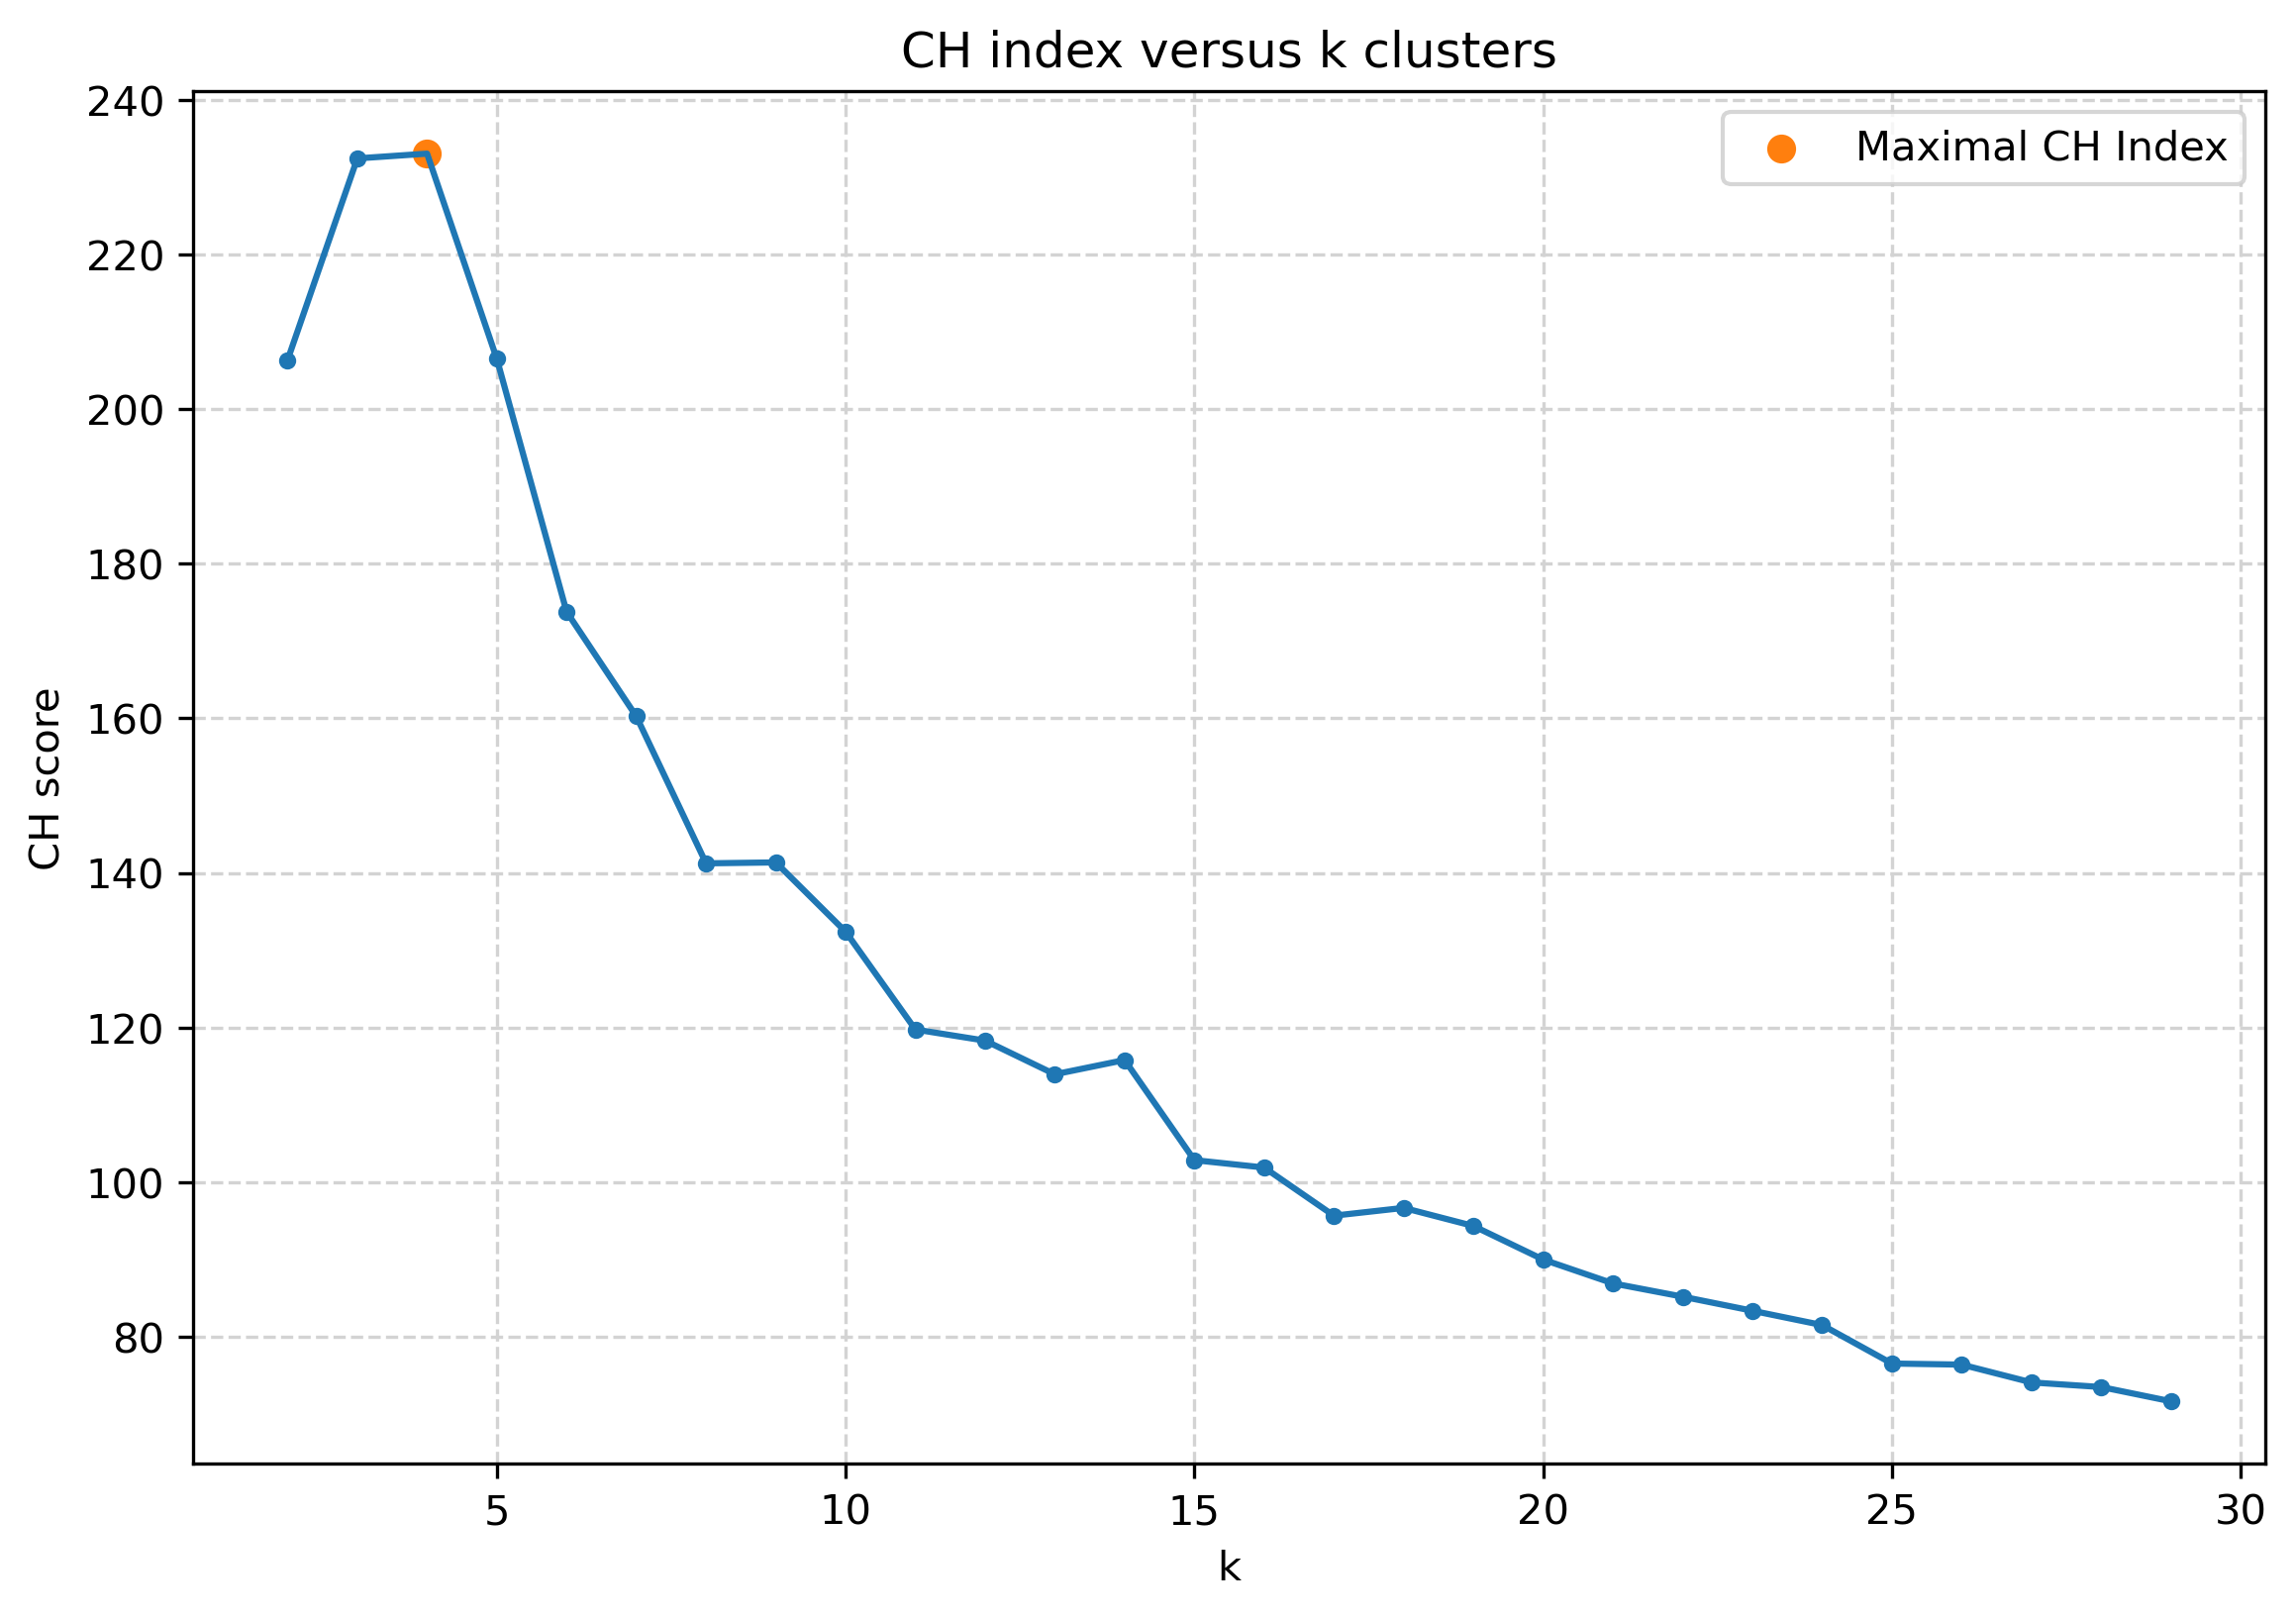

In [102]:
#locate maximum
max_k = k_range[np.argmax(CH_scores)]
max_CH = CH_scores[np.argmax(CH_scores)]

plt.plot(k_range, CH_scores)
plt.scatter(k_range, CH_scores, s = 10)
plt.scatter(max_k, max_CH, label = 'Maximal CH Index')
plt.title('CH index versus k clusters')
plt.ylabel('CH score')
plt.xlabel('k')
plt.legend()

In [103]:
#Optimal size of clusters
print(f'Optimal cluster size: {max_k}')

Optimal cluster size: 4


In [104]:
#Cluster sizes for optimal k
optimal_k = max_k

labels, centroids = train_k_means(X_gene, k = optimal_k, max_iter = 100)

for i in range(optimal_k):
    print(f'cluster label: {i}')
    print(f'Size of optimal clusters: {len(labels[labels == i])}\n')

cluster label: 0
Size of optimal clusters: 305

cluster label: 1
Size of optimal clusters: 217

cluster label: 2
Size of optimal clusters: 138

cluster label: 3
Size of optimal clusters: 140



### 2.1.2

In [105]:
#Reading gene types
gene_types = gene_data['Type'].to_numpy()

We implement a function that computes the homogeneity score, a score measuring the extent to which the data
points in one cluster belong to the same class. 

In [106]:
def hom_score(labels, gene_types):
    """
    The function hom_score computes the homogeneity score of a clustering.

    Args:

        labels (array-like of shape (n_samples,)): Cluster labels assigned to each data point.
        gene_types (array-like of shape (n_samples,)): True class labels of each data point.

    Returns:
        hom_score (float): The homogeneity score of the clustering.
    """
    return 1-H_conditional(labels, gene_types)/(H_entropy(labels, gene_types))

In [107]:
def H_entropy(labels, gene_types):
    """
    Args:

        labels (numpy array of shape (n_samples,)): contains cluster assignments for each data point
    gene_types (numpy array of shape (n_samples,)): contains gene type labels for each data point
    
    Returns:
        entropy (float): the entropy of the clustering solution
    """
    entropy = 0
    N = len(labels)
    C = len(gene_types)
    K = len(labels)
    
    for c in set(gene_types):
        a_summed = len(gene_types[gene_types == c])
            
        entropy -= (a_summed/N)*np.log(a_summed/N)
        
    return entropy

In [108]:
def H_conditional(labels, gene_types):
        
    """
    Computes the conditional entropy of the clustering given the gene types.
    
    Args:
        labels (array-like, shape (n_samples,)): The cluster labels for each sample.
        gene_types (array-like, shape (n_samples,)): The gene types for each sample.
        
    Returns:
        entropy (float): The conditional entropy of the clustering given the gene types.
    """       
    entropy = 0
    N = len(labels)
    C = len(gene_types)
    K = len(labels)
    
    for k in set(labels):
        a_summed = len(labels[labels == k])
        for c in set(gene_types):
            a_ck = len(labels[(labels == k)&(gene_types == c)])
            if a_ck != 0:
                entropy -= (a_ck/N)*np.log(a_ck/a_summed)
        
    return entropy

In [109]:
#homogeneity score of clustering with optimal k
labels, centroids = train_k_means(X_gene, k = optimal_k, max_iter = 500)
print(f'homogeneity score: {hom_score(labels, gene_types)}')

homogeneity score: 0.5867971369720713


The homogeneity score is less than 1. This is expected because there are more class labels (5) than clusters (4), meaning that clusters cannot be perfectly homogeneous. Furthermore, the homogeneity score being at around 0.6 suggests that the clusters are relatively consistent with sample tumour types, as the model may be producing clusters that are too general or too mixed, which can make it difficult to draw meaningful insights from the data. Finally, note that the optimal number of clusters, namely, 4 is close to the number of latent label variables (tumour types) which are 5.

### 2.2 Graph-based analysis (20 marks)
#### 2.2.1

In [110]:
# Load training data 

#train data
gene_data = pd.read_csv('gene_expression_data.csv')

features = gene_data.columns

X_gene = gene_data.to_numpy()

#extracting gene extraction data
X_gene = X_gene[:,:-1]
#standardise non-categorical data
X_gene = standardise(X_gene.astype(float))

X_train = X_gene.astype(float)

We compute the matrix of connected correlations between genes (columns) and use it as a similarity
matrix to construct a graph that links genes. Set to zero the diagonal terms and all the terms whose
absolute value is smaller than 0.75 (i.e., perform thresholding with threshold = 0.75 on the absolute value).


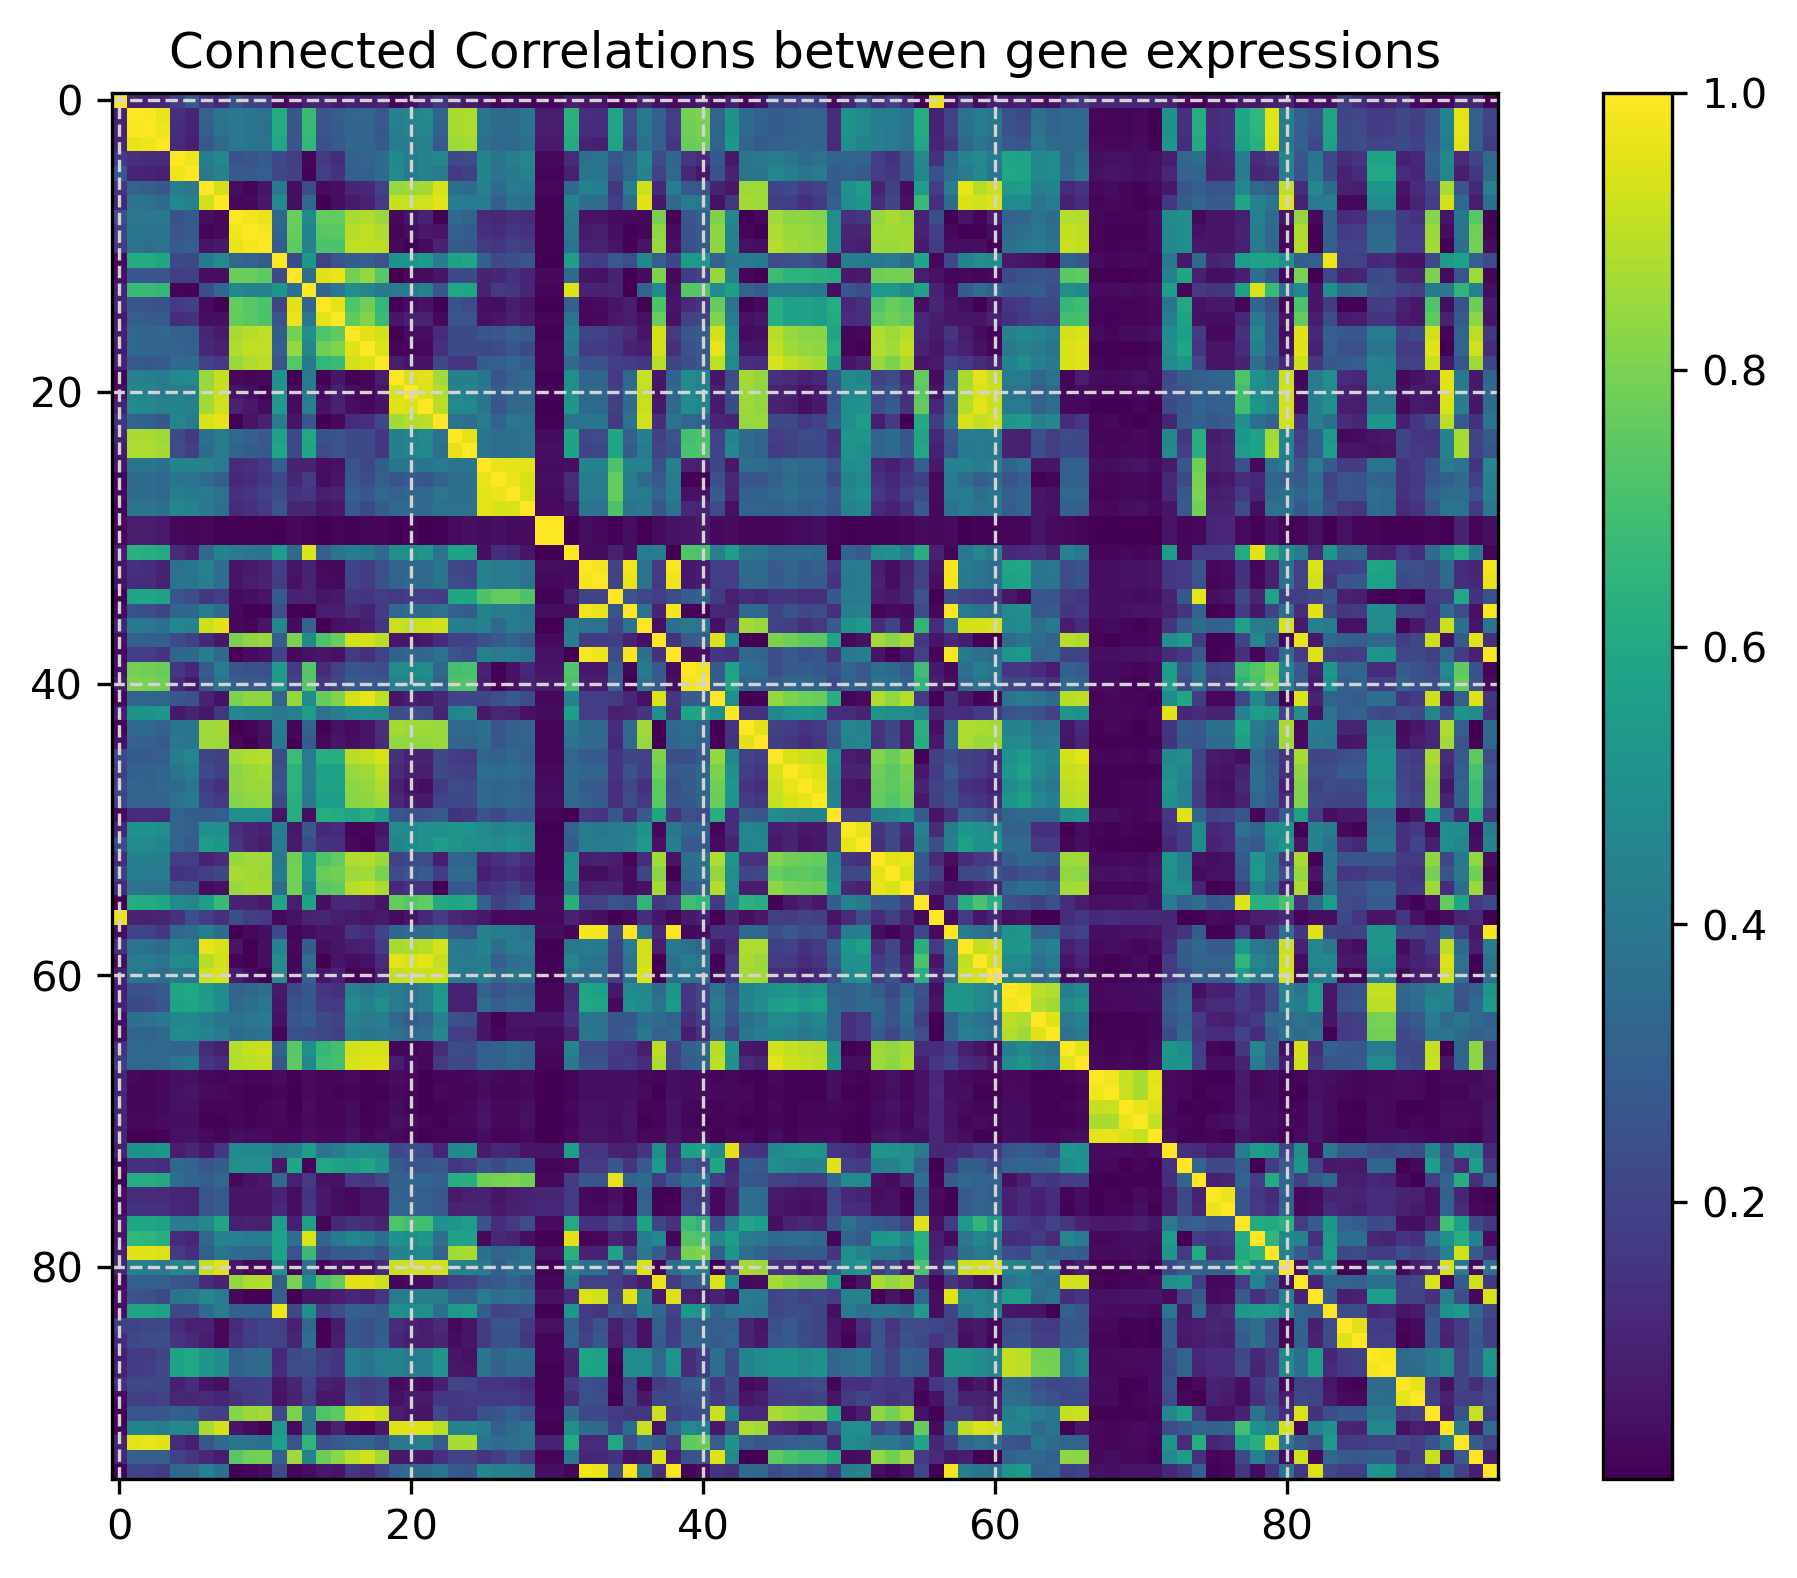

In [111]:
#visualising matrix of connected correlations
connected_correlations = np.corrcoef(X_gene.T)
plt.imshow(np.abs(connected_correlations))
plt.title('Connected Correlations between gene expressions')
plt.colorbar()

In [112]:
#Thresholding
mat = np.abs(connected_correlations)
mat = np.where(mat > 0.75 , mat, 0)
#setting diagonal terms to zero
for i in range(mat.shape[0]):
    mat[i,i] = 0
adjacency_mat = mat

Take the resulting matrix as the adjacency matrix A of a weighted graph describing gene co-expression.
Visualise the adjacency matrix A using imshow.

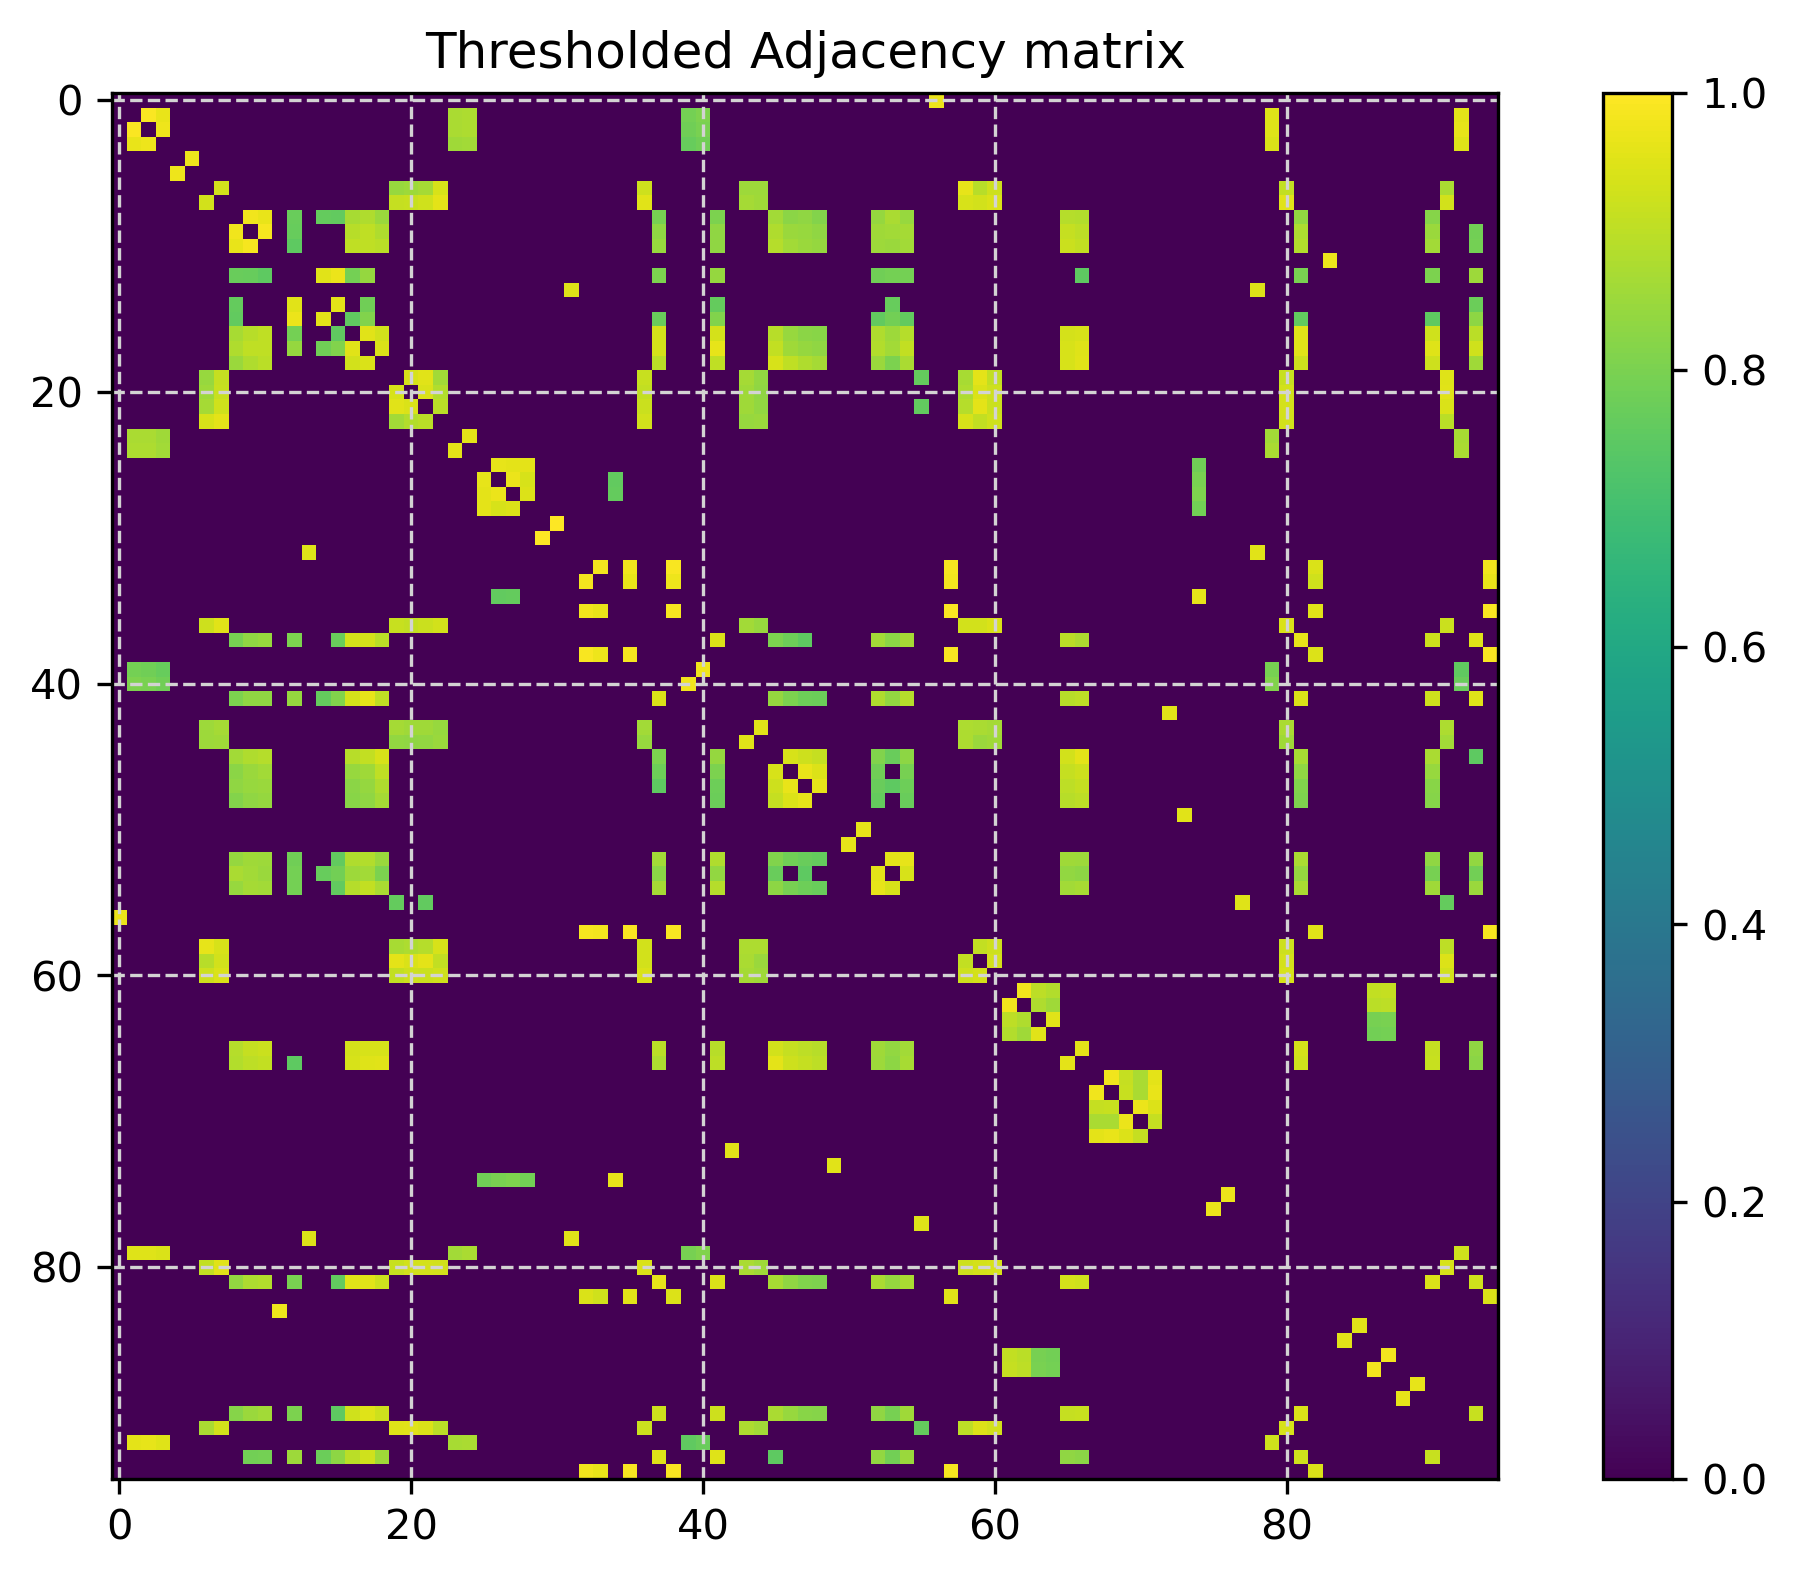

In [113]:
#visualising adjacency matrix
plt.title('Thresholded Adjacency matrix')
plt.imshow(adjacency_mat)
plt.colorbar()

### 2.2.2

We now compute the degree centrality of each node (gene) in the network, sort the genes in descending
order by these values and print the index of the 5 top ranking genes.


In [114]:
#computing degree centrality
degree_centrality = np.sum(adjacency_mat,axis=1)/np.sum(adjacency_mat)
 
genes = range(len(degree_centrality))
genes, degree_centrality = zip(*sorted(zip(genes, degree_centrality), key=lambda x: x[1], reverse = True))
print(f'The five genes with the highest degree centralities:\n')
for i in range(5):
    print(f'gene: {genes[i]}, centrality: {degree_centrality[i]}\n')

The five genes with the highest degree centralities:

gene: 17, centrality: 0.026873435141916806

gene: 41, centrality: 0.025935453030435745

gene: 16, centrality: 0.025378373920500026

gene: 81, centrality: 0.02523066217538562

gene: 90, centrality: 0.024870225673900577



#### 2.2.3

We now proceed to compute the symmetric normalised Laplacian of the graph and obtain its eigenvalues and
eigenvectors.

To this end, we consider the combinatorial Laplacian of our graph, which is defined as:
$$
\boldsymbol L = \boldsymbol D - \boldsymbol A
$$ 

where $\boldsymbol D$ is our diagonal matrix of node degrees and $\boldsymbol A$ is our adjacency matrix. Having weighted edges in $A$, the degree is simply the sum over the weighted edges. Thus, the diagonal matrix of degrees $\boldsymbol D$ is computed by:

>1.  Summing over the rows of our adjacency matrix
>2.  Setting the above to a diagonal matrix



Now we construct the symmetric normalized Laplacian,

$$
\boldsymbol L = \boldsymbol I - \boldsymbol D^{-1/2}\boldsymbol A \boldsymbol D^{-1/2}
$$ 


In [115]:
#Computing symmetric Laplacian
L = np.diag(np.sum(adjacency_mat, axis = 0))-adjacency_mat

In [116]:
#Computing symmetric Laplacian
D_sqrt_inv = np.diag(1/np.sqrt(np.sum(adjacency_mat, axis = 0)))
L_norm = np.identity(L.shape[0])-D_sqrt_inv@adjacency_mat@D_sqrt_inv

In [117]:
# return the eigenvectors and eigenvalues of normalised laplacian in ascending order
eigenvals, eigenvecs = scipy.linalg.eigh(L_norm)

We plot the spectrum of eigenvalues and mark the gap between eigenvalues that have respectively zero and non-zero values upon numerical rounding:

Text(0.5, 0, 'Eigenvalue number')

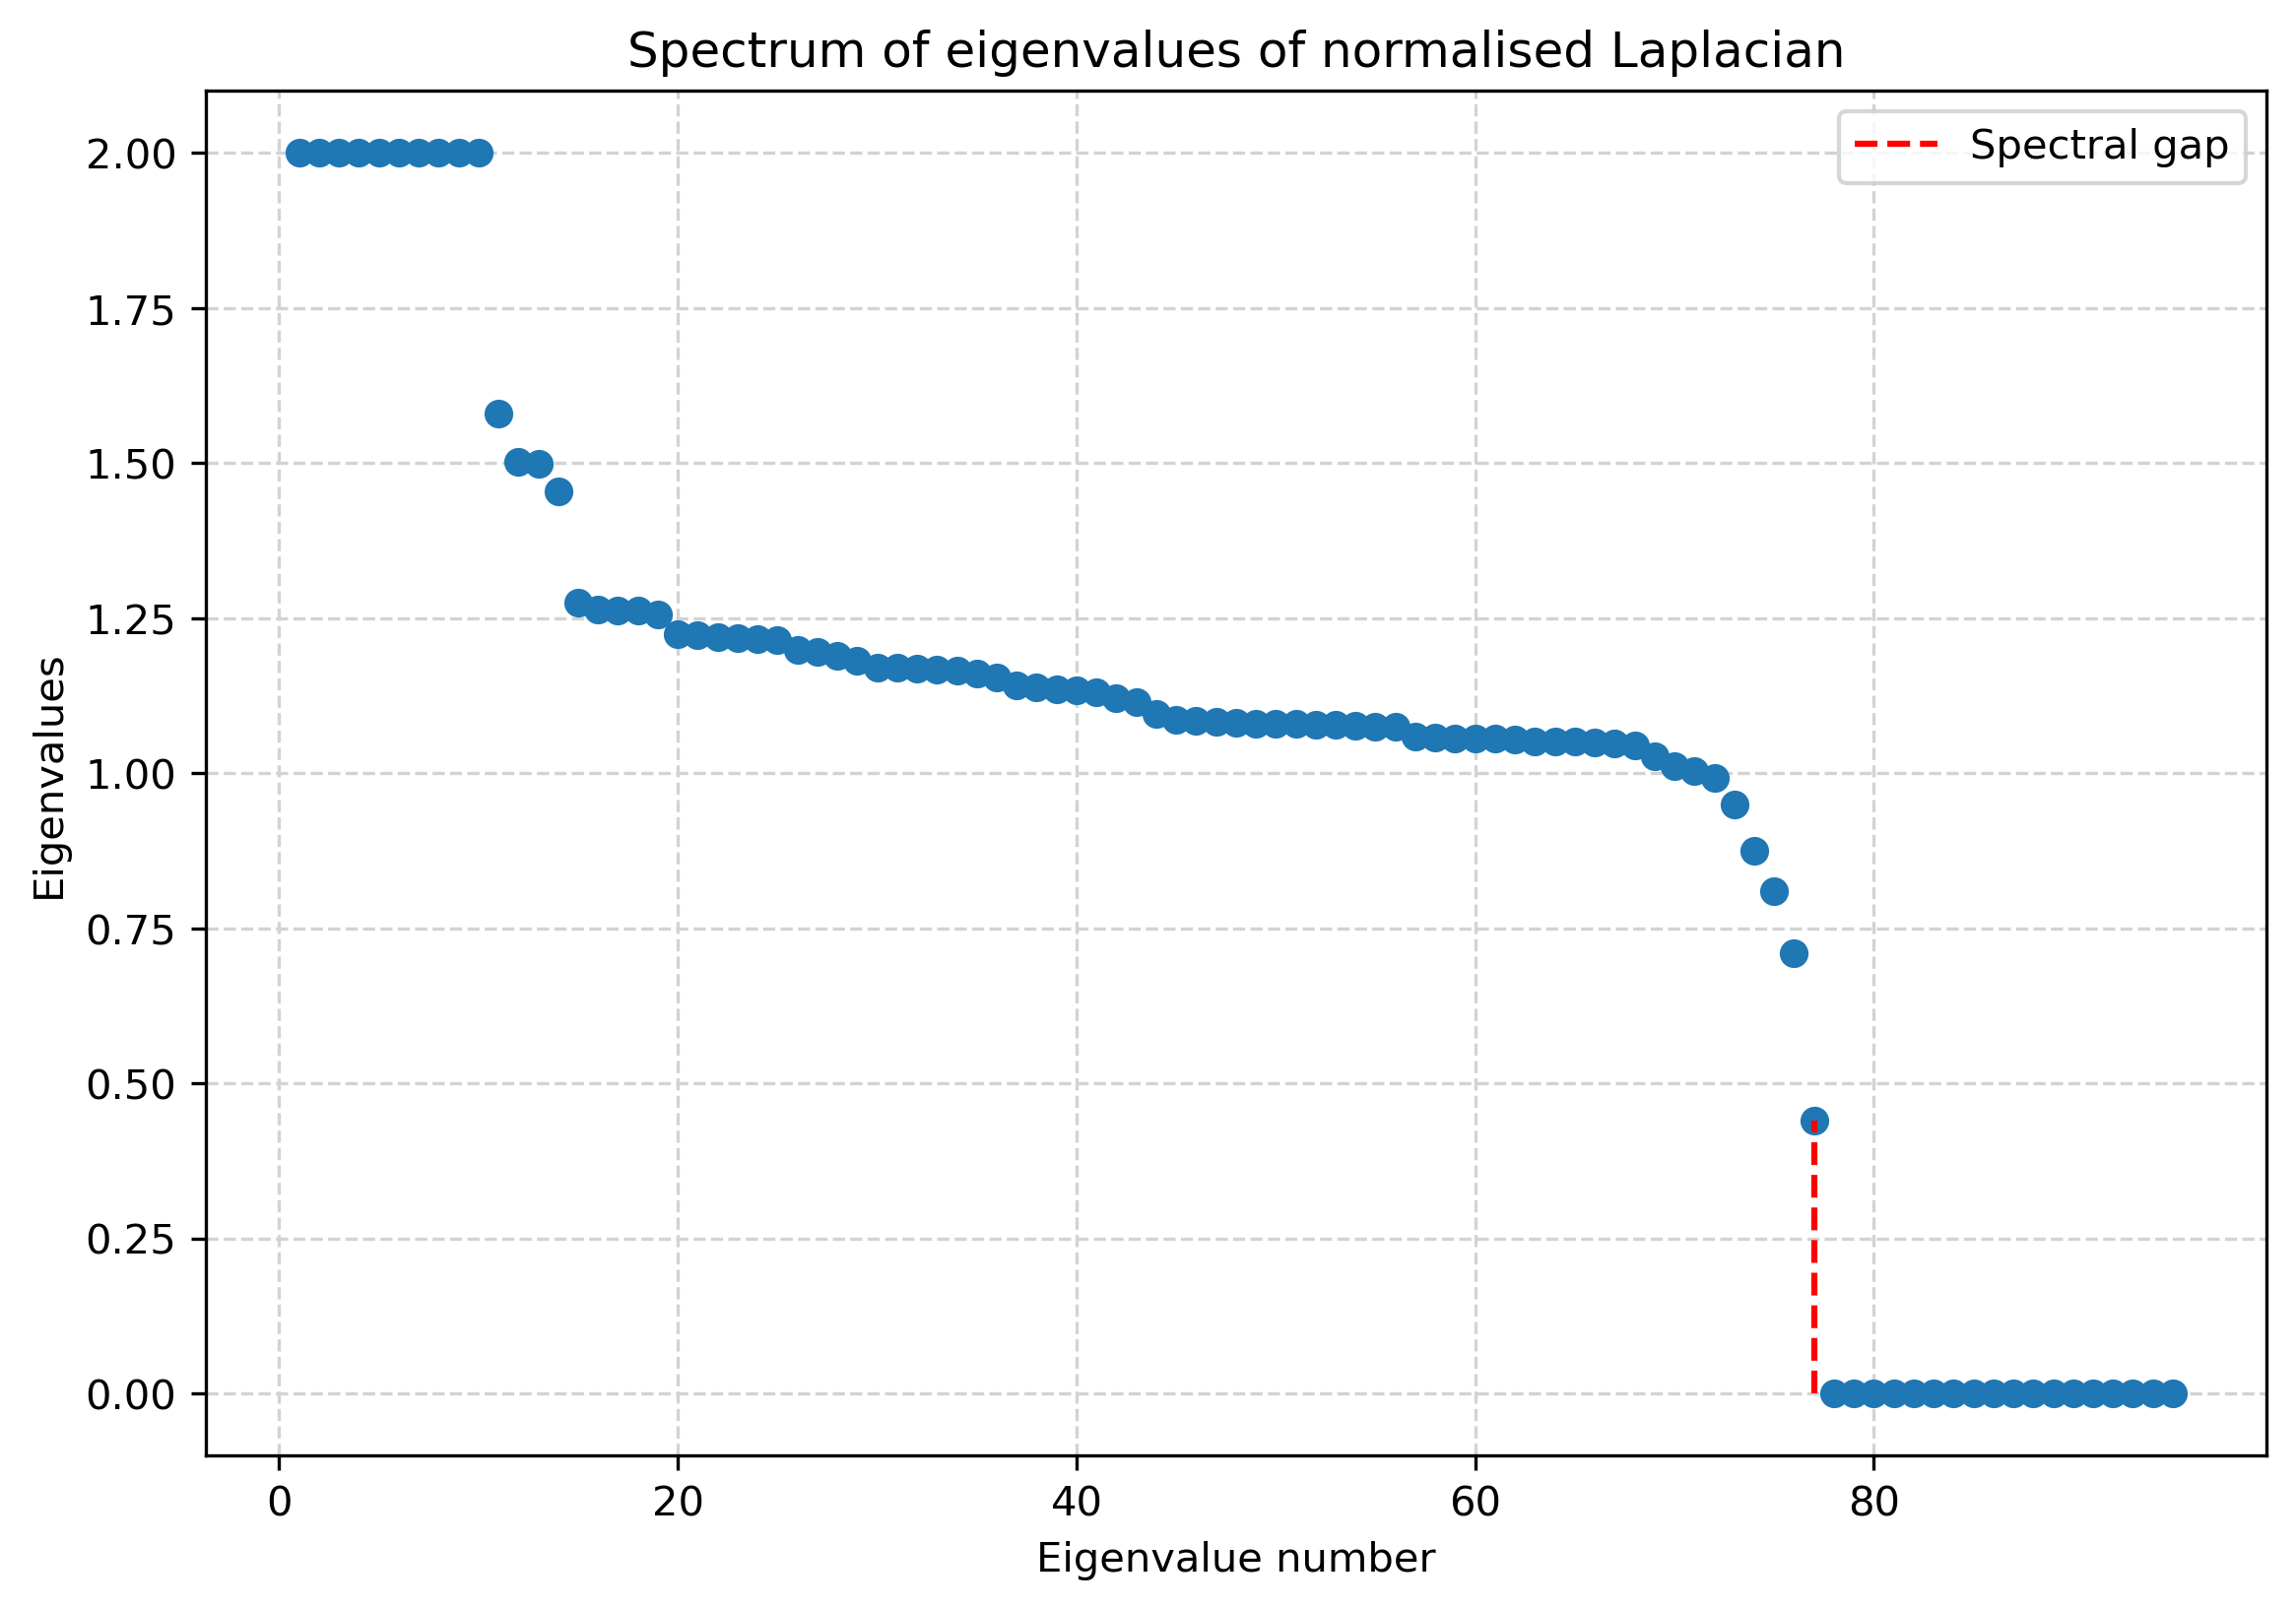

In [118]:
#plotting spectrum of normalised Laplacain
plt.scatter(range(1, len(eigenvals)+1), eigenvals[::-1])
ε = 1e-14
#values below tolerance ε, are set to zero
x_gap = np.where(np.abs(eigenvals[::-1]) > ε)[0][-1]
plt.vlines(x_gap+1, ymin = min(eigenvals[::-1]), ymax = eigenvals[::-1][x_gap],\
           linestyle = 'dashed', color = 'red', label = 'Spectral gap')

plt.legend()
plt.title('Spectrum of eigenvalues of normalised Laplacian')
plt.ylabel('Eigenvalues')
plt.xlabel('Eigenvalue number')

In [119]:
#Number of zero eigenvalues
print(f'Number of zero eigenvalues: {len(eigenvals[::-1][np.abs(eigenvals[::-1]) <= ε])}')

Number of zero eigenvalues: 18


From lectures, the number of zero eigenvalues of the laplacian is equal to the number of disconnected
components of the graph. Thus, we conclude that the graph has 18 distinct disconnected components. 

#### 2.2.4

For a given clustering $\mathcal{C} = \{c_l\}_{l=1}^k$, we define the within distance: 
$$
\mathcal{W}(C) = \frac{1}{2}\displaystyle\sum_{l=1}^k \frac{1}{|c_l|}\displaystyle\sum_{i,j\in c_l}||x^{(i)}-x^{(j)}||^2
$$

In [120]:
#eigenvectors corresponding to eigenvalues rounded numerically to zero
U = eigenvecs[:,::-1][:,np.where(np.abs(np.asarray(eigenvals[::-1])) <= ε)[0]]
U.shape

(95, 18)

In [121]:
#Normalising U
T = U/np.linalg.norm(U, axis = 1).reshape(-1,1)

In [122]:
def within_dist(X, C):
    """
    Computes the within-cluster sum of squares (WCSS) for a given clustering.
    
    Args:
    X (numpy array, shape (n_samples, n_features)): The input data.
    C (numpy array, shape (n_samples,)): The cluster labels of each sample in X.
        
    Returns:
        w (float): The WCSS of the given clustering.
    """
    w = 0
    for k in np.unique(C):
        size = len(C[C==k])
        X_cluster = X[C==k]
        distances = np.sum([np.linalg.norm(X_cluster - X_cluster[i,:]\
                                           .reshape(1,-1), axis=1)**2 for i in range(X_cluster.shape[0])])
        w += distances/size
    return w/2

We now apply k-means to the matrix T above varying k. Using the normalised within-cluster distance as defined in lectures and the elbow method, we set the appropriate value of k. 

In [123]:
#Applying k-means to T
k_range = np.arange(1,96)
scores = []
elbow = []
tolerance = 1e-3
prev = np.inf
for i in tqdm(k_range):
    #random label initialisations
    score = []
    for j in range(5):
        labels, centroids = train_k_means(T, k = i, max_iter = 30)
        score.append(within_dist(T, labels))
    current = np.mean(score)
    if np.abs(current-prev) < tolerance*prev:
        elbow.append(i)
    prev = current
        
    scores.append(current)

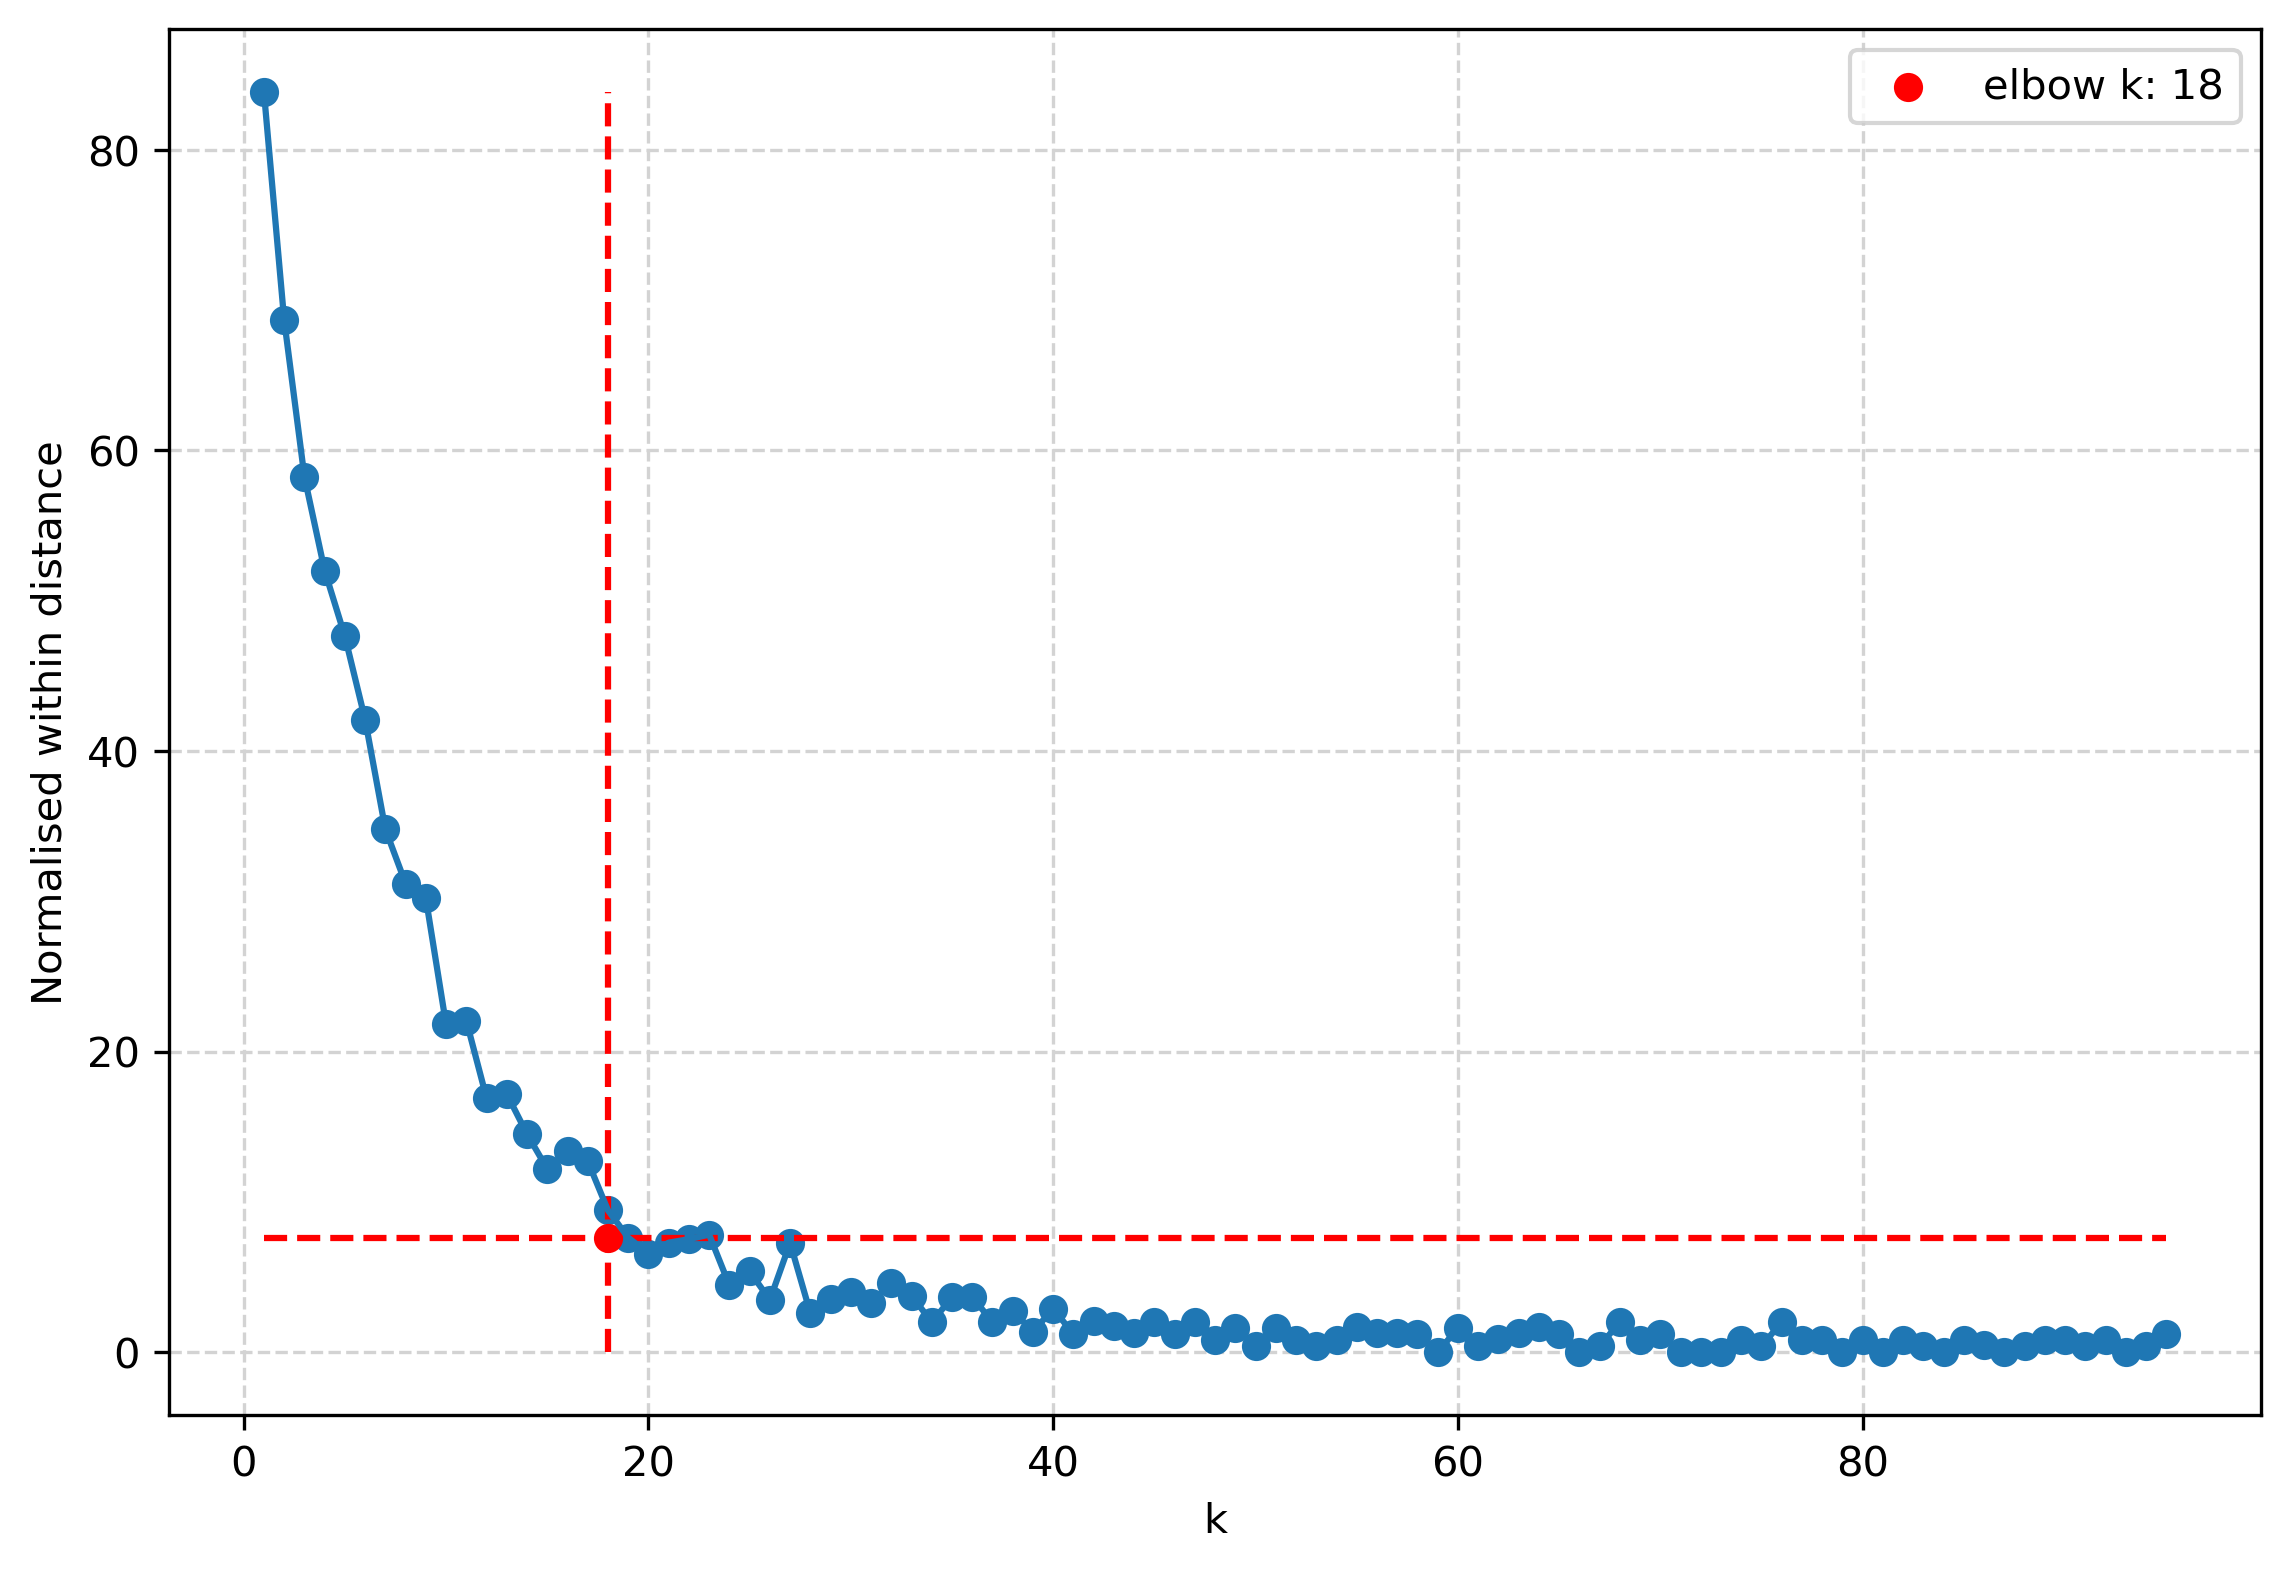

In [124]:
#plotting scores
x_elbow = 18#elbow[0]
plt.plot(k_range, scores)
plt.scatter(k_range, scores)
plt.vlines(x_elbow, ymin = min(scores), ymax = max(scores),\
           linestyle = 'dashed', color = 'red')
plt.hlines(scores[x_elbow], xmin = min(k_range), xmax = max(k_range),\
           linestyle = 'dashed', color = 'red')
plt.scatter(x_elbow, scores[x_elbow], c = 'red', label = f'elbow k: {x_elbow}')
plt.ylabel('Normalised within distance')
plt.xlabel('k')
plt.legend()

I take the point at which the loss curve 'elbows' to be at k = 18 clusters. this is because there ia a jump and the loss curve first stops to decrease as rapidly as before. 

In [125]:
# Obtain the clustering corresponding to this k and provide an
# interpretation of such clusters.
clusters, centroids = train_k_means(T, k = x_elbow, max_iter = 30)
print(f'Clusters for chosen k:\n {clusters}')

Clusters for chosen k:
 [ 8 16 16 16 15 15 11 11 17 17 17  7 17  7 17 17 17 17 17 11 11 11 11 16
 16 13 13 13 13  8  8  7  2  2 13  2 11 17  2 16 16 17  3 11 11 17 17 17
 17 14  9  9 17 17 17 11  8  2 11 11 11 13 13 13 13 17 17  7  7  7  7  7
  3 14 13 14 14 11  7 16 11 17  2  7  0  0 13 13  4  4 17 11 16 17  2]


Again, the clustrs above correspond to the 18 disconnected ocmponents of genes that operate in connection to each other, and whose expressions correlate significantly.

#### 2.2.5

We consider the biggest cluster identified in 2.2.4 and use the normalised Laplacian to perform spectral
partitioning and derive a binary partition of the subgraph corresponding to this cluster.

In [126]:
cluster_sizes = np.array([len(clusters[clusters == k]) for k in range(x_elbow)])

In [127]:
biggest_cluster = np.argmax(cluster_sizes)
print(f'biggest cluster: {biggest_cluster}') 
print(f'size: {cluster_sizes[biggest_cluster]}')

biggest cluster: 17
size: 23


In [128]:
subgraph = np.where(clusters == biggest_cluster)[0]
adjacency_mat_sub = adjacency_mat[:,subgraph]
adjacency_mat_sub = adjacency_mat_sub[subgraph,:]

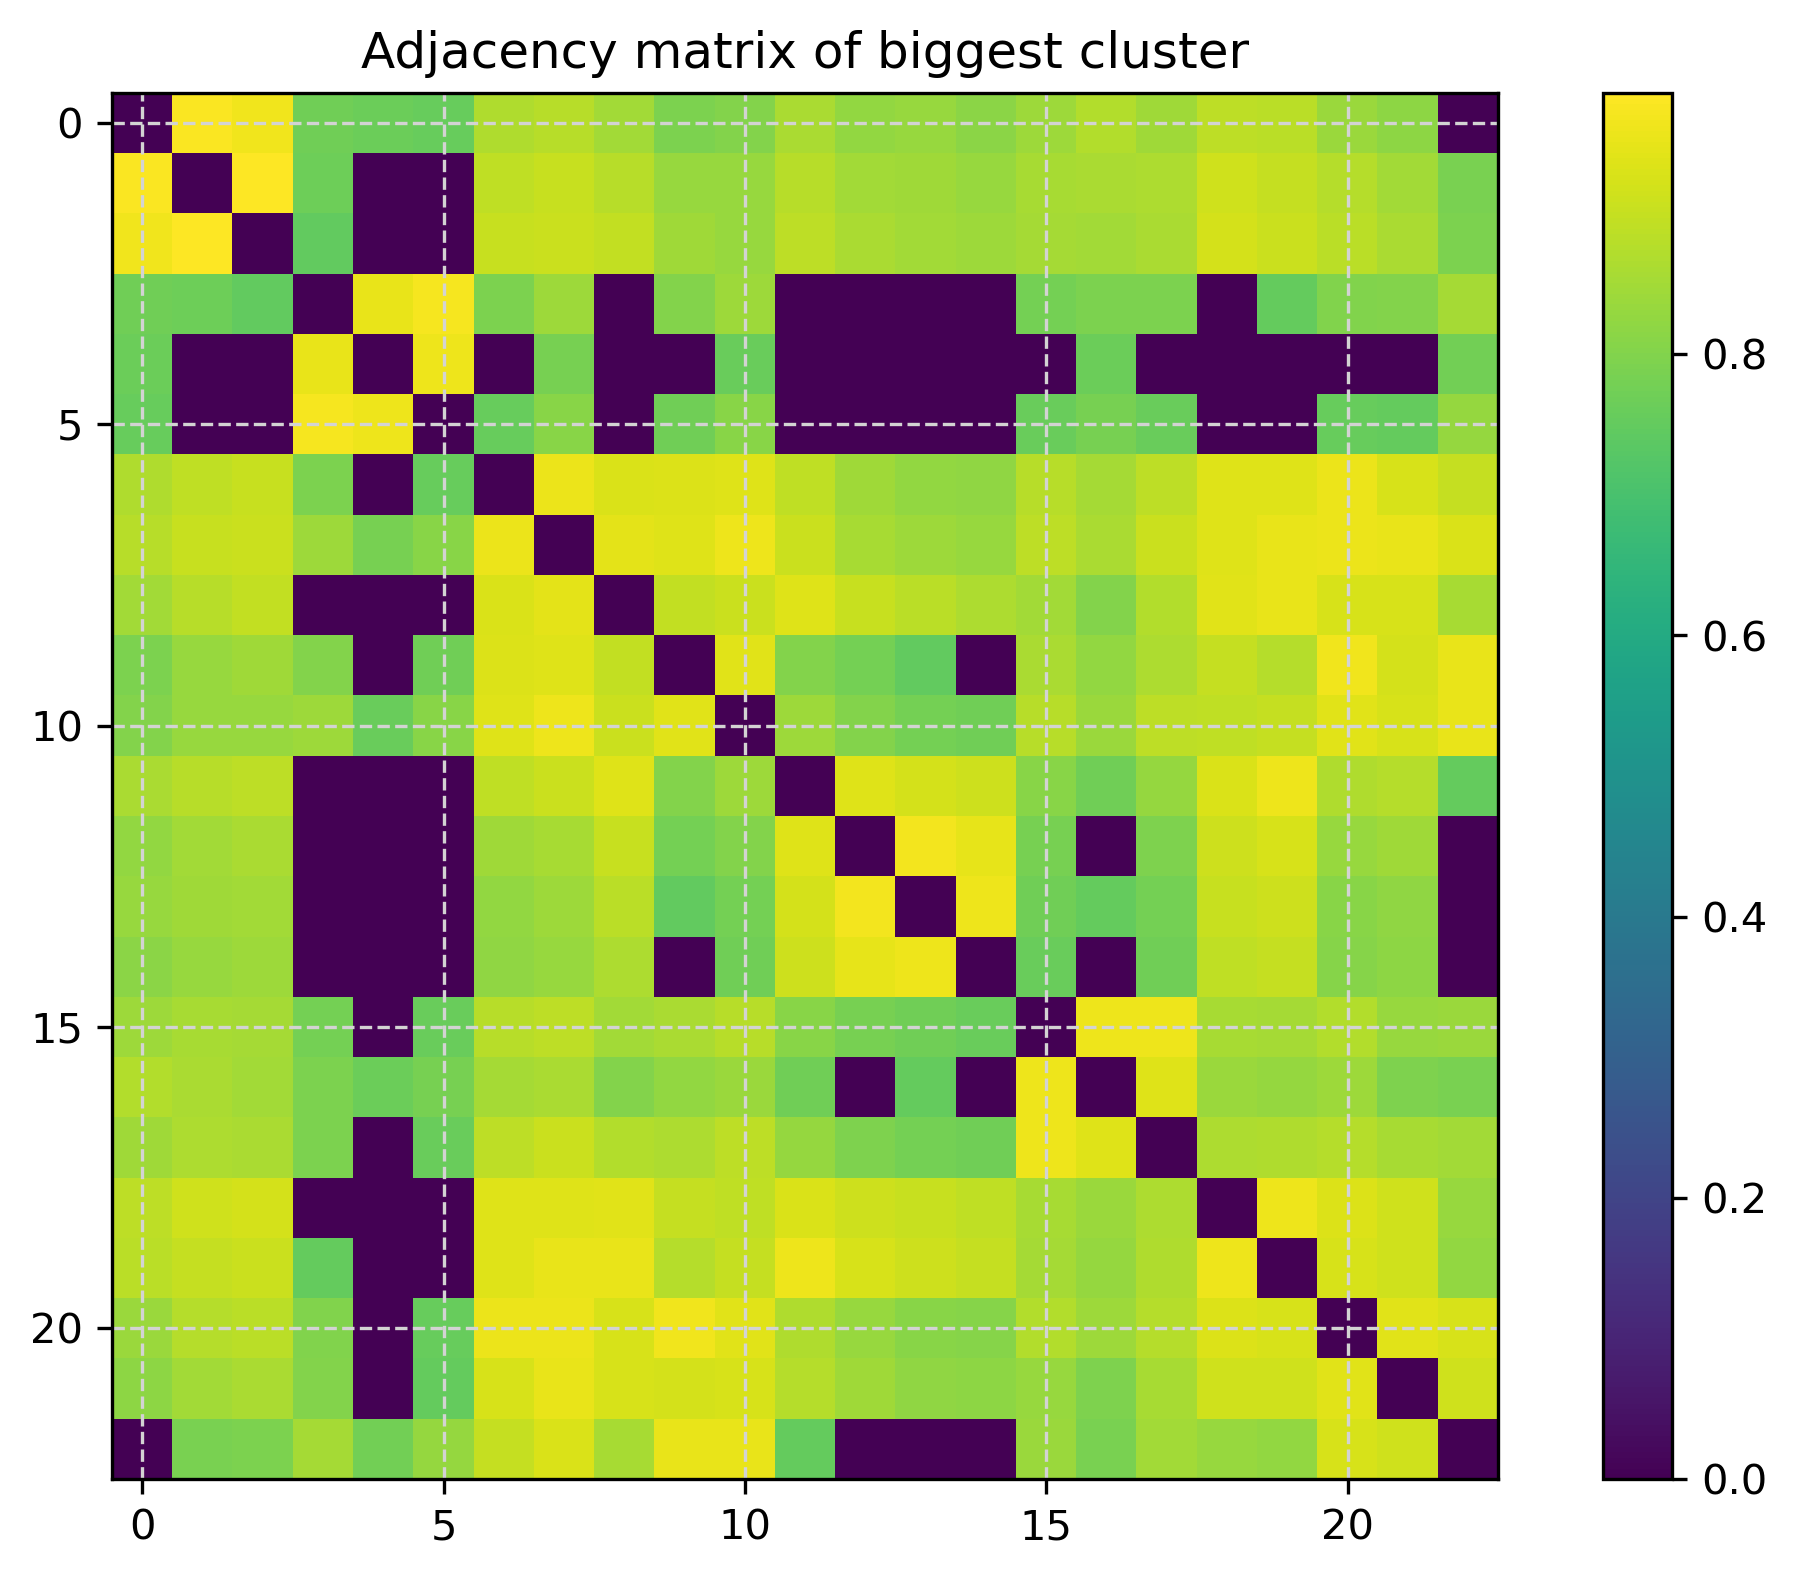

In [129]:
plt.title('Adjacency matrix of biggest cluster')
plt.imshow(adjacency_mat_sub)
plt.colorbar()

In [130]:
# laplacian of subgraph
L_sub = np.diag(np.sum(adjacency_mat_sub, axis = 0))-adjacency_mat_sub
#normalised symmetric Laplacian
D_sqrt_inv_sub = np.diag(1/np.sqrt(np.sum(adjacency_mat_sub, axis = 0)))
L_norm_sub = np.identity(L_sub.shape[0])-D_sqrt_inv_sub@adjacency_mat_sub@D_sqrt_inv_sub

In [131]:
#eigenvectors/eigenvalues of normalised laplaciain of subgraph in ascending order
eigenvals_sub, eigenvecs_sub = scipy.linalg.eigh(L_norm_sub)
#eigenvector of normalised Laplacian with second smallest eigenvalue (first non-zero)
#tolerance
ε = 1e-14
x_gap_sub = np.where(np.abs(eigenvals_sub[::-1]) > ε)[0][-1]
second_eigenvector_sub = eigenvecs_sub[:,::-1][:,x_gap_sub]

In [132]:
print(f'eigenvalues of normalised Laplacian of largest cluster:\n {eigenvals_sub}')

eigenvalues of normalised Laplacian of largest cluster:
 [1.11022302e-15 7.09824816e-01 9.49448789e-01 9.93084679e-01
 1.00281813e+00 1.01076222e+00 1.02782108e+00 1.04465433e+00
 1.04783531e+00 1.04956517e+00 1.05073999e+00 1.05162853e+00
 1.05387651e+00 1.05532375e+00 1.05570299e+00 1.05633592e+00
 1.05665956e+00 1.08600827e+00 1.09526489e+00 1.11444086e+00
 1.12087585e+00 1.15353425e+00 1.21379412e+00]


In [133]:
#second eigenvalue
print(f'magnitude of second eigenvalue is: {np.abs(eigenvals_sub[::-1][x_gap_sub])}')

magnitude of second eigenvalue is: 0.7098248164224779


In [134]:
#spectral partition - binarise positive and negrative values
spectral_partition_sub = np.where(second_eigenvector_sub > ε, 1, 0)

In [135]:
print(f' spectral partition:\n{spectral_partition_sub}')

 spectral partition:
[0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0]


In [136]:
#Adjacency matrices of subgraphs induced by bipartition
A_sub_0 = adjacency_mat_sub[:,np.where(spectral_partition_sub == 0)[0]]
A_sub_0 = A_sub_0[np.where(spectral_partition_sub == 0)[0],:]
A_sub_1 = adjacency_mat_sub[:,np.where(spectral_partition_sub == 1)[0]]
A_sub_1 = A_sub_1[np.where(spectral_partition_sub == 1)[0],:]
A_between = adjacency_mat_sub[np.where(spectral_partition_sub == 0)[0], :]
A_between = A_between[:,np.where(spectral_partition_sub == 1)[0]]
A_combined = [A_sub_0, A_sub_1, A_between]

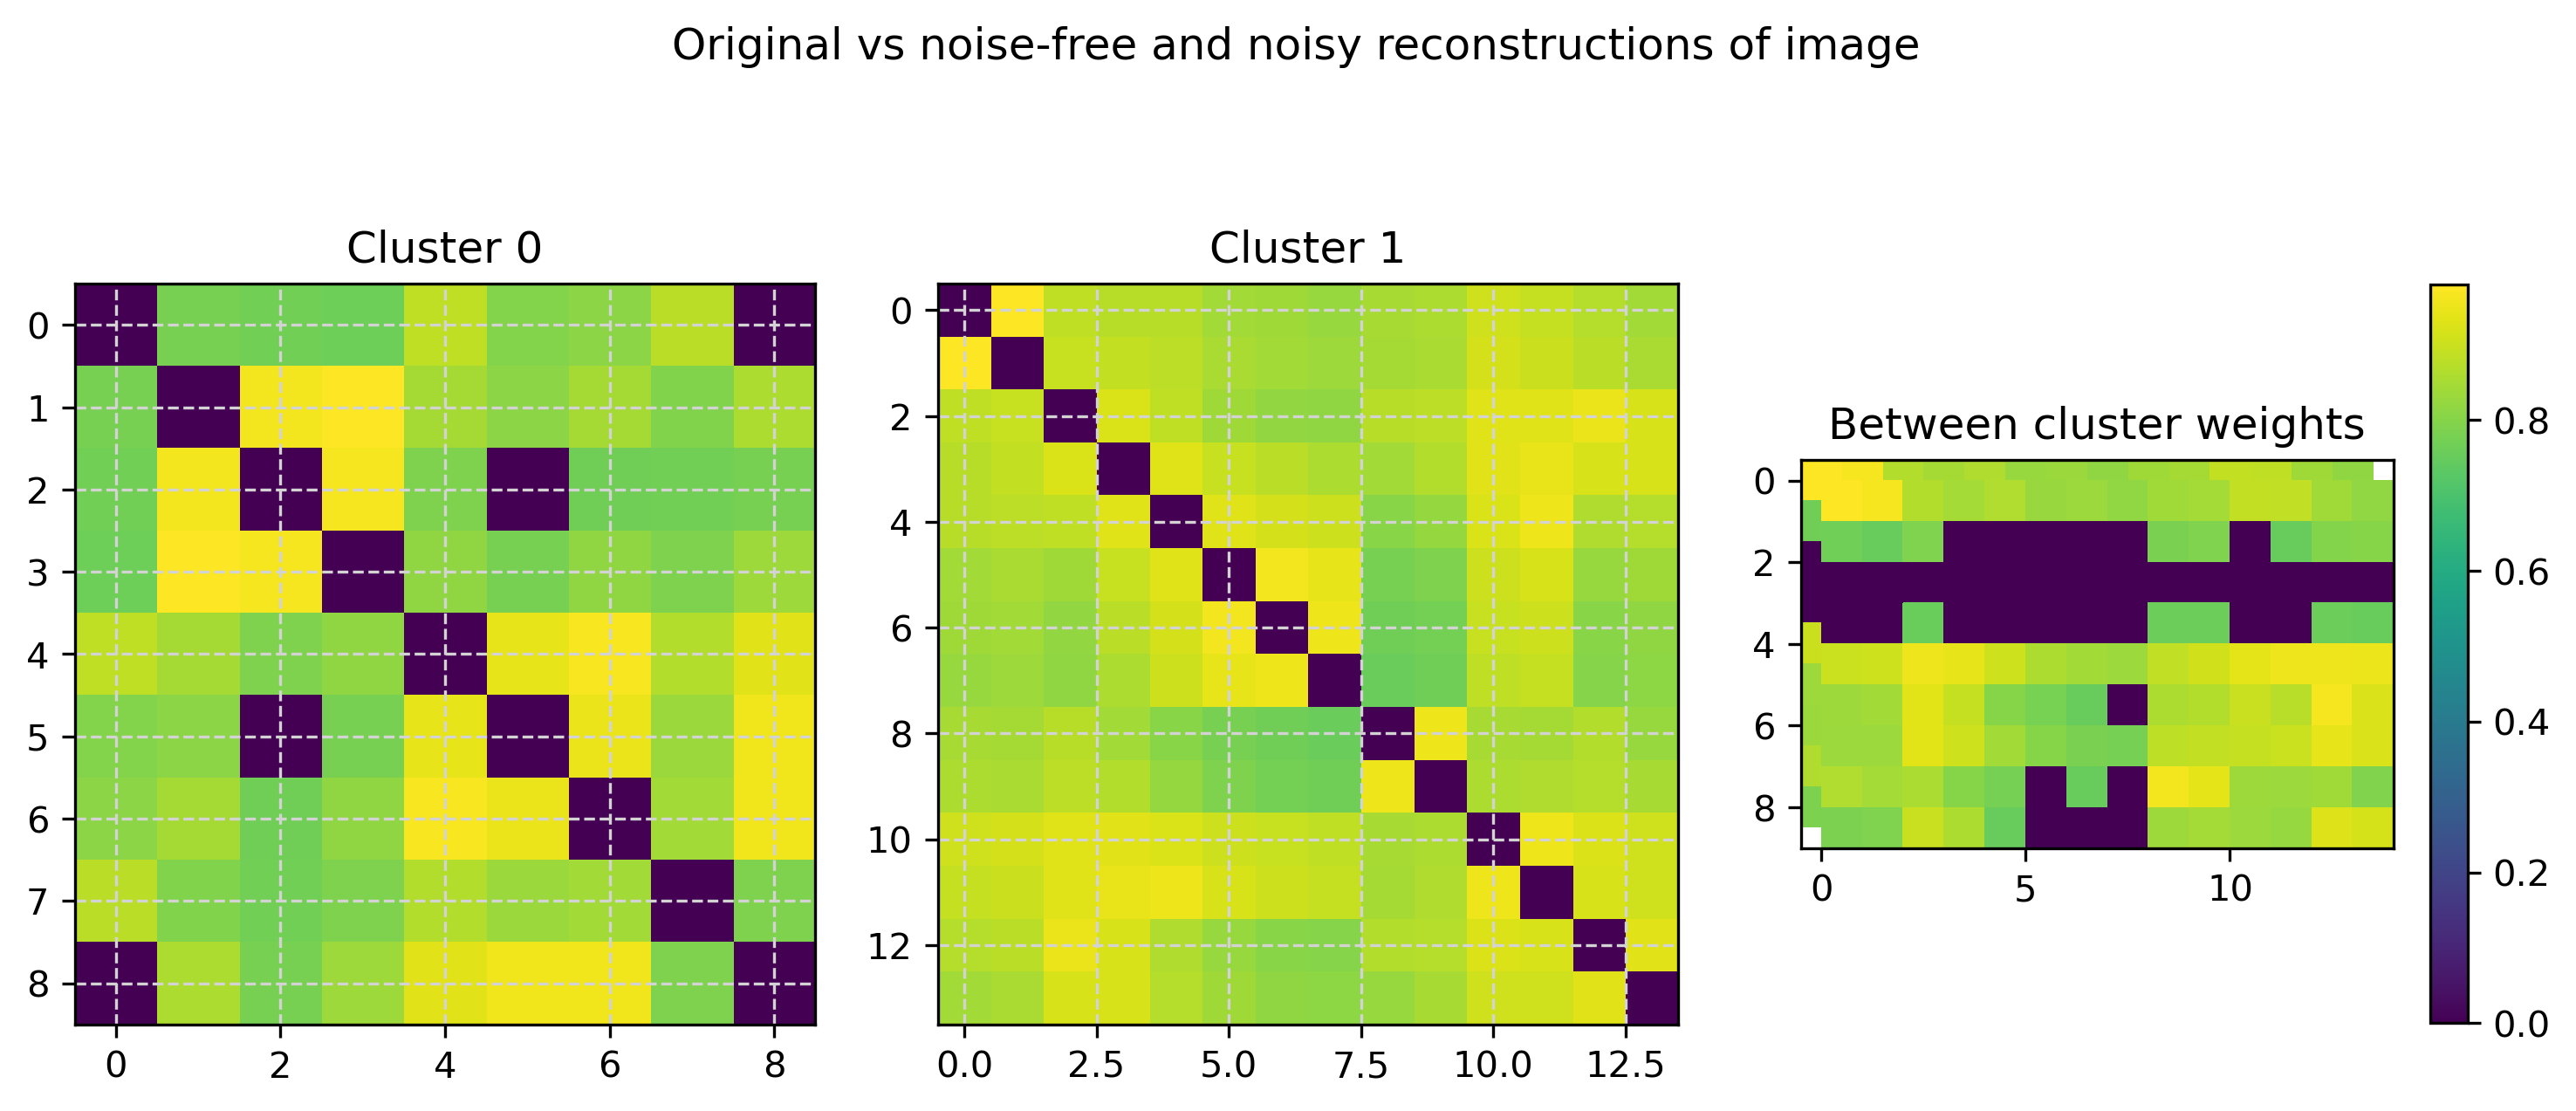

In [137]:
# plot subgraphs induces by bipartition
nrow = 1; ncol = 3;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,5))
plt.suptitle('Original vs noise-free and noisy reconstructions of image')
titles = ['Cluster 0', 'Cluster 1', 'Between cluster weights']
cmaps = 'viridis'
     
for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(A_combined[i])
    ax.set_title(f'{titles[i]}')
    
pcm = ax.pcolormesh(A_combined[2], cmap=cmaps)
fig.colorbar(pcm, ax=ax, shrink=0.6)
fig.tight_layout()

From the weighted adjacency matrices visualised above, we can see that the eigenvalue of the Fiedler eigenvector produces a parition of the graph of the biggest cluster in two two components, cluster 0 and cluster 1, where the within cluster connections between nodes are high. Furthermore, the between cluster matrix above is relatively more sparse, which is what one would have hoped the spectral partition would achieve. However, due to the eigenvector thereof being not sufficiently small (has the same order of magnitude as the next larger ones) to guarantee a 'low-cost' partition of the cluster.

#### 2.2.6

We now compare the degree centrality values with the ones obtained for the full graph in 2.2.2:

In [138]:
#computing degree centrality of subgraph
degree_centrality_subgraph = np.sum(adjacency_mat_sub, axis = 1)/np.sum(adjacency_mat_sub)
    
genes_subgraph, degree_centrality_subgraph = zip(*sorted(zip(range(len(degree_centrality_subgraph)),\
                                           degree_centrality_subgraph), key=lambda x: x[1], reverse = True))
print(f'The five genes with the highest degree centralities:\n')
for i in range(5):
    print(f'gene: {subgraph[genes_subgraph[i]]}, centrality: {degree_centrality_subgraph[i]}\n')

The five genes with the highest degree centralities:

gene: 17, centrality: 0.05289032234337935

gene: 41, centrality: 0.051044254806178795

gene: 16, centrality: 0.04994785259560674

gene: 81, centrality: 0.04965713718197439

gene: 90, centrality: 0.04894775251837667



$$
\begin{aligned}
& \text {Table 2.2.1 Comparing top five degree centralities of genes in original network and biggest cluster}\\
&\begin{array}{cccc}
\hline \hline \text { Rank } & \text { gene cluster} & \text { degree centrality cluster} & \text { gene graph} & \text { degree centrality graph} \\
\hline 1 & 17 & 0.05289032234337935 &  17 & 0.025935453030435745\\
2 & 41 & 0.051044254806178795  & 41 & 0.025378373920500033\\
3 & 16 & 0.04994785259560674  & 16 & 0.02530120481927711\\
4 & 81 & 0.04965713718197439  & 81 & 0.02523066217538562\\
5 & 90 & 0.04894775251837667  & 90 & 0.024870225673900577\\
\hline
\end{array}
\end{aligned}
$$

From table 2.2.1, we note that the rankings are the same for the full graph and the ones in the biggest cluster. This suggests that these genes are trivially in the biggest cluster. We note that the degree centralities in of the genes in the biggest cluster are almost double the full graph ones. 

Noting that the degree centrality of a node in a graph is the number of edges that are connected to it, divided by twice the total number of edges in the graph, it is a measure of a node's $\textbf{significance}$ or $\textbf{connectivity}$ in said graph.

By restrincting our attentino to the biggest cluster, nodes that are not part of the cluster are removed, thereby reducing the total edge count, thereby increasing the degree centralities of nodes therein.

## References
1. Glorot, X. &amp; Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks. <i>Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics</i>, in <i>Proceedings of Machine Learning Research</i> 9:249-256 Available from https://proceedings.mlr.press/v9/glorot10a.html.
2. Saitta, S., Raphael, B., & Smith, I. F. (2008). A comprehensive validity index for clustering. Intelligent Data Analysis, 12(6), 529-548 Available from https://core.ac.uk/reader/147948730.
3. Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958 Available from https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer.
4. Lee, D., Seung, H. Learning the parts of objects by non-negative matrix factorization. Nature 401, 788–791 (1999) Available from https://doi.org/10.1038/44565.
5. M. Barahona, P. Thomas, B. Bravi. MATH60026 Methods for Data Sciences Lecture Notes.